In [1]:
'''working with a single frozen image'''

'working with a single frozen image'

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


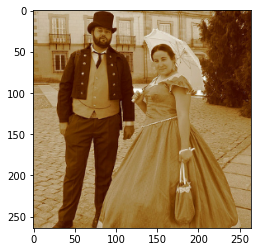

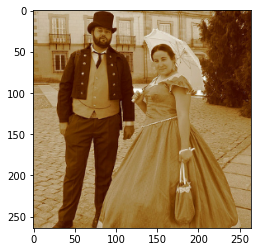

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'  # or any {'0', '1', '2'}
from imagenet_dataset import get_dataset
from retina_env import RetinaEnv, calculate_retinal_filter
from rl_networks import create_actor_model, create_critic_model, policy
from rl_core import Buffer, update_target
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import types
config = types.SimpleNamespace()
config.batch_size = 32
config.margin = 20
config.image_h = 224
config.image_w = 224
config.image_hm = config.image_h+2*config.margin
config.image_wm = config.image_w+2*config.margin
config.foveate = None
config.do_grayscale = True
config.history_length = 16
config.t_ignore = 16
config.t_max =50
config.motion_mode = 'velocity'
config.use_dones = True
config.fixed_image_num = 1 #this is a nice image

config.gym_mode = False
t_vec = np.linspace(0,150,16)

balanced_filter = calculate_retinal_filter(t_vec, R=1.0)
config.filter = balanced_filter.reshape([1,1,-1,1])
config.min_freq = 1
config.max_freq = 13
config.action_upper_bound = np.array([2.0, 2.0])

dataset_dir = '/home/bnapp/datasets/tensorflow_datasets/imagenet2012/5.0.0/'

def epsilon_scheduler(episode, floor_episode=200, epsilon_floor=0.1):
    if episode < floor_episode:
        return 1.-(1.-epsilon_floor)*episode/floor_episode
    else:
        return epsilon_floor

dataset = get_dataset(dataset_dir, 
                                     'validation', 
                                     config.batch_size, 
                                     image_h = config.image_hm,
                                     image_w = config.image_wm,
                                     deterministic=True,
                                     NUM_DATA_WORKERS=1,
                                     preprocessing='identity',
                                     rggb_mode=False,
                                     central_squeeze_and_pad_factor=-1)

# env = RetinaEnv(config, image_generator=dataset)
env = RetinaEnv(config) #freezing on first batch
for images,_ in dataset:
    break
    
images = images[config.fixed_image_num].numpy()
images = np.repeat(images[np.newaxis, :, :, :], config.batch_size, axis=0)
plt.imshow(images[0])
plt.figure()
plt.imshow(images[1])

env = RetinaEnv(config)

if config.gym_mode:
    num_states = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]

    upper_bound = env.action_space.high[0]
    lower_bound = env.action_space.low[0]
else:
    num_states = env.observation_size
    num_actions = env.action_size
    upper_bound = env.action_upper_bound
    lower_bound = env.action_lower_bound

# You might want to adjust the hyperparameters
actor_lr = 0.0001
critic_lr = 0.001
gamma = 0.99
tau = 0.005

buffer_capacity = 10000



# Create actor and critic networks
actor_model = create_actor_model(env.image_h, env.image_w, env.spectral_density_size, env.location_history_size, env.timestep_size, env.action_size)
critic_model = create_critic_model(env.image_h, env.image_w, env.spectral_density_size, env.location_history_size, env.timestep_size, env.action_size)

# Create target actor and critic networks
target_actor = create_actor_model(env.image_h, env.image_w, env.spectral_density_size, env.location_history_size, env.timestep_size, env.action_size)
target_critic = create_critic_model(env.image_h, env.image_w, env.spectral_density_size, env.location_history_size, env.timestep_size, env.action_size)

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

# Experience replay buffer
buffer = Buffer(buffer_capacity, config.batch_size, num_states=num_states, num_actions=num_actions,
                state_reshape_fn=env.unflatten_observation, use_dones=config.use_dones)

In [3]:
# Training loop
reward_records = []
epsilon_records = []
action_mean_records = []
action_var_records = []
episodes = 10000
for ep in range(episodes):
    prev_state = env.reset(images=images)
    episodic_reward = 0
    epsilon = epsilon_scheduler(ep, floor_episode=1000)

    while True:
        # tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        
        deterministic_action = policy(env.unflatten_observation(prev_state), actor_model, lower_bound, upper_bound)
        random_action = -2+4*np.random.uniform(size=(config.batch_size,2))

        if env.warmup_done:
            action = epsilon*random_action + (1-epsilon)*deterministic_action
        else:
            action = random_action

        # Recieve state and reward from environment
        state, reward, done, info = env.step(action)
        
        if env.warmup_done:
            if config.use_dones:
                buffer.record((prev_state, action, reward, state, done))
            else:   
                buffer.record((prev_state, action, reward, state))
                
            episodic_reward += reward

            buffer.learn(actor_model, target_actor, critic_model, target_critic, actor_optimizer, critic_optimizer, gamma, tau)
            update_target(target_actor.variables, actor_model.variables, tau)
            update_target(target_critic.variables, critic_model.variables, tau)
            
            action_mean_records.append(deterministic_action.numpy().mean(axis=0))
            action_var_records.append(deterministic_action.numpy().var(axis=0))
        # End this episode when `done` is True
        if done:
            break

        #prev_state = state avoid assingment by reference:
        prev_state = np.copy(state)
#         print('debug action: ', action[0])

    print(f"Episode * {ep} * exploration epsilon {epsilon} * Episodic Reward is ==> {episodic_reward.numpy().mean()}")
    print("action means and variances at step -10:", action_mean_records[-10],action_var_records[-10])
    print("action means and variances at step -5:", action_mean_records[-5],action_var_records[-5])
    reward_records.append(episodic_reward.numpy().mean())
    epsilon_records.append(epsilon)

Episode * 0 * exploration epsilon 1.0 * Episodic Reward is ==> -12.333381652832031
action means and variances at step -10: [-0.2778278   0.34645012] [0.00014419 0.00031712]
action means and variances at step -5: [-0.36689728  0.38890547] [0.00015433 0.00025801]
Episode * 1 * exploration epsilon 0.9991 * Episodic Reward is ==> -12.1640625
action means and variances at step -10: [-0.61385363  0.7501246 ] [0.00039096 0.00024861]
action means and variances at step -5: [-0.64812785  0.79189354] [0.00021523 0.00023532]
Episode * 2 * exploration epsilon 0.9982 * Episodic Reward is ==> -12.565521240234375
action means and variances at step -10: [-0.8359937  1.0140738] [0.00021608 0.00033489]
action means and variances at step -5: [-0.868747   1.0454569] [0.00028209 0.00036167]
Episode * 3 * exploration epsilon 0.9973 * Episodic Reward is ==> -12.316815376281738
action means and variances at step -10: [-1.0998533  1.3012918] [0.00041353 0.00048608]
action means and variances at step -5: [-1.138

Episode * 17 * exploration epsilon 0.9847 * Episodic Reward is ==> -12.356266021728516
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 18 * exploration epsilon 0.9838 * Episodic Reward is ==> -12.363492965698242
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 19 * exploration epsilon 0.9829 * Episodic Reward is ==> -12.233439445495605
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 20 * exploration epsilon 0.982 * Episodic Reward is ==> -12.808797836303711
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 21 * exploration epsilon 0.9811 * Episodic Reward is ==> -13.094684600830078
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.]

Episode * 35 * exploration epsilon 0.9685 * Episodic Reward is ==> -12.485845565795898
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 36 * exploration epsilon 0.9676 * Episodic Reward is ==> -12.33652114868164
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 37 * exploration epsilon 0.9667 * Episodic Reward is ==> -12.795560836791992
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 38 * exploration epsilon 0.9658 * Episodic Reward is ==> -12.702873229980469
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 39 * exploration epsilon 0.9649 * Episodic Reward is ==> -12.519393920898438
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.]

Episode * 53 * exploration epsilon 0.9523 * Episodic Reward is ==> -12.506744384765625
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 54 * exploration epsilon 0.9514 * Episodic Reward is ==> -12.316847801208496
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 55 * exploration epsilon 0.9505 * Episodic Reward is ==> -12.401895523071289
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 56 * exploration epsilon 0.9496 * Episodic Reward is ==> -12.42185115814209
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 57 * exploration epsilon 0.9487 * Episodic Reward is ==> -12.166377067565918
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.]

Episode * 70 * exploration epsilon 0.937 * Episodic Reward is ==> -12.266881942749023
action means and variances at step -10: [-2.         1.1443998] [0.000000e+00 6.424475e-05]
action means and variances at step -5: [-2.         1.1514306] [0.0000000e+00 3.5311044e-05]
Episode * 71 * exploration epsilon 0.9361 * Episodic Reward is ==> -11.980962753295898
action means and variances at step -10: [-2.         1.2675768] [0.0000000e+00 2.7946564e-05]
action means and variances at step -5: [-2.         1.3611363] [0.000000e+00 4.770626e-05]
Episode * 72 * exploration epsilon 0.9352 * Episodic Reward is ==> -12.076394081115723
action means and variances at step -10: [-2.         1.7136053] [0.0000000e+00 4.7234607e-05]
action means and variances at step -5: [-2.         1.7017922] [0.000000e+00 6.411661e-05]
Episode * 73 * exploration epsilon 0.9343 * Episodic Reward is ==> -12.764721870422363
action means and variances at step -10: [-2.         1.6155776] [0.0000000e+00 3.6170037e-05]
acti

Episode * 87 * exploration epsilon 0.9217 * Episodic Reward is ==> -12.195426940917969
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 88 * exploration epsilon 0.9208 * Episodic Reward is ==> -12.842693328857422
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 89 * exploration epsilon 0.9198999999999999 * Episodic Reward is ==> -12.311165809631348
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 90 * exploration epsilon 0.919 * Episodic Reward is ==> -12.59712028503418
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 91 * exploration epsilon 0.9181 * Episodic Reward is ==> -12.243667602539062
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5

Episode * 105 * exploration epsilon 0.9055 * Episodic Reward is ==> -12.401845932006836
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 106 * exploration epsilon 0.9046 * Episodic Reward is ==> -12.716939926147461
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 107 * exploration epsilon 0.9037 * Episodic Reward is ==> -12.585134506225586
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 108 * exploration epsilon 0.9028 * Episodic Reward is ==> -12.203535079956055
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 109 * exploration epsilon 0.9019 * Episodic Reward is ==> -12.320255279541016
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2

Episode * 123 * exploration epsilon 0.8893 * Episodic Reward is ==> -12.83812141418457
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 124 * exploration epsilon 0.8884 * Episodic Reward is ==> -12.759563446044922
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 125 * exploration epsilon 0.8875 * Episodic Reward is ==> -12.274031639099121
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 126 * exploration epsilon 0.8866 * Episodic Reward is ==> -12.929412841796875
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 127 * exploration epsilon 0.8857 * Episodic Reward is ==> -12.06385612487793
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2. 

Episode * 141 * exploration epsilon 0.8731 * Episodic Reward is ==> -12.583352088928223
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 142 * exploration epsilon 0.8722 * Episodic Reward is ==> -12.859907150268555
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 143 * exploration epsilon 0.8713 * Episodic Reward is ==> -12.063440322875977
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 144 * exploration epsilon 0.8704000000000001 * Episodic Reward is ==> -12.329655647277832
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 145 * exploration epsilon 0.8694999999999999 * Episodic Reward is ==> -12.440742492675781
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and v

Episode * 159 * exploration epsilon 0.8569 * Episodic Reward is ==> -12.1446533203125
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 160 * exploration epsilon 0.856 * Episodic Reward is ==> -12.497712135314941
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 161 * exploration epsilon 0.8551 * Episodic Reward is ==> -12.586194038391113
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 162 * exploration epsilon 0.8542 * Episodic Reward is ==> -12.693504333496094
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 163 * exploration epsilon 0.8533 * Episodic Reward is ==> -12.60626220703125
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2

Episode * 177 * exploration epsilon 0.8407 * Episodic Reward is ==> -12.597896575927734
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 178 * exploration epsilon 0.8398 * Episodic Reward is ==> -12.423799514770508
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 179 * exploration epsilon 0.8389 * Episodic Reward is ==> -12.134090423583984
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 180 * exploration epsilon 0.838 * Episodic Reward is ==> -12.325454711914062
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 181 * exploration epsilon 0.8371 * Episodic Reward is ==> -12.195145606994629
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.

Episode * 195 * exploration epsilon 0.8245 * Episodic Reward is ==> -12.766063690185547
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 196 * exploration epsilon 0.8236 * Episodic Reward is ==> -12.79236125946045
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 197 * exploration epsilon 0.8227 * Episodic Reward is ==> -11.995277404785156
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 198 * exploration epsilon 0.8218 * Episodic Reward is ==> -13.154195785522461
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.  2.] [0. 0.]
Episode * 199 * exploration epsilon 0.8209 * Episodic Reward is ==> -12.877670288085938
action means and variances at step -10: [-2.  2.] [0. 0.]
action means and variances at step -5: [-2.

Episode * 212 * exploration epsilon 0.8091999999999999 * Episodic Reward is ==> -12.512187957763672
action means and variances at step -10: [-2.         -0.13333382] [0.000000e+00 7.700179e-06]
action means and variances at step -5: [-2.         -0.12827186] [0.0000000e+00 1.2249673e-05]
Episode * 213 * exploration epsilon 0.8083 * Episodic Reward is ==> -12.54517650604248
action means and variances at step -10: [-2.         -0.11090635] [0.000000e+00 6.170972e-06]
action means and variances at step -5: [-2.         -0.10503055] [0.000000e+00 7.814439e-06]
Episode * 214 * exploration epsilon 0.8074 * Episodic Reward is ==> -12.09496784210205
action means and variances at step -10: [-2.         -0.16492137] [0.000000e+00 7.936407e-06]
action means and variances at step -5: [-2.         -0.17929986] [0.000000e+00 5.709793e-06]
Episode * 215 * exploration epsilon 0.8065 * Episodic Reward is ==> -12.28436279296875
action means and variances at step -10: [-2.         -0.31435487] [0.0000000

Episode * 228 * exploration epsilon 0.7948 * Episodic Reward is ==> -12.084549903869629
action means and variances at step -10: [-2.         -0.20313585] [0.0000000e+00 7.0770984e-06]
action means and variances at step -5: [-2.        -0.1937753] [0.000000e+00 7.088935e-06]
Episode * 229 * exploration epsilon 0.7939 * Episodic Reward is ==> -12.488394737243652
action means and variances at step -10: [-2.        -0.2881419] [0.0000000e+00 3.5775738e-06]
action means and variances at step -5: [-2.         -0.25912163] [0.0000000e+00 3.9644015e-06]
Episode * 230 * exploration epsilon 0.793 * Episodic Reward is ==> -11.88541316986084
action means and variances at step -10: [-2.         -0.23716429] [0.000000e+00 1.921316e-06]
action means and variances at step -5: [-2.         -0.23039916] [0.0000000e+00 1.7888335e-06]
Episode * 231 * exploration epsilon 0.7921 * Episodic Reward is ==> -12.145889282226562
action means and variances at step -10: [-2.       -0.259262] [0.0000000e+00 1.401888

Episode * 244 * exploration epsilon 0.7804 * Episodic Reward is ==> -12.183450698852539
action means and variances at step -10: [-2.         -0.19838865] [0.0000000e+00 3.1297545e-06]
action means and variances at step -5: [-2.         -0.23226054] [0.0000000e+00 1.8908041e-06]
Episode * 245 * exploration epsilon 0.7795 * Episodic Reward is ==> -11.612164497375488
action means and variances at step -10: [-2.         -0.12522542] [0.0000000e+00 1.5126666e-06]
action means and variances at step -5: [-2.         -0.14077595] [0.000000e+00 6.961642e-07]
Episode * 246 * exploration epsilon 0.7786 * Episodic Reward is ==> -12.132951736450195
action means and variances at step -10: [-2.         -0.33112982] [0.0000000e+00 3.6381737e-06]
action means and variances at step -5: [-2.         -0.31460083] [0.000000e+00 1.226527e-06]
Episode * 247 * exploration epsilon 0.7777000000000001 * Episodic Reward is ==> -11.69051742553711
action means and variances at step -10: [-2.         -0.27727634] [0

Episode * 259 * exploration epsilon 0.7669 * Episodic Reward is ==> -12.390302658081055
action means and variances at step -10: [-2.         -0.08589127] [0.0000000e+00 1.3561262e-06]
action means and variances at step -5: [-2.         -0.14413817] [0.0000000e+00 1.2697119e-06]
Episode * 260 * exploration epsilon 0.766 * Episodic Reward is ==> -12.057909965515137
action means and variances at step -10: [-2.         -0.16430178] [0.000000e+00 3.961107e-06]
action means and variances at step -5: [-2.         -0.17189598] [0.000000e+00 8.464327e-07]
Episode * 261 * exploration epsilon 0.7651 * Episodic Reward is ==> -11.947779655456543
action means and variances at step -10: [-2.         -0.22587053] [0.00000e+00 8.88098e-06]
action means and variances at step -5: [-2.         -0.24335998] [0.00000000e+00 1.06008665e-05]
Episode * 262 * exploration epsilon 0.7642 * Episodic Reward is ==> -11.891551971435547
action means and variances at step -10: [-2.        -0.2579691] [0.0000000e+00 1.1

Episode * 275 * exploration epsilon 0.7525 * Episodic Reward is ==> -12.433135986328125
action means and variances at step -10: [-2.         -0.23179235] [0.0000000e+00 1.2708351e-06]
action means and variances at step -5: [-2.         -0.24149428] [0.000000e+00 1.782794e-06]
Episode * 276 * exploration epsilon 0.7516 * Episodic Reward is ==> -11.823888778686523
action means and variances at step -10: [-2.         -0.23986746] [0.0000000e+00 2.0707625e-06]
action means and variances at step -5: [-2.         -0.23654345] [0.000000e+00 7.428137e-07]
Episode * 277 * exploration epsilon 0.7506999999999999 * Episodic Reward is ==> -12.13481616973877
action means and variances at step -10: [-2.         -0.34365082] [0.0000000e+00 3.4823827e-06]
action means and variances at step -5: [-2.         -0.33007705] [0.0000000e+00 1.4877568e-06]
Episode * 278 * exploration epsilon 0.7498 * Episodic Reward is ==> -12.211647987365723
action means and variances at step -10: [-2.         -0.22719894] [0

Episode * 291 * exploration epsilon 0.7381 * Episodic Reward is ==> -11.728751182556152
action means and variances at step -10: [-2.        -0.0575202] [0.0000000e+00 1.4621071e-06]
action means and variances at step -5: [-2.         -0.04836299] [0.0000000e+00 1.2600119e-06]
Episode * 292 * exploration epsilon 0.7372 * Episodic Reward is ==> -11.860429763793945
action means and variances at step -10: [-2.         -0.10202912] [0.000000e+00 3.419372e-07]
action means and variances at step -5: [-2.         -0.11109632] [0.0000000e+00 3.8416263e-07]
Episode * 293 * exploration epsilon 0.7363 * Episodic Reward is ==> -12.113283157348633
action means and variances at step -10: [-2.         -0.07181485] [0.0000000e+00 1.3737225e-06]
action means and variances at step -5: [-2.         -0.09957453] [0.000000e+00 1.612279e-06]
Episode * 294 * exploration epsilon 0.7354 * Episodic Reward is ==> -12.242716789245605
action means and variances at step -10: [-2.         -0.08623872] [0.000000e+00 6

Episode * 306 * exploration epsilon 0.7245999999999999 * Episodic Reward is ==> -12.270267486572266
action means and variances at step -10: [-2.         -0.15752079] [0.0000000e+00 7.6509417e-07]
action means and variances at step -5: [-2.         -0.14669682] [0.000000e+00 4.292088e-07]
Episode * 307 * exploration epsilon 0.7237 * Episodic Reward is ==> -11.632823944091797
action means and variances at step -10: [-2.         -0.14063261] [0.0000000e+00 4.9566455e-07]
action means and variances at step -5: [-2.       -0.137099] [0.00000e+00 4.94391e-07]
Episode * 308 * exploration epsilon 0.7228 * Episodic Reward is ==> -12.1016845703125
action means and variances at step -10: [-2.        -0.1530284] [0.0000000e+00 1.1299268e-06]
action means and variances at step -5: [-2.        -0.1402004] [0.000000e+00 8.156153e-07]
Episode * 309 * exploration epsilon 0.7219 * Episodic Reward is ==> -11.832416534423828
action means and variances at step -10: [-2.         -0.12301061] [0.0000000e+00 

Episode * 322 * exploration epsilon 0.7101999999999999 * Episodic Reward is ==> -12.212820053100586
action means and variances at step -10: [-2.         -0.48056895] [0.000000e+00 4.349945e-07]
action means and variances at step -5: [-2.        -0.4812078] [0.000000e+00 5.361569e-07]
Episode * 323 * exploration epsilon 0.7093 * Episodic Reward is ==> -11.497661590576172
action means and variances at step -10: [-2.        -0.4795586] [0.0000000e+00 2.3788684e-06]
action means and variances at step -5: [-2.         -0.47018796] [0.0000000e+00 1.6178171e-06]
Episode * 324 * exploration epsilon 0.7083999999999999 * Episodic Reward is ==> -12.1669921875
action means and variances at step -10: [-2.         -0.44326168] [0.0000000e+00 8.3304366e-07]
action means and variances at step -5: [-2.         -0.44606403] [0.000000e+00 8.247679e-07]
Episode * 325 * exploration epsilon 0.7075 * Episodic Reward is ==> -11.777081489562988
action means and variances at step -10: [-2.         -0.48159343] 

Episode * 337 * exploration epsilon 0.6967 * Episodic Reward is ==> -11.698257446289062
action means and variances at step -10: [-2.         -0.08839998] [0.0000000e+00 7.7464114e-07]
action means and variances at step -5: [-2.         -0.09914316] [0.0000000e+00 4.4360308e-07]
Episode * 338 * exploration epsilon 0.6958 * Episodic Reward is ==> -11.532112121582031
action means and variances at step -10: [-2.         -0.10792436] [0.0000000e+00 3.9697218e-07]
action means and variances at step -5: [-2.         -0.09767707] [0.0000000e+00 1.6429382e-07]
Episode * 339 * exploration epsilon 0.6949 * Episodic Reward is ==> -11.540894508361816
action means and variances at step -10: [-2.         -0.09437417] [0.0000000e+00 3.4561893e-07]
action means and variances at step -5: [-2.         -0.10003998] [0.000000e+00 2.605998e-07]
Episode * 340 * exploration epsilon 0.694 * Episodic Reward is ==> -11.338418960571289
action means and variances at step -10: [-2.         -0.08593866] [0.0000000e+

Episode * 353 * exploration epsilon 0.6823 * Episodic Reward is ==> -11.68704891204834
action means and variances at step -10: [-2.        -0.4113498] [0.0000000e+00 3.4233565e-06]
action means and variances at step -5: [-2.         -0.42506212] [0.0000000e+00 2.3641967e-06]
Episode * 354 * exploration epsilon 0.6814 * Episodic Reward is ==> -11.924860000610352
action means and variances at step -10: [-2.         -0.45746118] [0.0000000e+00 1.4560991e-06]
action means and variances at step -5: [-2.         -0.49292487] [0.0000000e+00 1.5863607e-06]
Episode * 355 * exploration epsilon 0.6805 * Episodic Reward is ==> -11.976020812988281
action means and variances at step -10: [-2.        -0.4879569] [0.0000000e+00 1.0268271e-06]
action means and variances at step -5: [-2.        -0.4691911] [0.00000e+00 5.92098e-07]
Episode * 356 * exploration epsilon 0.6796 * Episodic Reward is ==> -11.91644287109375
action means and variances at step -10: [-2.        -0.4469903] [0.0000000e+00 5.634940

Episode * 369 * exploration epsilon 0.6678999999999999 * Episodic Reward is ==> -11.536946296691895
action means and variances at step -10: [-2.        -0.3322908] [0.0000000e+00 6.1666987e-07]
action means and variances at step -5: [-2.         -0.34006166] [0.0000000e+00 5.1058714e-07]
Episode * 370 * exploration epsilon 0.667 * Episodic Reward is ==> -11.991413116455078
action means and variances at step -10: [-2.        -0.3372507] [0.0000000e+00 6.3550857e-07]
action means and variances at step -5: [-2.        -0.3405488] [0.0000000e+00 3.5623148e-07]
Episode * 371 * exploration epsilon 0.6660999999999999 * Episodic Reward is ==> -11.75370979309082
action means and variances at step -10: [-2.         -0.30476147] [0.000000e+00 5.095191e-07]
action means and variances at step -5: [-2.        -0.3189153] [0.0000000e+00 4.5151268e-07]
Episode * 372 * exploration epsilon 0.6652 * Episodic Reward is ==> -11.796869277954102
action means and variances at step -10: [-2.        -0.3726004]

Episode * 384 * exploration epsilon 0.6544 * Episodic Reward is ==> -11.800909996032715
action means and variances at step -10: [-2.        -0.0781454] [0.000000e+00 3.150428e-07]
action means and variances at step -5: [-2.         -0.08614007] [0.0000000e+00 1.1443259e-07]
Episode * 385 * exploration epsilon 0.6535 * Episodic Reward is ==> -11.524984359741211
action means and variances at step -10: [-2.         -0.10348456] [0.000000e+00 6.099065e-07]
action means and variances at step -5: [-2.         -0.09103755] [0.000e+00 2.016e-07]
Episode * 386 * exploration epsilon 0.6526 * Episodic Reward is ==> -11.775372505187988
action means and variances at step -10: [-2.         -0.08046198] [0.0000000e+00 2.8061237e-07]
action means and variances at step -5: [-2.         -0.08188015] [0.0000000e+00 2.2683508e-07]
Episode * 387 * exploration epsilon 0.6517 * Episodic Reward is ==> -12.035072326660156
action means and variances at step -10: [-2.         -0.09922276] [0.000000e+00 2.942324e

Episode * 400 * exploration epsilon 0.64 * Episodic Reward is ==> -11.690943717956543
action means and variances at step -10: [-2.        -0.1278122] [0.000000e+00 1.450974e-07]
action means and variances at step -5: [-2.         -0.10341202] [0.000000e+00 1.442892e-07]
Episode * 401 * exploration epsilon 0.6391 * Episodic Reward is ==> -11.917654037475586
action means and variances at step -10: [-2.         -0.13351665] [0.000000e+00 5.270366e-07]
action means and variances at step -5: [-2.         -0.12527783] [0.00000e+00 2.59657e-07]
Episode * 402 * exploration epsilon 0.6382 * Episodic Reward is ==> -11.85551643371582
action means and variances at step -10: [-2.         -0.12726663] [0.000000e+00 2.380113e-07]
action means and variances at step -5: [-2.        -0.1290102] [0.0000000e+00 1.5739073e-07]
Episode * 403 * exploration epsilon 0.6373 * Episodic Reward is ==> -11.54065227508545
action means and variances at step -10: [-2.        -0.1373109] [0.0000000e+00 1.8424679e-07]
a

Episode * 416 * exploration epsilon 0.6255999999999999 * Episodic Reward is ==> -12.007840156555176
action means and variances at step -10: [-2.         -0.13155445] [0.000000e+00 4.905733e-07]
action means and variances at step -5: [-2.         -0.09961586] [0.0000000e+00 2.7825718e-07]
Episode * 417 * exploration epsilon 0.6247 * Episodic Reward is ==> -11.346940040588379
action means and variances at step -10: [-2.        -0.1355533] [0.0000000e+00 2.5871665e-07]
action means and variances at step -5: [-2.         -0.14043376] [0.000000e+00 2.191078e-07]
Episode * 418 * exploration epsilon 0.6238 * Episodic Reward is ==> -11.563045501708984
action means and variances at step -10: [-2.         -0.12946464] [0.0000000e+00 2.2673899e-07]
action means and variances at step -5: [-2.         -0.11936095] [0.000000e+00 1.464035e-07]
Episode * 419 * exploration epsilon 0.6229 * Episodic Reward is ==> -11.163654327392578
action means and variances at step -10: [-2.         -0.13965715] [0.00

Episode * 432 * exploration epsilon 0.6112 * Episodic Reward is ==> -11.697885513305664
action means and variances at step -10: [-2.         -0.16225271] [0.0000000e+00 4.0530432e-07]
action means and variances at step -5: [-2.         -0.14230675] [0.0000000e+00 1.5439909e-07]
Episode * 433 * exploration epsilon 0.6103000000000001 * Episodic Reward is ==> -11.686576843261719
action means and variances at step -10: [-2.        -0.1113336] [0.0000000e+00 1.1190718e-07]
action means and variances at step -5: [-2.         -0.10608074] [0.0000000e+00 1.2557072e-07]
Episode * 434 * exploration epsilon 0.6093999999999999 * Episodic Reward is ==> -11.645814895629883
action means and variances at step -10: [-2.        -0.1149113] [0.0000000e+00 3.4940626e-07]
action means and variances at step -5: [-2.        -0.1517478] [0.0000000e+00 2.3107907e-07]
Episode * 435 * exploration epsilon 0.6085 * Episodic Reward is ==> -12.151309967041016
action means and variances at step -10: [-2.         -0.1

Episode * 447 * exploration epsilon 0.5977 * Episodic Reward is ==> -11.966182708740234
action means and variances at step -10: [-2.         -0.08155151] [0.0000000e+00 1.0418259e-07]
action means and variances at step -5: [-2.         -0.08870336] [0.0000e+00 6.0484e-08]
Episode * 448 * exploration epsilon 0.5968 * Episodic Reward is ==> -11.58725357055664
action means and variances at step -10: [-2.         -0.09169844] [0.00000000e+00 1.00741914e-07]
action means and variances at step -5: [-2.         -0.08883234] [0.0000000e+00 7.3907444e-08]
Episode * 449 * exploration epsilon 0.5959 * Episodic Reward is ==> -11.703388214111328
action means and variances at step -10: [-2.         -0.09437364] [0.000000e+00 9.108152e-08]
action means and variances at step -5: [-2.         -0.08712891] [0.0000000e+00 4.4974396e-08]
Episode * 450 * exploration epsilon 0.595 * Episodic Reward is ==> -11.784488677978516
action means and variances at step -10: [-2.         -0.06664797] [0.0000000e+00 1.

Episode * 463 * exploration epsilon 0.5832999999999999 * Episodic Reward is ==> -11.64206314086914
action means and variances at step -10: [-2.         -0.15145208] [0.0000000e+00 3.4676825e-07]
action means and variances at step -5: [-2.         -0.14852028] [0.0000000e+00 1.9158873e-07]
Episode * 464 * exploration epsilon 0.5824 * Episodic Reward is ==> -11.275543212890625
action means and variances at step -10: [-2.         -0.14557935] [0.000000e+00 7.867627e-08]
action means and variances at step -5: [-2.         -0.16037986] [0.000000e+00 9.363937e-08]
Episode * 465 * exploration epsilon 0.5815 * Episodic Reward is ==> -11.430757522583008
action means and variances at step -10: [-2.         -0.17465942] [0.0000e+00 2.4867e-07]
action means and variances at step -5: [-2.         -0.17528257] [0.0000000e+00 3.2589801e-07]
Episode * 466 * exploration epsilon 0.5806 * Episodic Reward is ==> -11.444976806640625
action means and variances at step -10: [-2.         -0.16167764] [0.00000

Episode * 479 * exploration epsilon 0.5689 * Episodic Reward is ==> -11.29623794555664
action means and variances at step -10: [-2.        -0.1123495] [0.000000e+00 8.400193e-08]
action means and variances at step -5: [-2.         -0.10352168] [0.0000000e+00 8.8202995e-08]
Episode * 480 * exploration epsilon 0.5680000000000001 * Episodic Reward is ==> -11.11932373046875
action means and variances at step -10: [-2.        -0.1283358] [0.000000e+00 3.984408e-08]
action means and variances at step -5: [-2.         -0.13204652] [0.0000000e+00 3.5818783e-08]
Episode * 481 * exploration epsilon 0.5670999999999999 * Episodic Reward is ==> -11.068756103515625
action means and variances at step -10: [-2.         -0.14172074] [0.0000000e+00 1.3593825e-07]
action means and variances at step -5: [-2.        -0.1359928] [0.0000000e+00 1.3913865e-07]
Episode * 482 * exploration epsilon 0.5662 * Episodic Reward is ==> -11.928985595703125
action means and variances at step -10: [-2.         -0.1394326

Episode * 495 * exploration epsilon 0.5545 * Episodic Reward is ==> -11.036810874938965
action means and variances at step -10: [-2.        -0.1333807] [0.000000e+00 8.525659e-08]
action means and variances at step -5: [-2.         -0.13620889] [0.0000000e+00 6.3254205e-08]
Episode * 496 * exploration epsilon 0.5536 * Episodic Reward is ==> -11.157426834106445
action means and variances at step -10: [-2.         -0.12216602] [0.0000000e+00 1.1925032e-07]
action means and variances at step -5: [-2.         -0.12489203] [0.0000000e+00 2.8285344e-08]
Episode * 497 * exploration epsilon 0.5527 * Episodic Reward is ==> -11.284801483154297
action means and variances at step -10: [-2.         -0.12264331] [0.00000e+00 6.29179e-08]
action means and variances at step -5: [-2.         -0.12241781] [0.000000e+00 7.650936e-08]
Episode * 498 * exploration epsilon 0.5518000000000001 * Episodic Reward is ==> -11.668426513671875
action means and variances at step -10: [-2.       -0.145942] [0.000000e+

Episode * 511 * exploration epsilon 0.5401 * Episodic Reward is ==> -11.228914260864258
action means and variances at step -10: [-2.         -0.13787277] [0.000000e+00 7.980441e-08]
action means and variances at step -5: [-2.         -0.12685156] [0.0000000e+00 4.7571206e-08]
Episode * 512 * exploration epsilon 0.5392 * Episodic Reward is ==> -11.395875930786133
action means and variances at step -10: [-2.         -0.11877411] [0.000000e+00 7.738298e-08]
action means and variances at step -5: [-2.         -0.11522855] [0.000000e+00 5.118835e-08]
Episode * 513 * exploration epsilon 0.5383 * Episodic Reward is ==> -11.382950782775879
action means and variances at step -10: [-2.         -0.12171607] [0.000000e+00 6.336493e-08]
action means and variances at step -5: [-2.         -0.12466978] [0.0000000e+00 4.8060116e-08]
Episode * 514 * exploration epsilon 0.5374 * Episodic Reward is ==> -11.164579391479492
action means and variances at step -10: [-2.         -0.13564353] [0.000000e+00 6.3

Episode * 527 * exploration epsilon 0.5257000000000001 * Episodic Reward is ==> -11.631670951843262
action means and variances at step -10: [-2.         -0.14714286] [0.00000000e+00 1.08475604e-07]
action means and variances at step -5: [-2.         -0.15353544] [0.000000e+00 4.664662e-08]
Episode * 528 * exploration epsilon 0.5247999999999999 * Episodic Reward is ==> -11.451324462890625
action means and variances at step -10: [-2.        -0.1648154] [0.0000000e+00 2.9855437e-07]
action means and variances at step -5: [-2.         -0.16607007] [0.0000000e+00 1.3272658e-07]
Episode * 529 * exploration epsilon 0.5239 * Episodic Reward is ==> -11.675365447998047
action means and variances at step -10: [-2.        -0.1553304] [0.0000000e+00 1.7411958e-07]
action means and variances at step -5: [-2.         -0.16553828] [0.0000000e+00 1.2201934e-07]
Episode * 530 * exploration epsilon 0.523 * Episodic Reward is ==> -11.350423812866211
action means and variances at step -10: [-2.         -0.

Episode * 542 * exploration epsilon 0.5122 * Episodic Reward is ==> -11.81610107421875
action means and variances at step -10: [-2.         -0.16678411] [0.00000e+00 7.71651e-08]
action means and variances at step -5: [-2.         -0.17200677] [0.0000000e+00 4.3837318e-08]
Episode * 543 * exploration epsilon 0.5113000000000001 * Episodic Reward is ==> -11.84432601928711
action means and variances at step -10: [-2.         -0.15562405] [0.0000000e+00 1.7615608e-07]
action means and variances at step -5: [-2.        -0.1681505] [0.0000000e+00 1.3972759e-07]
Episode * 544 * exploration epsilon 0.5104 * Episodic Reward is ==> -10.840723991394043
action means and variances at step -10: [-2.         -0.11884095] [0.0000000e+00 9.4003475e-08]
action means and variances at step -5: [-2.         -0.13151723] [0.000000e+00 5.966552e-08]
Episode * 545 * exploration epsilon 0.5095000000000001 * Episodic Reward is ==> -11.062080383300781
action means and variances at step -10: [-2.         -0.11614

Episode * 558 * exploration epsilon 0.4978 * Episodic Reward is ==> -11.081618309020996
action means and variances at step -10: [-2.         -0.14792143] [0.0000000e+00 2.5933056e-07]
action means and variances at step -5: [-2.         -0.14634667] [0.0000000e+00 1.4155069e-07]
Episode * 559 * exploration epsilon 0.4969 * Episodic Reward is ==> -11.548727989196777
action means and variances at step -10: [-2.         -0.14669731] [0.000000e+00 9.712655e-08]
action means and variances at step -5: [-2.         -0.15155785] [0.000000e+00 6.496879e-08]
Episode * 560 * exploration epsilon 0.496 * Episodic Reward is ==> -10.84445571899414
action means and variances at step -10: [-2.         -0.15714024] [0.000000e+00 7.796487e-08]
action means and variances at step -5: [-2.         -0.15850349] [0.0000000e+00 6.7566184e-08]
Episode * 561 * exploration epsilon 0.4951 * Episodic Reward is ==> -11.599176406860352
action means and variances at step -10: [-2.       -0.139698] [0.0000000e+00 9.6294

Episode * 573 * exploration epsilon 0.48429999999999995 * Episodic Reward is ==> -11.38165283203125
action means and variances at step -10: [-2.         -0.14063406] [0.000000e+00 8.307297e-08]
action means and variances at step -5: [-2.         -0.14573987] [0.0000000e+00 5.0374076e-08]
Episode * 574 * exploration epsilon 0.48339999999999994 * Episodic Reward is ==> -11.70637321472168
action means and variances at step -10: [-2.        -0.1724091] [0.000000e+00 9.686833e-08]
action means and variances at step -5: [-2.         -0.18186924] [0.000000e+00 7.438159e-08]
Episode * 575 * exploration epsilon 0.48250000000000004 * Episodic Reward is ==> -11.525699615478516
action means and variances at step -10: [-2.         -0.16122946] [0.0000000e+00 3.9785313e-08]
action means and variances at step -5: [-2.        -0.1381864] [0.0000000e+00 2.8970948e-08]
Episode * 576 * exploration epsilon 0.48160000000000003 * Episodic Reward is ==> -11.089685440063477
action means and variances at step 

Episode * 589 * exploration epsilon 0.4699 * Episodic Reward is ==> -11.602909088134766
action means and variances at step -10: [-2.         -0.13560204] [0.0000000e+00 1.5287564e-07]
action means and variances at step -5: [-2.        -0.1380953] [0.0000000e+00 1.0625454e-07]
Episode * 590 * exploration epsilon 0.469 * Episodic Reward is ==> -11.637277603149414
action means and variances at step -10: [-2.         -0.14500459] [0.0000000e+00 1.3769849e-07]
action means and variances at step -5: [-2.       -0.150517] [0.0000000e+00 5.3160687e-08]
Episode * 591 * exploration epsilon 0.46810000000000007 * Episodic Reward is ==> -11.342235565185547
action means and variances at step -10: [-2.         -0.13988198] [0.0000000e+00 1.1126745e-07]
action means and variances at step -5: [-2.         -0.13070859] [0.0000000e+00 7.2735176e-08]
Episode * 592 * exploration epsilon 0.46719999999999995 * Episodic Reward is ==> -10.938685417175293
action means and variances at step -10: [-2.         -0.

Episode * 604 * exploration epsilon 0.45640000000000003 * Episodic Reward is ==> -11.28203010559082
action means and variances at step -10: [-2.         -0.16001439] [0.0000000e+00 1.3223772e-07]
action means and variances at step -5: [-2.         -0.17117713] [0.0000000e+00 1.0428601e-07]
Episode * 605 * exploration epsilon 0.4555 * Episodic Reward is ==> -11.348005294799805
action means and variances at step -10: [-2.         -0.16460566] [0.0000000e+00 1.2204916e-07]
action means and variances at step -5: [-2.         -0.16725229] [0.000000e+00 6.494756e-08]
Episode * 606 * exploration epsilon 0.4546 * Episodic Reward is ==> -11.743429183959961
action means and variances at step -10: [-2.        -0.1925243] [0.000000e+00 8.987779e-08]
action means and variances at step -5: [-2.         -0.19624162] [0.0000000e+00 5.4858095e-08]
Episode * 607 * exploration epsilon 0.4536999999999999 * Episodic Reward is ==> -11.57829475402832
action means and variances at step -10: [-2.         -0.18

Episode * 620 * exploration epsilon 0.44199999999999995 * Episodic Reward is ==> -11.890416145324707
action means and variances at step -10: [-2.        -0.5335457] [0.000000e+00 2.738151e-07]
action means and variances at step -5: [-2.        -0.5412573] [0.000000e+00 1.933066e-07]
Episode * 621 * exploration epsilon 0.44110000000000005 * Episodic Reward is ==> -12.18667221069336
action means and variances at step -10: [-2.         -0.52097684] [0.0000000e+00 1.2413018e-07]
action means and variances at step -5: [-2.        -0.5448812] [0.000000e+00 9.832856e-08]
Episode * 622 * exploration epsilon 0.4401999999999999 * Episodic Reward is ==> -12.185697555541992
action means and variances at step -10: [-2.        -0.5438799] [0.0000000e+00 1.2269959e-07]
action means and variances at step -5: [-2.        -0.5422251] [0.0000000e+00 8.6076255e-08]
Episode * 623 * exploration epsilon 0.4392999999999999 * Episodic Reward is ==> -11.825004577636719
action means and variances at step -10: [-

Episode * 635 * exploration epsilon 0.4285 * Episodic Reward is ==> -12.3090181350708
action means and variances at step -10: [-2.        -0.5238028] [0.000000e+00 1.046229e-07]
action means and variances at step -5: [-2.        -0.5274887] [0.000000e+00 8.498268e-08]
Episode * 636 * exploration epsilon 0.4276 * Episodic Reward is ==> -12.184309005737305
action means and variances at step -10: [-2.         -0.49128526] [0.0000000e+00 1.0313825e-07]
action means and variances at step -5: [-2.         -0.49854702] [0.0000000e+00 8.5529095e-08]
Episode * 637 * exploration epsilon 0.42669999999999997 * Episodic Reward is ==> -12.11844253540039
action means and variances at step -10: [-2.         -0.50728875] [0.0000000e+00 1.1044993e-07]
action means and variances at step -5: [-2.         -0.50485027] [0.00000e+00 9.67112e-08]
Episode * 638 * exploration epsilon 0.42579999999999996 * Episodic Reward is ==> -12.32016372680664
action means and variances at step -10: [-2.         -0.54128414]

Episode * 651 * exploration epsilon 0.4141 * Episodic Reward is ==> -11.256952285766602
action means and variances at step -10: [-2.         -0.18475573] [0.0000000e+00 1.8221799e-07]
action means and variances at step -5: [-2.         -0.17136365] [0.000000e+00 1.671622e-07]
Episode * 652 * exploration epsilon 0.4131999999999999 * Episodic Reward is ==> -11.600889205932617
action means and variances at step -10: [-2.        -0.2216955] [0.0000000e+00 1.8106869e-07]
action means and variances at step -5: [-2.         -0.22222526] [0.0000000e+00 1.4225184e-07]
Episode * 653 * exploration epsilon 0.4123 * Episodic Reward is ==> -11.339221000671387
action means and variances at step -10: [-2.         -0.19844584] [0.0000000e+00 1.1207433e-07]
action means and variances at step -5: [-2.         -0.20004047] [0.0000000e+00 1.4612066e-07]
Episode * 654 * exploration epsilon 0.4114 * Episodic Reward is ==> -11.44373893737793
action means and variances at step -10: [-2.        -0.2173421] [0.0

Episode * 666 * exploration epsilon 0.40060000000000007 * Episodic Reward is ==> -11.270463943481445
action means and variances at step -10: [-2.         -0.19946386] [0.0000000e+00 1.2997589e-07]
action means and variances at step -5: [-2.        -0.1940794] [0.0000000e+00 1.0925434e-07]
Episode * 667 * exploration epsilon 0.39969999999999994 * Episodic Reward is ==> -11.672253608703613
action means and variances at step -10: [-2.         -0.21387768] [0.00000000e+00 1.17677345e-07]
action means and variances at step -5: [-2.         -0.20155399] [0.00000000e+00 1.00316534e-07]
Episode * 668 * exploration epsilon 0.39879999999999993 * Episodic Reward is ==> -11.997665405273438
action means and variances at step -10: [-2.        -0.2559541] [0.0000000e+00 1.3479637e-07]
action means and variances at step -5: [-2.         -0.25474787] [0.00000000e+00 1.05169285e-07]
Episode * 669 * exploration epsilon 0.39790000000000003 * Episodic Reward is ==> -11.29556655883789
action means and varia

Episode * 682 * exploration epsilon 0.3861999999999999 * Episodic Reward is ==> -11.53669548034668
action means and variances at step -10: [-2.         -0.21157049] [0.0000000e+00 1.3765894e-07]
action means and variances at step -5: [-2.         -0.21561076] [0.000000e+00 8.806473e-08]
Episode * 683 * exploration epsilon 0.3853 * Episodic Reward is ==> -11.364532470703125
action means and variances at step -10: [-2.        -0.2191749] [0.000000e+00 1.330786e-07]
action means and variances at step -5: [-2.        -0.2224788] [0.00000000e+00 1.06436744e-07]
Episode * 684 * exploration epsilon 0.38439999999999996 * Episodic Reward is ==> -11.874462127685547
action means and variances at step -10: [-2.         -0.23305923] [0.0000000e+00 1.6509586e-07]
action means and variances at step -5: [-2.        -0.2407089] [0.0000000e+00 1.3932441e-07]
Episode * 685 * exploration epsilon 0.38349999999999995 * Episodic Reward is ==> -11.448083877563477
action means and variances at step -10: [-2.  

Episode * 697 * exploration epsilon 0.3726999999999999 * Episodic Reward is ==> -12.041027069091797
action means and variances at step -10: [-2.         -0.39659587] [0.0000000e+00 1.2448598e-07]
action means and variances at step -5: [-2.        -0.3672564] [0.000000e+00 6.627343e-08]
Episode * 698 * exploration epsilon 0.3717999999999999 * Episodic Reward is ==> -11.952576637268066
action means and variances at step -10: [-2.        -0.5018151] [0.0000000e+00 6.5080224e-07]
action means and variances at step -5: [-2.        -0.5008891] [0.0000000e+00 2.6549492e-07]
Episode * 699 * exploration epsilon 0.3709 * Episodic Reward is ==> -12.512025833129883
action means and variances at step -10: [-2.         -0.48700413] [0.000000e+00 5.974834e-07]
action means and variances at step -5: [-2.         -0.49092358] [0.0000000e+00 1.8354754e-07]
Episode * 700 * exploration epsilon 0.37 * Episodic Reward is ==> -12.33837890625
action means and variances at step -10: [-2.        -0.5293584] [0.

Episode * 713 * exploration epsilon 0.35829999999999995 * Episodic Reward is ==> -11.154073715209961
action means and variances at step -10: [-2.        -0.1825208] [0.0000000e+00 1.5209295e-07]
action means and variances at step -5: [-2.         -0.18804348] [0.0000000e+00 1.0924122e-07]
Episode * 714 * exploration epsilon 0.35739999999999994 * Episodic Reward is ==> -11.679384231567383
action means and variances at step -10: [-2.         -0.18393007] [0.0000000e+00 1.4497148e-07]
action means and variances at step -5: [-2.         -0.19503029] [0.0000000e+00 1.6177566e-07]
Episode * 715 * exploration epsilon 0.35650000000000004 * Episodic Reward is ==> -11.554637908935547
action means and variances at step -10: [-2.         -0.16664183] [0.000000e+00 9.526003e-08]
action means and variances at step -5: [-2.        -0.1719531] [0.000000e+00 8.320527e-08]
Episode * 716 * exploration epsilon 0.3556 * Episodic Reward is ==> -11.030377388000488
action means and variances at step -10: [-2.

Episode * 728 * exploration epsilon 0.3448 * Episodic Reward is ==> -12.129559516906738
action means and variances at step -10: [-2.         -0.27413625] [0.0000000e+00 2.2645942e-07]
action means and variances at step -5: [-2.        -0.2648717] [0.0000000e+00 1.4058368e-07]
Episode * 729 * exploration epsilon 0.3439 * Episodic Reward is ==> -11.64280891418457
action means and variances at step -10: [-2.         -0.24474481] [0.0000000e+00 1.7728604e-07]
action means and variances at step -5: [-2.         -0.23512071] [0.000000e+00 1.982135e-07]
Episode * 730 * exploration epsilon 0.34299999999999997 * Episodic Reward is ==> -11.71503734588623
action means and variances at step -10: [-2.         -0.23407546] [0.0000000e+00 1.9441404e-07]
action means and variances at step -5: [-2.         -0.25316256] [0.0000000e+00 2.0976454e-07]
Episode * 731 * exploration epsilon 0.34210000000000007 * Episodic Reward is ==> -11.964740753173828
action means and variances at step -10: [-2.         -0

Episode * 744 * exploration epsilon 0.3304 * Episodic Reward is ==> -12.694320678710938
action means and variances at step -10: [-2.         -0.46877792] [0.0000000e+00 1.9324938e-07]
action means and variances at step -5: [-2.        -0.4925084] [0.0000000e+00 1.2784457e-07]
Episode * 745 * exploration epsilon 0.3295 * Episodic Reward is ==> -12.875167846679688
action means and variances at step -10: [-2.        -0.4799857] [0.0000000e+00 1.7132751e-07]
action means and variances at step -5: [-2.         -0.47784004] [0.0000000e+00 1.1875743e-07]
Episode * 746 * exploration epsilon 0.3286 * Episodic Reward is ==> -12.220987319946289
action means and variances at step -10: [-2.         -0.49150935] [0.0000000e+00 1.8271682e-07]
action means and variances at step -5: [-2.         -0.49811202] [0.0000000e+00 1.4002738e-07]
Episode * 747 * exploration epsilon 0.3276999999999999 * Episodic Reward is ==> -11.695079803466797
action means and variances at step -10: [-2.         -0.51126915] [

Episode * 759 * exploration epsilon 0.31689999999999996 * Episodic Reward is ==> -12.449861526489258
action means and variances at step -10: [-2.        -0.5214861] [0.0000000e+00 9.9065105e-08]
action means and variances at step -5: [-2.        -0.5238349] [0.000000e+00 6.927697e-08]
Episode * 760 * exploration epsilon 0.31599999999999995 * Episodic Reward is ==> -12.502699851989746
action means and variances at step -10: [-2.         -0.49824446] [0.000000e+00 3.798168e-08]
action means and variances at step -5: [-2.        -0.5053072] [0.0000000e+00 3.1961207e-08]
Episode * 761 * exploration epsilon 0.31510000000000005 * Episodic Reward is ==> -12.306771278381348
action means and variances at step -10: [-2.        -0.5088078] [0.000000e+00 6.186687e-08]
action means and variances at step -5: [-2.         -0.49011615] [0.000000e+00 5.184436e-08]
Episode * 762 * exploration epsilon 0.3141999999999999 * Episodic Reward is ==> -12.896934509277344
action means and variances at step -10: 

Episode * 775 * exploration epsilon 0.3025 * Episodic Reward is ==> -12.938370704650879
action means and variances at step -10: [-2.        -0.4830154] [0.000000e+00 6.934174e-08]
action means and variances at step -5: [-2.         -0.48660251] [0.0000000e+00 9.0035336e-08]
Episode * 776 * exploration epsilon 0.3016 * Episodic Reward is ==> -12.703113555908203
action means and variances at step -10: [-2.         -0.48227325] [0.0000000e+00 1.0169675e-07]
action means and variances at step -5: [-2.         -0.48636335] [0.0000000e+00 8.4422126e-08]
Episode * 777 * exploration epsilon 0.30069999999999997 * Episodic Reward is ==> -12.496118545532227
action means and variances at step -10: [-2.         -0.47639158] [0.0000000e+00 7.7359964e-08]
action means and variances at step -5: [-2.        -0.4794772] [0.0000e+00 8.9756e-08]
Episode * 778 * exploration epsilon 0.29979999999999996 * Episodic Reward is ==> -12.282601356506348
action means and variances at step -10: [-2.         -0.46715

Episode * 790 * exploration epsilon 0.28900000000000003 * Episodic Reward is ==> -12.161840438842773
action means and variances at step -10: [-2.         -0.46701795] [0.000000e+00 7.469928e-08]
action means and variances at step -5: [-2.         -0.46063945] [0.000000e+00 7.089434e-08]
Episode * 791 * exploration epsilon 0.2881 * Episodic Reward is ==> -12.72100830078125
action means and variances at step -10: [-2.         -0.47169688] [0.0000000e+00 1.2730291e-07]
action means and variances at step -5: [-2.        -0.4685425] [0.0000000e+00 1.1009566e-07]
Episode * 792 * exploration epsilon 0.2871999999999999 * Episodic Reward is ==> -12.559110641479492
action means and variances at step -10: [-2.         -0.48130184] [0.0000000e+00 1.3296813e-07]
action means and variances at step -5: [-2.         -0.48244658] [0.000000e+00 9.624741e-08]
Episode * 793 * exploration epsilon 0.2863 * Episodic Reward is ==> -12.475075721740723
action means and variances at step -10: [-2.       -0.45883

Episode * 806 * exploration epsilon 0.27460000000000007 * Episodic Reward is ==> -12.022612571716309
action means and variances at step -10: [-2.         -0.37468356] [0.0000000e+00 5.8928048e-08]
action means and variances at step -5: [-2.         -0.37682214] [0.0000000e+00 5.7612166e-08]
Episode * 807 * exploration epsilon 0.27369999999999994 * Episodic Reward is ==> -12.802781105041504
action means and variances at step -10: [-2.         -0.37767738] [0.0000000e+00 1.0297955e-07]
action means and variances at step -5: [-2.        -0.3853842] [0.000000e+00 1.074751e-07]
Episode * 808 * exploration epsilon 0.27279999999999993 * Episodic Reward is ==> -12.347278594970703
action means and variances at step -10: [-2.         -0.38079867] [0.000000e+00 1.750962e-08]
action means and variances at step -5: [-2.         -0.37820375] [0.0000000e+00 2.7587102e-08]
Episode * 809 * exploration epsilon 0.27190000000000003 * Episodic Reward is ==> -12.161003112792969
action means and variances at

Episode * 821 * exploration epsilon 0.2611 * Episodic Reward is ==> -12.387916564941406
action means and variances at step -10: [-2.         -0.52904475] [0.0000000e+00 3.7450555e-08]
action means and variances at step -5: [-2.        -0.5360162] [0.000000e+00 2.845221e-08]
Episode * 822 * exploration epsilon 0.2602 * Episodic Reward is ==> -12.99608039855957
action means and variances at step -10: [-2.        -0.5219059] [0.0000000e+00 8.9724864e-08]
action means and variances at step -5: [-2.        -0.5484214] [0.000000e+00 4.985262e-08]
Episode * 823 * exploration epsilon 0.2593 * Episodic Reward is ==> -12.690099716186523
action means and variances at step -10: [-2.         -0.52188706] [0.0000000e+00 7.8575056e-08]
action means and variances at step -5: [-2.         -0.54287744] [0.0000000e+00 5.5774084e-08]
Episode * 824 * exploration epsilon 0.25839999999999996 * Episodic Reward is ==> -12.802309036254883
action means and variances at step -10: [-2.       -0.539994] [0.000000e+

Episode * 837 * exploration epsilon 0.24669999999999992 * Episodic Reward is ==> -11.752180099487305
action means and variances at step -10: [-2.         -0.36240175] [0.0000000e+00 5.8424334e-08]
action means and variances at step -5: [-2.        -0.3757315] [0.0000000e+00 3.4991338e-08]
Episode * 838 * exploration epsilon 0.2457999999999999 * Episodic Reward is ==> -12.225711822509766
action means and variances at step -10: [-2.         -0.30302542] [0.0000000e+00 1.3247009e-07]
action means and variances at step -5: [-2.         -0.31426504] [0.0000000e+00 1.0450733e-07]
Episode * 839 * exploration epsilon 0.2449 * Episodic Reward is ==> -12.71495532989502
action means and variances at step -10: [-2.         -0.33048162] [0.0000000e+00 8.7967074e-08]
action means and variances at step -5: [-2.         -0.32691768] [0.000000e+00 7.290845e-08]
Episode * 840 * exploration epsilon 0.244 * Episodic Reward is ==> -12.945611953735352
action means and variances at step -10: [-2.         -0.

Episode * 852 * exploration epsilon 0.23319999999999996 * Episodic Reward is ==> -12.531792640686035
action means and variances at step -10: [-2.        -0.3898013] [0.0000000e+00 1.0346956e-07]
action means and variances at step -5: [-2.         -0.37946424] [0.000000e+00 8.245386e-08]
Episode * 853 * exploration epsilon 0.23229999999999995 * Episodic Reward is ==> -12.760697364807129
action means and variances at step -10: [-2.         -0.31356668] [0.000000e+00 9.888008e-08]
action means and variances at step -5: [-2.         -0.31491295] [0.000000e+00 8.354068e-08]
Episode * 854 * exploration epsilon 0.23139999999999994 * Episodic Reward is ==> -12.325908660888672
action means and variances at step -10: [-2.         -0.35091493] [0.0000000e+00 1.8169352e-07]
action means and variances at step -5: [-2.         -0.33380476] [0.0000000e+00 1.0006709e-07]
Episode * 855 * exploration epsilon 0.23050000000000004 * Episodic Reward is ==> -11.915861129760742
action means and variances at s

Episode * 868 * exploration epsilon 0.2188 * Episodic Reward is ==> -12.170564651489258
action means and variances at step -10: [-2.        -0.3413452] [0.0000000e+00 1.2171866e-07]
action means and variances at step -5: [-2.         -0.34647757] [0.0000000e+00 1.0627986e-07]
Episode * 869 * exploration epsilon 0.21789999999999998 * Episodic Reward is ==> -12.351590156555176
action means and variances at step -10: [-2.        -0.3234351] [0.0000000e+00 1.5231726e-07]
action means and variances at step -5: [-2.        -0.3302873] [0.00000000e+00 1.10806084e-07]
Episode * 870 * exploration epsilon 0.21699999999999997 * Episodic Reward is ==> -12.105831146240234
action means and variances at step -10: [-2.         -0.34832639] [0.000000e+00 7.082851e-08]
action means and variances at step -5: [-2.         -0.35989422] [0.0000000e+00 6.4295875e-08]
Episode * 871 * exploration epsilon 0.21610000000000007 * Episodic Reward is ==> -12.521659851074219
action means and variances at step -10: [-

Episode * 883 * exploration epsilon 0.20529999999999993 * Episodic Reward is ==> -11.938480377197266
action means and variances at step -10: [-2.        -0.3281875] [0.000000e+00 6.712471e-08]
action means and variances at step -5: [-2.         -0.33450282] [0.000000e+00 6.636123e-08]
Episode * 884 * exploration epsilon 0.20440000000000003 * Episodic Reward is ==> -11.983156204223633
action means and variances at step -10: [-2.         -0.32495308] [0.0000000e+00 3.8735596e-08]
action means and variances at step -5: [-2.        -0.3280943] [0.000000e+00 4.133203e-08]
Episode * 885 * exploration epsilon 0.20350000000000001 * Episodic Reward is ==> -11.776777267456055
action means and variances at step -10: [-2.         -0.31571695] [0.000000e+00 7.145389e-08]
action means and variances at step -5: [-2.         -0.30597508] [0.0000000e+00 4.7467623e-08]
Episode * 886 * exploration epsilon 0.2026 * Episodic Reward is ==> -12.456289291381836
action means and variances at step -10: [-2.    

Episode * 899 * exploration epsilon 0.19089999999999996 * Episodic Reward is ==> -12.037726402282715
action means and variances at step -10: [-2.         -0.34750998] [0.000000e+00 4.704031e-08]
action means and variances at step -5: [-2.         -0.33392408] [0.0000000e+00 3.7311207e-08]
Episode * 900 * exploration epsilon 0.18999999999999995 * Episodic Reward is ==> -12.31509017944336
action means and variances at step -10: [-2.       -0.356784] [0.0000000e+00 6.5500195e-08]
action means and variances at step -5: [-2.         -0.36381745] [0.0000000e+00 5.5737726e-08]
Episode * 901 * exploration epsilon 0.18910000000000005 * Episodic Reward is ==> -12.8417329788208
action means and variances at step -10: [-2.         -0.36109447] [0.000000e+00 6.240213e-08]
action means and variances at step -5: [-2.         -0.35166842] [0.0000000e+00 5.2566573e-08]
Episode * 902 * exploration epsilon 0.18819999999999992 * Episodic Reward is ==> -12.417682647705078
action means and variances at step

Episode * 914 * exploration epsilon 0.1774 * Episodic Reward is ==> -12.368947982788086
action means and variances at step -10: [-2.       -0.371436] [0.0000000e+00 1.6134099e-07]
action means and variances at step -5: [-2.         -0.36351356] [0.00000e+00 1.25821e-07]
Episode * 915 * exploration epsilon 0.1765 * Episodic Reward is ==> -12.806412696838379
action means and variances at step -10: [-2.        -0.3629948] [0.0000000e+00 9.6889096e-08]
action means and variances at step -5: [-2.         -0.34502292] [0.000000e+00 8.776785e-08]
Episode * 916 * exploration epsilon 0.17559999999999998 * Episodic Reward is ==> -12.197257995605469
action means and variances at step -10: [-2.         -0.37425655] [0.0000000e+00 1.5626742e-07]
action means and variances at step -5: [-2.         -0.36632136] [0.0000000e+00 1.1337372e-07]
Episode * 917 * exploration epsilon 0.17469999999999997 * Episodic Reward is ==> -12.680046081542969
action means and variances at step -10: [-2.         -0.37767

Episode * 930 * exploration epsilon 0.16300000000000003 * Episodic Reward is ==> -12.382871627807617
action means and variances at step -10: [-2.        -0.3648112] [0.00000e+00 6.81776e-08]
action means and variances at step -5: [-2.         -0.35224342] [0.0000000e+00 5.4386394e-08]
Episode * 931 * exploration epsilon 0.16210000000000002 * Episodic Reward is ==> -12.622201919555664
action means and variances at step -10: [-2.       -0.357592] [0.000000e+00 7.294349e-08]
action means and variances at step -5: [-2.         -0.35552287] [0.0000000e+00 6.4397675e-08]
Episode * 932 * exploration epsilon 0.1611999999999999 * Episodic Reward is ==> -12.121221542358398
action means and variances at step -10: [-2.         -0.31302083] [0.0000000e+00 7.8007524e-08]
action means and variances at step -5: [-2.         -0.33406752] [0.000000e+00 5.288031e-08]
Episode * 933 * exploration epsilon 0.1603 * Episodic Reward is ==> -12.83558464050293
action means and variances at step -10: [-2.        

Episode * 945 * exploration epsilon 0.14949999999999997 * Episodic Reward is ==> -11.533365249633789
action means and variances at step -10: [-2.         -0.31770208] [0.000000e+00 6.787692e-08]
action means and variances at step -5: [-2.         -0.32551485] [0.000000e+00 9.009377e-08]
Episode * 946 * exploration epsilon 0.14860000000000007 * Episodic Reward is ==> -12.978602409362793
action means and variances at step -10: [-2.         -0.31795055] [0.000000e+00 8.764492e-08]
action means and variances at step -5: [-2.         -0.30853975] [0.000000e+00 7.237943e-08]
Episode * 947 * exploration epsilon 0.14769999999999994 * Episodic Reward is ==> -12.281259536743164
action means and variances at step -10: [-2.        -0.3155472] [0.0000000e+00 6.0370645e-08]
action means and variances at step -5: [-2.         -0.29548302] [0.0000000e+00 5.3016887e-08]
Episode * 948 * exploration epsilon 0.14679999999999993 * Episodic Reward is ==> -12.24167537689209
action means and variances at step

Episode * 961 * exploration epsilon 0.1351 * Episodic Reward is ==> -12.198238372802734
action means and variances at step -10: [-2.         -0.28351894] [0.0000000e+00 1.2656743e-07]
action means and variances at step -5: [-2.         -0.28623235] [0.000000e+00 9.299802e-08]
Episode * 962 * exploration epsilon 0.13419999999999999 * Episodic Reward is ==> -12.286023139953613
action means and variances at step -10: [-2.         -0.31067762] [0.000000e+00 6.525063e-08]
action means and variances at step -5: [-2.        -0.2986366] [0.0000000e+00 4.4907985e-08]
Episode * 963 * exploration epsilon 0.13329999999999997 * Episodic Reward is ==> -12.366134643554688
action means and variances at step -10: [-2.         -0.24804667] [0.00000000e+00 1.01051334e-07]
action means and variances at step -5: [-2.         -0.24927478] [0.000000e+00 7.306589e-08]
Episode * 964 * exploration epsilon 0.13239999999999996 * Episodic Reward is ==> -12.623546600341797
action means and variances at step -10: [-

Episode * 976 * exploration epsilon 0.12160000000000004 * Episodic Reward is ==> -12.688359260559082
action means and variances at step -10: [-2.         -0.25231585] [0.0000000e+00 1.5066414e-07]
action means and variances at step -5: [-2.         -0.25837585] [0.00000000e+00 1.14433675e-07]
Episode * 977 * exploration epsilon 0.12069999999999992 * Episodic Reward is ==> -12.350147247314453
action means and variances at step -10: [-2.         -0.24895704] [0.0000000e+00 2.0959669e-07]
action means and variances at step -5: [-2.       -0.252688] [0.0000000e+00 1.4947975e-07]
Episode * 978 * exploration epsilon 0.1197999999999999 * Episodic Reward is ==> -11.646774291992188
action means and variances at step -10: [-2.         -0.25515872] [0.0000000e+00 1.2657384e-07]
action means and variances at step -5: [-2.         -0.25653726] [0.000000e+00 9.544391e-08]
Episode * 979 * exploration epsilon 0.1189 * Episodic Reward is ==> -12.275505065917969
action means and variances at step -10: [

Episode * 992 * exploration epsilon 0.10719999999999996 * Episodic Reward is ==> -11.628011703491211
action means and variances at step -10: [-2.         -0.12294077] [0.000000e+00 4.324239e-08]
action means and variances at step -5: [-2.         -0.11663644] [0.0000000e+00 2.6738187e-08]
Episode * 993 * exploration epsilon 0.10629999999999995 * Episodic Reward is ==> -11.916328430175781
action means and variances at step -10: [-2.         -0.12128302] [0.000000e+00 6.093816e-08]
action means and variances at step -5: [-2.         -0.10592672] [0.0000000e+00 3.2489503e-08]
Episode * 994 * exploration epsilon 0.10539999999999994 * Episodic Reward is ==> -11.726633071899414
action means and variances at step -10: [-2.         -0.13082454] [0.000000e+00 7.246223e-08]
action means and variances at step -5: [-2.         -0.14995167] [0.0000000e+00 5.5471112e-08]
Episode * 995 * exploration epsilon 0.10450000000000004 * Episodic Reward is ==> -12.45341682434082
action means and variances at 

Episode * 1007 * exploration epsilon 0.1 * Episodic Reward is ==> -12.098711013793945
action means and variances at step -10: [-2.         -0.07814952] [0.0000000e+00 5.4860294e-08]
action means and variances at step -5: [-2.        -0.0628535] [0.000000e+00 3.981699e-08]
Episode * 1008 * exploration epsilon 0.1 * Episodic Reward is ==> -12.448760032653809
action means and variances at step -10: [-2.         -0.07086844] [0.0000000e+00 5.6233752e-08]
action means and variances at step -5: [-2.         -0.06220735] [0.000000e+00 4.399689e-08]
Episode * 1009 * exploration epsilon 0.1 * Episodic Reward is ==> -12.536970138549805
action means and variances at step -10: [-2.         -0.01685299] [0.0000000e+00 2.1472026e-08]
action means and variances at step -5: [-2.         -0.02551109] [0.000000e+00 3.031404e-08]
Episode * 1010 * exploration epsilon 0.1 * Episodic Reward is ==> -12.619207382202148
action means and variances at step -10: [-2.         -0.03436133] [0.000000e+00 4.776743e-0

Episode * 1023 * exploration epsilon 0.1 * Episodic Reward is ==> -12.656227111816406
action means and variances at step -10: [-2.         -0.00229086] [0.0000000e+00 1.8836616e-08]
action means and variances at step -5: [-2.0000000e+00  6.2676467e-04] [0.0000000e+00 1.6199484e-08]
Episode * 1024 * exploration epsilon 0.1 * Episodic Reward is ==> -12.020421981811523
action means and variances at step -10: [-2.         -0.02450108] [0.0000000e+00 2.8195881e-08]
action means and variances at step -5: [-2.       -0.043249] [0.000000e+00 4.362464e-08]
Episode * 1025 * exploration epsilon 0.1 * Episodic Reward is ==> -12.554079055786133
action means and variances at step -10: [-2.         -0.01974979] [0.000000e+00 2.748475e-08]
action means and variances at step -5: [-2.         -0.00612421] [0.0000000e+00 1.6444973e-08]
Episode * 1026 * exploration epsilon 0.1 * Episodic Reward is ==> -12.177923202514648
action means and variances at step -10: [-2.         -0.04260419] [0.0000000e+00 4.43

Episode * 1039 * exploration epsilon 0.1 * Episodic Reward is ==> -14.575855255126953
action means and variances at step -10: [-2.          0.94702643] [0.0000000e+00 1.7813385e-05]
action means and variances at step -5: [-2.         0.9192345] [0.0000000e+00 1.0386008e-05]
Episode * 1040 * exploration epsilon 0.1 * Episodic Reward is ==> -14.829140663146973
action means and variances at step -10: [-2.          0.96051395] [0.0000000e+00 2.9465918e-06]
action means and variances at step -5: [-2.          0.95570993] [0.0000000e+00 1.3051363e-06]
Episode * 1041 * exploration epsilon 0.1 * Episodic Reward is ==> -14.813127517700195
action means and variances at step -10: [-2.         0.9181361] [0.000000e+00 2.025542e-06]
action means and variances at step -5: [-2.         0.9399878] [0.0000000e+00 1.0240042e-06]
Episode * 1042 * exploration epsilon 0.1 * Episodic Reward is ==> -15.002717971801758
action means and variances at step -10: [-2.         0.9377379] [0.0000000e+00 1.1808551e-0

Episode * 1055 * exploration epsilon 0.1 * Episodic Reward is ==> -15.062108993530273
action means and variances at step -10: [-2.         0.9981756] [0.0000000e+00 1.3179772e-07]
action means and variances at step -5: [-2.         1.0000442] [0.000000e+00 6.259135e-08]
Episode * 1056 * exploration epsilon 0.1 * Episodic Reward is ==> -15.058452606201172
action means and variances at step -10: [-2.         1.0075924] [0.0000000e+00 1.1753949e-07]
action means and variances at step -5: [-2.         1.0098057] [0.0000000e+00 5.8294397e-08]
Episode * 1057 * exploration epsilon 0.1 * Episodic Reward is ==> -14.962686538696289
action means and variances at step -10: [-2.         1.0099975] [0.00000000e+00 1.01539584e-07]
action means and variances at step -5: [-2.         1.0075084] [0.000000e+00 5.822106e-08]
Episode * 1058 * exploration epsilon 0.1 * Episodic Reward is ==> -14.73309326171875
action means and variances at step -10: [-2.          0.99969393] [0.0000000e+00 1.6382516e-07]
ac

Episode * 1071 * exploration epsilon 0.1 * Episodic Reward is ==> -12.050886154174805
action means and variances at step -10: [-2.         -0.06301773] [0.0000000e+00 1.4414516e-07]
action means and variances at step -5: [-2.         -0.08429395] [0.000000e+00 7.179418e-08]
Episode * 1072 * exploration epsilon 0.1 * Episodic Reward is ==> -12.084035873413086
action means and variances at step -10: [-2.         -0.10579148] [0.0000000e+00 1.3916848e-07]
action means and variances at step -5: [-2.         -0.10958717] [0.00000000e+00 1.18903344e-07]
Episode * 1073 * exploration epsilon 0.1 * Episodic Reward is ==> -12.219999313354492
action means and variances at step -10: [-2.         -0.08498055] [0.0000000e+00 1.1046816e-07]
action means and variances at step -5: [-2.         -0.07342304] [0.000000e+00 7.025806e-08]
Episode * 1074 * exploration epsilon 0.1 * Episodic Reward is ==> -12.111199378967285
action means and variances at step -10: [-2.         -0.10809402] [0.0000000e+00 1.90

Episode * 1087 * exploration epsilon 0.1 * Episodic Reward is ==> -12.21895980834961
action means and variances at step -10: [-2.         -0.03565918] [0.0000000e+00 3.4555647e-08]
action means and variances at step -5: [-2.         -0.05033821] [0.0000000e+00 6.8537986e-08]
Episode * 1088 * exploration epsilon 0.1 * Episodic Reward is ==> -12.168207168579102
action means and variances at step -10: [-2.         -0.05772204] [0.0000000e+00 5.0942624e-08]
action means and variances at step -5: [-2.         -0.06947263] [0.000000e+00 8.961245e-08]
Episode * 1089 * exploration epsilon 0.1 * Episodic Reward is ==> -12.39334487915039
action means and variances at step -10: [-2.        -0.0400605] [0.0000000e+00 2.0185183e-08]
action means and variances at step -5: [-2.         -0.03682206] [0.0000000e+00 3.4456257e-08]
Episode * 1090 * exploration epsilon 0.1 * Episodic Reward is ==> -12.316622734069824
action means and variances at step -10: [-2.         -0.04309396] [0.000000e+00 3.365528e

Episode * 1103 * exploration epsilon 0.1 * Episodic Reward is ==> -12.021024703979492
action means and variances at step -10: [-2.         -0.02701345] [0.0000000e+00 6.5037646e-08]
action means and variances at step -5: [-2.         -0.02887892] [0.000000e+00 6.030414e-08]
Episode * 1104 * exploration epsilon 0.1 * Episodic Reward is ==> -12.173179626464844
action means and variances at step -10: [-2.         -0.01897959] [0.0000000e+00 4.2869694e-08]
action means and variances at step -5: [-2.         -0.02846248] [0.000000e+00 4.687484e-08]
Episode * 1105 * exploration epsilon 0.1 * Episodic Reward is ==> -12.742578506469727
action means and variances at step -10: [-2.         -0.01416657] [0.000000e+00 6.273645e-08]
action means and variances at step -5: [-2.         -0.02238905] [0.0000000e+00 5.1191947e-08]
Episode * 1106 * exploration epsilon 0.1 * Episodic Reward is ==> -11.770005226135254
action means and variances at step -10: [-2.         -0.03962466] [0.0000000e+00 4.787837

Episode * 1119 * exploration epsilon 0.1 * Episodic Reward is ==> -12.769646644592285
action means and variances at step -10: [-2.000000e+00  2.912543e-04] [0.000000e+00 7.298616e-08]
action means and variances at step -5: [-2.          0.00512808] [0.000000e+00 6.153192e-08]
Episode * 1120 * exploration epsilon 0.1 * Episodic Reward is ==> -12.166000366210938
action means and variances at step -10: [-2.          0.02883154] [0.000000e+00 3.049009e-08]
action means and variances at step -5: [-2.          0.02860161] [0.0000000e+00 2.6322532e-08]
Episode * 1121 * exploration epsilon 0.1 * Episodic Reward is ==> -12.567697525024414
action means and variances at step -10: [-2.0000000e+00  1.9492973e-03] [0.0000000e+00 4.7440544e-08]
action means and variances at step -5: [-2.          0.00383505] [0.0000000e+00 5.3401745e-08]
Episode * 1122 * exploration epsilon 0.1 * Episodic Reward is ==> -12.088321685791016
action means and variances at step -10: [-2.         -0.00868378] [0.000000e+00

Episode * 1135 * exploration epsilon 0.1 * Episodic Reward is ==> -12.135077476501465
action means and variances at step -10: [-2.          0.19624047] [0.0000000e+00 1.9930867e-06]
action means and variances at step -5: [-2.          0.22459684] [0.0000000e+00 1.9190336e-06]
Episode * 1136 * exploration epsilon 0.1 * Episodic Reward is ==> -12.597219467163086
action means and variances at step -10: [-2.          0.29455635] [0.0000000e+00 1.7267894e-06]
action means and variances at step -5: [-2.          0.28869832] [0.0000000e+00 5.2901964e-07]
Episode * 1137 * exploration epsilon 0.1 * Episodic Reward is ==> -12.439950942993164
action means and variances at step -10: [-2.         0.2683276] [0.0000000e+00 3.9417563e-07]
action means and variances at step -5: [-2.          0.26715243] [0.0000000e+00 3.4276638e-07]
Episode * 1138 * exploration epsilon 0.1 * Episodic Reward is ==> -12.343520164489746
action means and variances at step -10: [-2.          0.24105255] [0.0000000e+00 1.50

Episode * 1151 * exploration epsilon 0.1 * Episodic Reward is ==> -12.940329551696777
action means and variances at step -10: [-2.         0.4005875] [0.0000000e+00 2.5569938e-07]
action means and variances at step -5: [-2.          0.40251482] [0.00000000e+00 1.04988715e-07]
Episode * 1152 * exploration epsilon 0.1 * Episodic Reward is ==> -13.041778564453125
action means and variances at step -10: [-2.          0.34506956] [0.0000000e+00 1.4430883e-07]
action means and variances at step -5: [-2.          0.35768515] [0.0000000e+00 6.9804365e-08]
Episode * 1153 * exploration epsilon 0.1 * Episodic Reward is ==> -12.678913116455078
action means and variances at step -10: [-2.         0.3908123] [0.0000000e+00 1.4176919e-07]
action means and variances at step -5: [-2.         0.3930448] [0.000000e+00 9.259149e-08]
Episode * 1154 * exploration epsilon 0.1 * Episodic Reward is ==> -13.079826354980469
action means and variances at step -10: [-2.          0.41886392] [0.000000e+00 1.293471e

Episode * 1167 * exploration epsilon 0.1 * Episodic Reward is ==> -12.612333297729492
action means and variances at step -10: [-2.          0.45292708] [0.0000000e+00 5.4641507e-08]
action means and variances at step -5: [-2.          0.42725974] [0.0000000e+00 1.8646194e-08]
Episode * 1168 * exploration epsilon 0.1 * Episodic Reward is ==> -13.0378999710083
action means and variances at step -10: [-2.         0.4047086] [0.00000e+00 3.80544e-08]
action means and variances at step -5: [-2.          0.39993912] [0.0000000e+00 1.7736273e-08]
Episode * 1169 * exploration epsilon 0.1 * Episodic Reward is ==> -12.853475570678711
action means and variances at step -10: [-2.          0.38405496] [0.000000e+00 3.865228e-08]
action means and variances at step -5: [-2.          0.37470436] [0.0000000e+00 1.3439054e-08]
Episode * 1170 * exploration epsilon 0.1 * Episodic Reward is ==> -13.047964096069336
action means and variances at step -10: [-2.          0.36829346] [0.0000000e+00 3.6900737e-0

Episode * 1183 * exploration epsilon 0.1 * Episodic Reward is ==> -12.959056854248047
action means and variances at step -10: [-2.         0.4152404] [0.0000000e+00 1.6288246e-07]
action means and variances at step -5: [-2.          0.39557597] [0.000000e+00 7.967949e-08]
Episode * 1184 * exploration epsilon 0.1 * Episodic Reward is ==> -12.97908878326416
action means and variances at step -10: [-2.          0.36418402] [0.0000000e+00 1.1916319e-07]
action means and variances at step -5: [-2.         0.3643005] [0.000000e+00 5.484916e-08]
Episode * 1185 * exploration epsilon 0.1 * Episodic Reward is ==> -12.548724174499512
action means and variances at step -10: [-2.          0.37164167] [0.000000e+00 8.303805e-08]
action means and variances at step -5: [-2.         0.3739218] [0.0000000e+00 3.8812406e-08]
Episode * 1186 * exploration epsilon 0.1 * Episodic Reward is ==> -12.969833374023438
action means and variances at step -10: [-2.         0.3936367] [0.0000000e+00 9.4817956e-08]
ac

Episode * 1199 * exploration epsilon 0.1 * Episodic Reward is ==> -12.856767654418945
action means and variances at step -10: [-2.          0.39431116] [0.0000000e+00 3.3181696e-08]
action means and variances at step -5: [-2.          0.39802277] [0.0000000e+00 2.1383704e-08]
Episode * 1200 * exploration epsilon 0.1 * Episodic Reward is ==> -13.252632141113281
action means and variances at step -10: [-2.         0.3945272] [0.000000e+00 3.468619e-08]
action means and variances at step -5: [-2.          0.39652675] [0.000000e+00 2.010845e-08]
Episode * 1201 * exploration epsilon 0.1 * Episodic Reward is ==> -12.715429306030273
action means and variances at step -10: [-2.        0.425166] [0.0000000e+00 6.6267994e-08]
action means and variances at step -5: [-2.          0.40543753] [0.0000000e+00 2.9520585e-08]
Episode * 1202 * exploration epsilon 0.1 * Episodic Reward is ==> -13.052291870117188
action means and variances at step -10: [-2.         0.4084211] [0.0000000e+00 5.2912462e-08]

Episode * 1215 * exploration epsilon 0.1 * Episodic Reward is ==> -13.453459739685059
action means and variances at step -10: [-2.          0.45718423] [0.0000000e+00 1.5630002e-07]
action means and variances at step -5: [-2.         0.4716554] [0.0000000e+00 1.7208147e-07]
Episode * 1216 * exploration epsilon 0.1 * Episodic Reward is ==> -13.27444076538086
action means and variances at step -10: [-2.          0.42517823] [0.0000000e+00 2.2117165e-08]
action means and variances at step -5: [-2.          0.42216825] [0.00000000e+00 1.35628015e-08]
Episode * 1217 * exploration epsilon 0.1 * Episodic Reward is ==> -12.841337203979492
action means and variances at step -10: [-2.          0.44393602] [0.0000000e+00 3.1083957e-08]
action means and variances at step -5: [-2.          0.43914214] [0.000000e+00 2.081703e-08]
Episode * 1218 * exploration epsilon 0.1 * Episodic Reward is ==> -13.250926971435547
action means and variances at step -10: [-2.          0.42002395] [0.000000e+00 3.9071

Episode * 1231 * exploration epsilon 0.1 * Episodic Reward is ==> -13.118391990661621
action means and variances at step -10: [-2.         0.3684511] [0.0000000e+00 3.3272887e-08]
action means and variances at step -5: [-2.          0.37635213] [0.0000000e+00 2.3760204e-08]
Episode * 1232 * exploration epsilon 0.1 * Episodic Reward is ==> -12.96360969543457
action means and variances at step -10: [-2.         0.4003856] [0.000000e+00 7.284316e-08]
action means and variances at step -5: [-2.          0.42401958] [0.0000000e+00 4.8344177e-08]
Episode * 1233 * exploration epsilon 0.1 * Episodic Reward is ==> -13.01087474822998
action means and variances at step -10: [-2.         0.4008311] [0.0000000e+00 5.0918153e-08]
action means and variances at step -5: [-2.        0.397687] [0.00000e+00 2.59948e-08]
Episode * 1234 * exploration epsilon 0.1 * Episodic Reward is ==> -13.375138282775879
action means and variances at step -10: [-2.          0.41502315] [0.0000000e+00 3.4161996e-08]
actio

Episode * 1247 * exploration epsilon 0.1 * Episodic Reward is ==> -12.94610595703125
action means and variances at step -10: [-2.         0.4656187] [0.00000000e+00 1.10299844e-07]
action means and variances at step -5: [-2.         0.4830262] [0.0000000e+00 7.1715405e-08]
Episode * 1248 * exploration epsilon 0.1 * Episodic Reward is ==> -12.900960922241211
action means and variances at step -10: [-2.          0.46235952] [0.0000000e+00 5.4911084e-08]
action means and variances at step -5: [-2.          0.45723146] [0.0000000e+00 2.8176661e-08]
Episode * 1249 * exploration epsilon 0.1 * Episodic Reward is ==> -13.022302627563477
action means and variances at step -10: [-2.          0.44038448] [0.0000000e+00 1.3230485e-07]
action means and variances at step -5: [-2.         0.4359482] [0.000000e+00 8.841541e-08]
Episode * 1250 * exploration epsilon 0.1 * Episodic Reward is ==> -13.275717735290527
action means and variances at step -10: [-2.         0.4657606] [0.0000000e+00 1.0295335e-

Episode * 1263 * exploration epsilon 0.1 * Episodic Reward is ==> -13.079143524169922
action means and variances at step -10: [-2.        0.454086] [0.0000000e+00 6.5153365e-08]
action means and variances at step -5: [-2.          0.44415328] [0.0000000e+00 3.6620175e-08]
Episode * 1264 * exploration epsilon 0.1 * Episodic Reward is ==> -13.122218132019043
action means and variances at step -10: [-2.          0.48302618] [0.0000000e+00 7.6071764e-08]
action means and variances at step -5: [-2.         0.4781056] [0.0000000e+00 5.2071258e-08]
Episode * 1265 * exploration epsilon 0.1 * Episodic Reward is ==> -12.932699203491211
action means and variances at step -10: [-2.          0.45691055] [0.0000000e+00 7.8417614e-08]
action means and variances at step -5: [-2.         0.4533372] [0.0000000e+00 4.7177732e-08]
Episode * 1266 * exploration epsilon 0.1 * Episodic Reward is ==> -12.336970329284668
action means and variances at step -10: [-2.          0.43315402] [0.000000e+00 6.662001e-0

Episode * 1279 * exploration epsilon 0.1 * Episodic Reward is ==> -12.71578598022461
action means and variances at step -10: [-2.         0.5156551] [0.0000000e+00 1.5029784e-07]
action means and variances at step -5: [-2.         0.5165812] [0.000000e+00 7.964224e-08]
Episode * 1280 * exploration epsilon 0.1 * Episodic Reward is ==> -13.248441696166992
action means and variances at step -10: [-2.          0.49462208] [0.0000000e+00 1.0025235e-07]
action means and variances at step -5: [-2.          0.48671263] [0.00000e+00 5.50875e-08]
Episode * 1281 * exploration epsilon 0.1 * Episodic Reward is ==> -13.589078903198242
action means and variances at step -10: [-2.         0.5270039] [0.0000000e+00 1.3833356e-07]
action means and variances at step -5: [-2.          0.52857155] [0.00000000e+00 1.08066914e-07]
Episode * 1282 * exploration epsilon 0.1 * Episodic Reward is ==> -13.589767456054688
action means and variances at step -10: [-2.         0.5368972] [0.0000000e+00 1.4771128e-07]


Episode * 1295 * exploration epsilon 0.1 * Episodic Reward is ==> -13.556656837463379
action means and variances at step -10: [-2.         0.5466692] [0.0000000e+00 1.0487574e-07]
action means and variances at step -5: [-2.          0.54362917] [0.0000000e+00 6.4899965e-08]
Episode * 1296 * exploration epsilon 0.1 * Episodic Reward is ==> -13.104999542236328
action means and variances at step -10: [-2.         0.5662959] [0.000000e+00 6.167736e-08]
action means and variances at step -5: [-2.         0.5523858] [0.0000000e+00 4.8680796e-08]
Episode * 1297 * exploration epsilon 0.1 * Episodic Reward is ==> -13.175036430358887
action means and variances at step -10: [-2.         0.5356784] [0.000000e+00 1.122834e-07]
action means and variances at step -5: [-2.          0.53787625] [0.000000e+00 8.639962e-08]
Episode * 1298 * exploration epsilon 0.1 * Episodic Reward is ==> -13.33462142944336
action means and variances at step -10: [-2.         0.5782088] [0.000000e+00 8.283473e-08]
action

Episode * 1311 * exploration epsilon 0.1 * Episodic Reward is ==> -13.834829330444336
action means and variances at step -10: [-2.          0.59726006] [0.000000e+00 5.985549e-08]
action means and variances at step -5: [-2.          0.59775096] [0.0000000e+00 3.5047226e-08]
Episode * 1312 * exploration epsilon 0.1 * Episodic Reward is ==> -14.021041870117188
action means and variances at step -10: [-2.          0.59284735] [0.0000000e+00 2.7240318e-08]
action means and variances at step -5: [-2.          0.59329784] [0.000000e+00 2.072331e-08]
Episode * 1313 * exploration epsilon 0.1 * Episodic Reward is ==> -13.537492752075195
action means and variances at step -10: [-2.         0.5872356] [0.0000000e+00 4.6854346e-08]
action means and variances at step -5: [-2.          0.58950996] [0.0000000e+00 2.6122454e-08]
Episode * 1314 * exploration epsilon 0.1 * Episodic Reward is ==> -13.497509002685547
action means and variances at step -10: [-2.          0.58790874] [0.0000000e+00 2.531031

Episode * 1327 * exploration epsilon 0.1 * Episodic Reward is ==> -13.41959285736084
action means and variances at step -10: [-2.          0.57524824] [0.000000e+00 9.112617e-09]
action means and variances at step -5: [-2.         0.5753248] [0.0000000e+00 6.7567827e-09]
Episode * 1328 * exploration epsilon 0.1 * Episodic Reward is ==> -13.505964279174805
action means and variances at step -10: [-2.         0.5776718] [0.000000e+00 4.168282e-09]
action means and variances at step -5: [-2.          0.57807606] [0.0000000e+00 2.6352103e-09]
Episode * 1329 * exploration epsilon 0.1 * Episodic Reward is ==> -14.123324394226074
action means and variances at step -10: [-2.         0.5781095] [0.0000000e+00 5.4138707e-09]
action means and variances at step -5: [-2.          0.57697415] [0.00000e+00 5.72814e-09]
Episode * 1330 * exploration epsilon 0.1 * Episodic Reward is ==> -13.644538879394531
action means and variances at step -10: [-2.          0.57508945] [0.0000000e+00 7.1350845e-09]
ac

Episode * 1343 * exploration epsilon 0.1 * Episodic Reward is ==> -13.441158294677734
action means and variances at step -10: [-2.          0.56968594] [0.0000000e+00 2.0935552e-08]
action means and variances at step -5: [-2.         0.5632506] [0.0000000e+00 1.1830964e-08]
Episode * 1344 * exploration epsilon 0.1 * Episodic Reward is ==> -13.669830322265625
action means and variances at step -10: [-2.         0.5704111] [0.0000000e+00 5.9413177e-09]
action means and variances at step -5: [-2.        0.567126] [0.000000e+00 5.592823e-09]
Episode * 1345 * exploration epsilon 0.1 * Episodic Reward is ==> -13.508352279663086
action means and variances at step -10: [-2.         0.5427221] [0.0000000e+00 1.3789216e-08]
action means and variances at step -5: [-2.         0.5501025] [0.000000e+00 1.103821e-08]
Episode * 1346 * exploration epsilon 0.1 * Episodic Reward is ==> -13.19049072265625
action means and variances at step -10: [-2.          0.55570227] [0.0000000e+00 1.9822057e-08]
acti

Episode * 1359 * exploration epsilon 0.1 * Episodic Reward is ==> -13.181783676147461
action means and variances at step -10: [-2.          0.58349866] [0.0000000e+00 2.5438501e-08]
action means and variances at step -5: [-2.         0.5622526] [0.000000e+00 1.682517e-08]
Episode * 1360 * exploration epsilon 0.1 * Episodic Reward is ==> -13.025459289550781
action means and variances at step -10: [-2.          0.54849815] [0.0000000e+00 2.7078324e-08]
action means and variances at step -5: [-2.         0.5538162] [0.0000000e+00 1.4463906e-08]
Episode * 1361 * exploration epsilon 0.1 * Episodic Reward is ==> -13.874178886413574
action means and variances at step -10: [-2.          0.60210454] [0.0000000e+00 2.4746317e-08]
action means and variances at step -5: [-2.         0.5884378] [0.0000000e+00 2.0331537e-08]
Episode * 1362 * exploration epsilon 0.1 * Episodic Reward is ==> -13.536684036254883
action means and variances at step -10: [-2.          0.56975317] [0.000000e+00 4.427447e-0

Episode * 1375 * exploration epsilon 0.1 * Episodic Reward is ==> -13.789754867553711
action means and variances at step -10: [-2.          0.61335456] [0.000000e+00 8.593872e-08]
action means and variances at step -5: [-2.         0.6283382] [0.0000000e+00 3.0402038e-08]
Episode * 1376 * exploration epsilon 0.1 * Episodic Reward is ==> -13.704313278198242
action means and variances at step -10: [-2.         0.6617243] [0.0000000e+00 9.5453515e-08]
action means and variances at step -5: [-2.          0.68080145] [0.000000e+00 4.904003e-08]
Episode * 1377 * exploration epsilon 0.1 * Episodic Reward is ==> -13.995737075805664
action means and variances at step -10: [-2.          0.67543596] [0.000000e+00 5.420965e-08]
action means and variances at step -5: [-2.         0.6703134] [0.000000e+00 4.375851e-08]
Episode * 1378 * exploration epsilon 0.1 * Episodic Reward is ==> -14.059557914733887
action means and variances at step -10: [-2.          0.61656857] [0.0000000e+00 1.0435351e-07]
a

Episode * 1391 * exploration epsilon 0.1 * Episodic Reward is ==> -13.32048225402832
action means and variances at step -10: [-2.          0.66465276] [0.0000000e+00 1.0137005e-07]
action means and variances at step -5: [-2.          0.66927207] [0.0000000e+00 3.6507238e-08]
Episode * 1392 * exploration epsilon 0.1 * Episodic Reward is ==> -13.686140060424805
action means and variances at step -10: [-2.         0.6375218] [0.000000e+00 9.873695e-08]
action means and variances at step -5: [-2.          0.64363945] [0.0000000e+00 3.6474354e-08]
Episode * 1393 * exploration epsilon 0.1 * Episodic Reward is ==> -13.423254013061523
action means and variances at step -10: [-2.          0.63890785] [0.000000e+00 4.519645e-08]
action means and variances at step -5: [-2.         0.6383042] [0.0000000e+00 2.7713623e-08]
Episode * 1394 * exploration epsilon 0.1 * Episodic Reward is ==> -13.721909523010254
action means and variances at step -10: [-2.         0.6346624] [0.000000e+00 8.122692e-08]


Episode * 1407 * exploration epsilon 0.1 * Episodic Reward is ==> -13.983139038085938
action means and variances at step -10: [-2.         0.7014525] [0.000000e+00 8.661971e-08]
action means and variances at step -5: [-2.         0.6985907] [0.0000000e+00 4.5097075e-08]
Episode * 1408 * exploration epsilon 0.1 * Episodic Reward is ==> -13.896280288696289
action means and variances at step -10: [-2.          0.72195584] [0.0000000e+00 2.6807545e-08]
action means and variances at step -5: [-2.          0.73198277] [0.0000000e+00 2.3981087e-08]
Episode * 1409 * exploration epsilon 0.1 * Episodic Reward is ==> -13.550769805908203
action means and variances at step -10: [-2.        0.716487] [0.0000000e+00 2.2502694e-07]
action means and variances at step -5: [-2.          0.69266236] [0.0000000e+00 1.2150086e-07]
Episode * 1410 * exploration epsilon 0.1 * Episodic Reward is ==> -14.171748161315918
action means and variances at step -10: [-2.          0.71680707] [0.0000000e+00 1.3257237e-0

Episode * 1423 * exploration epsilon 0.1 * Episodic Reward is ==> -14.467950820922852
action means and variances at step -10: [-2.         0.7154411] [0.0000000e+00 1.4003642e-07]
action means and variances at step -5: [-2.        0.716319] [0.0000000e+00 1.0187877e-07]
Episode * 1424 * exploration epsilon 0.1 * Episodic Reward is ==> -14.387731552124023
action means and variances at step -10: [-2.          0.70695287] [0.000000e+00 7.980201e-08]
action means and variances at step -5: [-2.         0.7116786] [0.000000e+00 4.388807e-08]
Episode * 1425 * exploration epsilon 0.1 * Episodic Reward is ==> -14.663259506225586
action means and variances at step -10: [-2.         0.7345554] [0.000000e+00 9.300893e-08]
action means and variances at step -5: [-2.         0.7056709] [0.000000e+00 6.755127e-08]
Episode * 1426 * exploration epsilon 0.1 * Episodic Reward is ==> -14.258820533752441
action means and variances at step -10: [-2.          0.63047844] [0.0000000e+00 1.8870897e-07]
action 

Episode * 1439 * exploration epsilon 0.1 * Episodic Reward is ==> -14.303300857543945
action means and variances at step -10: [-2.         0.7838922] [0.0000000e+00 1.9800598e-08]
action means and variances at step -5: [-2.         0.7665217] [0.0000000e+00 1.2690208e-08]
Episode * 1440 * exploration epsilon 0.1 * Episodic Reward is ==> -14.108413696289062
action means and variances at step -10: [-2.         0.7900983] [0.0000000e+00 1.3848064e-08]
action means and variances at step -5: [-2.         0.8039126] [0.0000000e+00 2.8721887e-09]
Episode * 1441 * exploration epsilon 0.1 * Episodic Reward is ==> -14.034358024597168
action means and variances at step -10: [-2.         0.7677864] [0.0000000e+00 2.0610006e-08]
action means and variances at step -5: [-2.          0.75745344] [0.0000000e+00 1.0413656e-08]
Episode * 1442 * exploration epsilon 0.1 * Episodic Reward is ==> -14.255071640014648
action means and variances at step -10: [-2.          0.81544274] [0.0000000e+00 1.3735915e-0

Episode * 1455 * exploration epsilon 0.1 * Episodic Reward is ==> -13.700837135314941
action means and variances at step -10: [-2.          0.60759026] [0.000000e+00 8.301992e-09]
action means and variances at step -5: [-2.          0.57828367] [0.00000000e+00 1.18603785e-08]
Episode * 1456 * exploration epsilon 0.1 * Episodic Reward is ==> -13.677635192871094
action means and variances at step -10: [-2.          0.48237416] [0.0000000e+00 1.1409263e-08]
action means and variances at step -5: [-2.          0.49945086] [0.00000e+00 1.19544e-08]
Episode * 1457 * exploration epsilon 0.1 * Episodic Reward is ==> -13.405452728271484
action means and variances at step -10: [-2.          0.47147566] [0.0000000e+00 7.3076247e-09]
action means and variances at step -5: [-2.          0.46856436] [0.0000000e+00 5.4945226e-09]
Episode * 1458 * exploration epsilon 0.1 * Episodic Reward is ==> -13.187739372253418
action means and variances at step -10: [-2.          0.47482482] [0.0000000e+00 1.2511

Episode * 1471 * exploration epsilon 0.1 * Episodic Reward is ==> -12.735218048095703
action means and variances at step -10: [-2.          0.36428237] [0.0000000e+00 1.0895846e-08]
action means and variances at step -5: [-2.          0.36219332] [0.00000000e+00 1.10468665e-08]
Episode * 1472 * exploration epsilon 0.1 * Episodic Reward is ==> -13.377763748168945
action means and variances at step -10: [-2.          0.36520725] [0.000000e+00 9.611754e-09]
action means and variances at step -5: [-2.         0.3670833] [0.000000e+00 7.691241e-09]
Episode * 1473 * exploration epsilon 0.1 * Episodic Reward is ==> -12.707330703735352
action means and variances at step -10: [-2.          0.40430772] [0.00000e+00 1.05753e-08]
action means and variances at step -5: [-2.          0.41538146] [0.0000000e+00 7.2324773e-09]
Episode * 1474 * exploration epsilon 0.1 * Episodic Reward is ==> -12.935564041137695
action means and variances at step -10: [-2.          0.35391846] [0.0000000e+00 1.2829325e

Episode * 1487 * exploration epsilon 0.1 * Episodic Reward is ==> -11.883914947509766
action means and variances at step -10: [-2.          0.06662027] [0.0000000e+00 1.2309066e-07]
action means and variances at step -5: [-2.          0.02637559] [0.0000000e+00 1.7308528e-07]
Episode * 1488 * exploration epsilon 0.1 * Episodic Reward is ==> -11.917236328125
action means and variances at step -10: [-2.        -0.2803379] [0.0000000e+00 2.6224205e-07]
action means and variances at step -5: [-2.         -0.20754777] [0.0000000e+00 6.5033284e-08]
Episode * 1489 * exploration epsilon 0.1 * Episodic Reward is ==> -11.601473808288574
action means and variances at step -10: [-2.       -0.146256] [0.0000000e+00 5.0436654e-08]
action means and variances at step -5: [-2.         -0.17746493] [0.000000e+00 2.292265e-08]
Episode * 1490 * exploration epsilon 0.1 * Episodic Reward is ==> -12.294206619262695
action means and variances at step -10: [-2.        -0.6670675] [0.0000000e+00 3.8554645e-06]


Episode * 1503 * exploration epsilon 0.1 * Episodic Reward is ==> -11.84404182434082
action means and variances at step -10: [-2.         -0.08453248] [0.000000e+00 9.042694e-08]
action means and variances at step -5: [-2.         -0.09379261] [0.0000000e+00 5.7963206e-08]
Episode * 1504 * exploration epsilon 0.1 * Episodic Reward is ==> -12.014921188354492
action means and variances at step -10: [-2.         -0.06799805] [0.0000000e+00 6.0275795e-08]
action means and variances at step -5: [-2.         -0.07031494] [0.000000e+00 4.618956e-08]
Episode * 1505 * exploration epsilon 0.1 * Episodic Reward is ==> -11.755735397338867
action means and variances at step -10: [-2.         -0.08564271] [0.000000e+00 6.617111e-08]
action means and variances at step -5: [-2.         -0.07924093] [0.0000000e+00 4.0975202e-08]
Episode * 1506 * exploration epsilon 0.1 * Episodic Reward is ==> -12.694761276245117
action means and variances at step -10: [-2.         -0.07867867] [0.000000e+00 7.502341e-

Episode * 1519 * exploration epsilon 0.1 * Episodic Reward is ==> -12.148843765258789
action means and variances at step -10: [-2.         -0.01130989] [0.0000000e+00 4.9170048e-08]
action means and variances at step -5: [-2.0000000e+00 -1.3164663e-03] [0.000000e+00 2.655713e-08]
Episode * 1520 * exploration epsilon 0.1 * Episodic Reward is ==> -12.506316184997559
action means and variances at step -10: [-2.         -0.00258064] [0.0000000e+00 4.2293472e-08]
action means and variances at step -5: [-2.          0.01370902] [0.0000000e+00 2.5469351e-08]
Episode * 1521 * exploration epsilon 0.1 * Episodic Reward is ==> -11.922111511230469
action means and variances at step -10: [-2.          0.05489409] [0.0000000e+00 2.4735389e-08]
action means and variances at step -5: [-2.          0.06609987] [0.0000000e+00 1.9577136e-08]
Episode * 1522 * exploration epsilon 0.1 * Episodic Reward is ==> -12.400335311889648
action means and variances at step -10: [-2.         0.0044881] [0.000000e+00 4

Episode * 1535 * exploration epsilon 0.1 * Episodic Reward is ==> -11.90691089630127
action means and variances at step -10: [-2.          0.08849065] [0.0000000e+00 1.1163583e-08]
action means and variances at step -5: [-2.         0.0821619] [0.000000e+00 7.924197e-09]
Episode * 1536 * exploration epsilon 0.1 * Episodic Reward is ==> -12.430183410644531
action means and variances at step -10: [-2.          0.08832402] [0.0000000e+00 3.9921723e-08]
action means and variances at step -5: [-2.         0.0811174] [0.0000000e+00 2.3886823e-08]
Episode * 1537 * exploration epsilon 0.1 * Episodic Reward is ==> -11.676752090454102
action means and variances at step -10: [-2.          0.08102722] [0.0000000e+00 2.1318533e-08]
action means and variances at step -5: [-2.          0.08311889] [0.0000000e+00 1.7278103e-08]
Episode * 1538 * exploration epsilon 0.1 * Episodic Reward is ==> -12.069957733154297
action means and variances at step -10: [-2.          0.08747558] [0.000000e+00 1.103326e-

Episode * 1551 * exploration epsilon 0.1 * Episodic Reward is ==> -11.68255615234375
action means and variances at step -10: [-2.          0.09104787] [0.0000000e+00 1.3858702e-08]
action means and variances at step -5: [-2.          0.09361953] [0.000000e+00 7.474318e-09]
Episode * 1552 * exploration epsilon 0.1 * Episodic Reward is ==> -11.788480758666992
action means and variances at step -10: [-2.          0.09634632] [0.0000000e+00 1.5549464e-08]
action means and variances at step -5: [-2.          0.09452379] [0.000000e+00 6.822405e-09]
Episode * 1553 * exploration epsilon 0.1 * Episodic Reward is ==> -12.336748123168945
action means and variances at step -10: [-2.          0.09691346] [0.0000000e+00 1.4415816e-08]
action means and variances at step -5: [-2.          0.09873281] [0.0000000e+00 6.6351507e-09]
Episode * 1554 * exploration epsilon 0.1 * Episodic Reward is ==> -12.20323371887207
action means and variances at step -10: [-2.          0.09218264] [0.00000e+00 7.55292e-0

Episode * 1567 * exploration epsilon 0.1 * Episodic Reward is ==> -11.95765495300293
action means and variances at step -10: [-2.          0.13023758] [0.000000e+00 8.678251e-09]
action means and variances at step -5: [-2.          0.11758315] [0.0000000e+00 2.9582172e-09]
Episode * 1568 * exploration epsilon 0.1 * Episodic Reward is ==> -11.798380851745605
action means and variances at step -10: [-2.          0.13810675] [0.000000e+00 4.029278e-09]
action means and variances at step -5: [-2.          0.14562656] [0.0000000e+00 1.6487199e-09]
Episode * 1569 * exploration epsilon 0.1 * Episodic Reward is ==> -12.390233993530273
action means and variances at step -10: [-2.          0.11743885] [0.000000e+00 7.849233e-09]
action means and variances at step -5: [-2.         0.1011375] [0.0000000e+00 1.9764925e-09]
Episode * 1570 * exploration epsilon 0.1 * Episodic Reward is ==> -12.036598205566406
action means and variances at step -10: [-2.          0.09107182] [0.000000e+00 8.550103e-09

Episode * 1583 * exploration epsilon 0.1 * Episodic Reward is ==> -12.377931594848633
action means and variances at step -10: [-2.          0.11954932] [0.00000e+00 5.40001e-09]
action means and variances at step -5: [-2.          0.12295699] [0.0000000e+00 1.4713969e-09]
Episode * 1584 * exploration epsilon 0.1 * Episodic Reward is ==> -11.922628402709961
action means and variances at step -10: [-2.          0.15968914] [0.000000e+00 5.049563e-09]
action means and variances at step -5: [-2.          0.15385729] [0.000000e+00 9.680877e-10]
Episode * 1585 * exploration epsilon 0.1 * Episodic Reward is ==> -12.548340797424316
action means and variances at step -10: [-2.          0.16540383] [0.0000000e+00 1.0797542e-08]
action means and variances at step -5: [-2.          0.16464189] [0.0000000e+00 2.9695424e-09]
Episode * 1586 * exploration epsilon 0.1 * Episodic Reward is ==> -12.130136489868164
action means and variances at step -10: [-2.          0.17425299] [0.0000e+00 9.0064e-09]
a

Episode * 1599 * exploration epsilon 0.1 * Episodic Reward is ==> -12.214876174926758
action means and variances at step -10: [-2.          0.19380757] [0.0000000e+00 5.5465663e-09]
action means and variances at step -5: [-2.          0.20636044] [0.0000000e+00 3.7744816e-09]
Episode * 1600 * exploration epsilon 0.1 * Episodic Reward is ==> -12.052567481994629
action means and variances at step -10: [-2.          0.21757439] [0.0000000e+00 1.6342328e-08]
action means and variances at step -5: [-2.          0.20636268] [0.000000e+00 9.532075e-09]
Episode * 1601 * exploration epsilon 0.1 * Episodic Reward is ==> -12.169952392578125
action means and variances at step -10: [-2.          0.21780075] [0.0000000e+00 2.3125825e-08]
action means and variances at step -5: [-2.          0.21438646] [0.0000000e+00 1.3097436e-08]
Episode * 1602 * exploration epsilon 0.1 * Episodic Reward is ==> -11.843193054199219
action means and variances at step -10: [-2.          0.19304696] [0.0000000e+00 1.82

Episode * 1615 * exploration epsilon 0.1 * Episodic Reward is ==> -12.458070755004883
action means and variances at step -10: [-2.         0.2233496] [0.0000000e+00 2.1179458e-08]
action means and variances at step -5: [-2.          0.23444907] [0.0000000e+00 1.6429698e-08]
Episode * 1616 * exploration epsilon 0.1 * Episodic Reward is ==> -12.640628814697266
action means and variances at step -10: [-2.          0.21322069] [0.000000e+00 2.582128e-08]
action means and variances at step -5: [-2.          0.22142455] [0.0000000e+00 1.5174255e-08]
Episode * 1617 * exploration epsilon 0.1 * Episodic Reward is ==> -12.595818519592285
action means and variances at step -10: [-2.          0.24932773] [0.000000e+00 3.542131e-08]
action means and variances at step -5: [-2.          0.23798214] [0.0000000e+00 1.6563884e-08]
Episode * 1618 * exploration epsilon 0.1 * Episodic Reward is ==> -12.138083457946777
action means and variances at step -10: [-2.          0.21803387] [0.0000000e+00 3.975462

Episode * 1631 * exploration epsilon 0.1 * Episodic Reward is ==> -12.599748611450195
action means and variances at step -10: [-2.          0.24140905] [0.00000000e+00 1.38011815e-08]
action means and variances at step -5: [-2.         0.2450356] [0.0000000e+00 1.0911026e-08]
Episode * 1632 * exploration epsilon 0.1 * Episodic Reward is ==> -12.348281860351562
action means and variances at step -10: [-2.         0.2372468] [0.0000000e+00 2.3685656e-08]
action means and variances at step -5: [-2.          0.24099028] [0.0000000e+00 1.3186041e-08]
Episode * 1633 * exploration epsilon 0.1 * Episodic Reward is ==> -12.297872543334961
action means and variances at step -10: [-2.          0.25574407] [0.0000000e+00 1.6365746e-08]
action means and variances at step -5: [-2.          0.26048946] [0.0000000e+00 9.8315205e-09]
Episode * 1634 * exploration epsilon 0.1 * Episodic Reward is ==> -12.276104927062988
action means and variances at step -10: [-2.          0.26537472] [0.0000000e+00 1.91

Episode * 1647 * exploration epsilon 0.1 * Episodic Reward is ==> -11.875701904296875
action means and variances at step -10: [-2.          0.29626682] [0.0000000e+00 7.1671353e-09]
action means and variances at step -5: [-2.          0.29604074] [0.00000e+00 3.74536e-09]
Episode * 1648 * exploration epsilon 0.1 * Episodic Reward is ==> -12.904173851013184
action means and variances at step -10: [-2.          0.28905204] [0.0000000e+00 3.1949714e-09]
action means and variances at step -5: [-2.          0.28651208] [0.0000000e+00 1.8958528e-09]
Episode * 1649 * exploration epsilon 0.1 * Episodic Reward is ==> -12.721792221069336
action means and variances at step -10: [-2.          0.32151005] [0.0000000e+00 1.4745817e-08]
action means and variances at step -5: [-2.          0.31800264] [0.0000000e+00 1.0828992e-08]
Episode * 1650 * exploration epsilon 0.1 * Episodic Reward is ==> -12.881292343139648
action means and variances at step -10: [-2.          0.27347276] [0.0000000e+00 1.1049

Episode * 1663 * exploration epsilon 0.1 * Episodic Reward is ==> -12.980134010314941
action means and variances at step -10: [-2.         0.3398676] [0.0000000e+00 3.0973904e-08]
action means and variances at step -5: [-2.         0.3423098] [0.0000000e+00 1.8704966e-08]
Episode * 1664 * exploration epsilon 0.1 * Episodic Reward is ==> -12.947713851928711
action means and variances at step -10: [-2.          0.30490673] [0.00000000e+00 1.37188305e-08]
action means and variances at step -5: [-2.          0.29306474] [0.0000000e+00 7.1077446e-09]
Episode * 1665 * exploration epsilon 0.1 * Episodic Reward is ==> -12.568211555480957
action means and variances at step -10: [-2.          0.32234582] [0.000000e+00 7.509511e-09]
action means and variances at step -5: [-2.          0.32539466] [0.00000e+00 5.17407e-09]
Episode * 1666 * exploration epsilon 0.1 * Episodic Reward is ==> -12.875396728515625
action means and variances at step -10: [-2.          0.31850836] [0.0000000e+00 1.1945104e

Episode * 1679 * exploration epsilon 0.1 * Episodic Reward is ==> -12.490219116210938
action means and variances at step -10: [-2.         0.3286728] [0.0000000e+00 6.9022152e-09]
action means and variances at step -5: [-2.         0.3254568] [0.000000e+00 5.550851e-09]
Episode * 1680 * exploration epsilon 0.1 * Episodic Reward is ==> -12.710500717163086
action means and variances at step -10: [-2.          0.32099724] [0.000000e+00 1.649389e-08]
action means and variances at step -5: [-2.         0.3171142] [0.0000000e+00 1.2119325e-08]
Episode * 1681 * exploration epsilon 0.1 * Episodic Reward is ==> -12.322596549987793
action means and variances at step -10: [-2.          0.31865752] [0.000000e+00 9.141406e-09]
action means and variances at step -5: [-2.          0.32730612] [0.0000000e+00 6.5052213e-09]
Episode * 1682 * exploration epsilon 0.1 * Episodic Reward is ==> -12.604524612426758
action means and variances at step -10: [-2.          0.34300464] [0.0000000e+00 2.0264517e-08]

Episode * 1695 * exploration epsilon 0.1 * Episodic Reward is ==> -12.726990699768066
action means and variances at step -10: [-2.          0.37371665] [0.000000e+00 5.077874e-08]
action means and variances at step -5: [-2.          0.36824426] [0.0000000e+00 3.4872343e-08]
Episode * 1696 * exploration epsilon 0.1 * Episodic Reward is ==> -13.321592330932617
action means and variances at step -10: [-2.          0.37555337] [0.0000000e+00 2.7492552e-08]
action means and variances at step -5: [-2.          0.37313458] [0.0000000e+00 1.6319532e-08]
Episode * 1697 * exploration epsilon 0.1 * Episodic Reward is ==> -12.830711364746094
action means and variances at step -10: [-2.         0.3851746] [0.000000e+00 4.527554e-08]
action means and variances at step -5: [-2.          0.37965685] [0.0000000e+00 3.0908733e-08]
Episode * 1698 * exploration epsilon 0.1 * Episodic Reward is ==> -12.825263977050781
action means and variances at step -10: [-2.         0.3904217] [0.000000e+00 8.969142e-0

Episode * 1711 * exploration epsilon 0.1 * Episodic Reward is ==> -12.913423538208008
action means and variances at step -10: [-2.        0.361758] [0.0000000e+00 2.7594906e-08]
action means and variances at step -5: [-2.          0.36115313] [0.0000000e+00 1.8566798e-08]
Episode * 1712 * exploration epsilon 0.1 * Episodic Reward is ==> -13.055424690246582
action means and variances at step -10: [-2.          0.39399546] [0.00000e+00 2.96389e-08]
action means and variances at step -5: [-2.          0.38706952] [0.0000000e+00 2.1087745e-08]
Episode * 1713 * exploration epsilon 0.1 * Episodic Reward is ==> -13.009987831115723
action means and variances at step -10: [-2.          0.37523973] [0.0000000e+00 2.0520291e-08]
action means and variances at step -5: [-2.          0.37063965] [0.0000000e+00 1.5306751e-08]
Episode * 1714 * exploration epsilon 0.1 * Episodic Reward is ==> -12.557910919189453
action means and variances at step -10: [-2.          0.36426052] [0.0000000e+00 1.6265385e

Episode * 1727 * exploration epsilon 0.1 * Episodic Reward is ==> -12.411016464233398
action means and variances at step -10: [-2.          0.41802683] [0.000000e+00 1.761218e-08]
action means and variances at step -5: [-2.          0.42032462] [0.0000000e+00 1.2337036e-08]
Episode * 1728 * exploration epsilon 0.1 * Episodic Reward is ==> -13.369904518127441
action means and variances at step -10: [-2.          0.40614378] [0.0000000e+00 3.9543416e-08]
action means and variances at step -5: [-2.          0.40173358] [0.0000000e+00 2.1152855e-08]
Episode * 1729 * exploration epsilon 0.1 * Episodic Reward is ==> -13.400260925292969
action means and variances at step -10: [-2.          0.40214688] [0.0000000e+00 2.2329186e-08]
action means and variances at step -5: [-2.         0.4048752] [0.0000000e+00 1.4809273e-08]
Episode * 1730 * exploration epsilon 0.1 * Episodic Reward is ==> -12.961045265197754
action means and variances at step -10: [-2.          0.39673147] [0.0000000e+00 3.1695

Episode * 1743 * exploration epsilon 0.1 * Episodic Reward is ==> -13.514089584350586
action means and variances at step -10: [-2.          0.47527865] [0.0000000e+00 1.0081858e-07]
action means and variances at step -5: [-2.          0.46618056] [0.0000000e+00 1.7271354e-08]
Episode * 1744 * exploration epsilon 0.1 * Episodic Reward is ==> -13.398357391357422
action means and variances at step -10: [-2.         0.4758963] [0.0000000e+00 1.7967896e-08]
action means and variances at step -5: [-2.          0.47518766] [0.0000000e+00 8.9729735e-09]
Episode * 1745 * exploration epsilon 0.1 * Episodic Reward is ==> -12.82048511505127
action means and variances at step -10: [-2.          0.44009504] [0.000000e+00 4.706514e-09]
action means and variances at step -5: [-2.          0.44918412] [0.0000000e+00 3.5919787e-09]
Episode * 1746 * exploration epsilon 0.1 * Episodic Reward is ==> -13.119527816772461
action means and variances at step -10: [-2.        0.474092] [0.000000e+00 2.177197e-08

Episode * 1759 * exploration epsilon 0.1 * Episodic Reward is ==> -13.018928527832031
action means and variances at step -10: [-2.          0.46347654] [0.0000000e+00 1.3350876e-08]
action means and variances at step -5: [-2.         0.4671897] [0.000000e+00 8.167933e-09]
Episode * 1760 * exploration epsilon 0.1 * Episodic Reward is ==> -13.041677474975586
action means and variances at step -10: [-2.          0.47374636] [0.00000000e+00 1.33755655e-08]
action means and variances at step -5: [-2.          0.48051938] [0.000000e+00 8.053009e-09]
Episode * 1761 * exploration epsilon 0.1 * Episodic Reward is ==> -13.495715141296387
action means and variances at step -10: [-2.        0.440855] [0.0000000e+00 2.8951739e-08]
action means and variances at step -5: [-2.          0.44413078] [0.000000e+00 1.753219e-08]
Episode * 1762 * exploration epsilon 0.1 * Episodic Reward is ==> -12.909343719482422
action means and variances at step -10: [-2.          0.44949237] [0.0000000e+00 1.5085659e-0

Episode * 1775 * exploration epsilon 0.1 * Episodic Reward is ==> -12.752094268798828
action means and variances at step -10: [-2.         0.5115381] [0.0000000e+00 5.4449436e-09]
action means and variances at step -5: [-2.         0.5104695] [0.0000000e+00 4.1639487e-09]
Episode * 1776 * exploration epsilon 0.1 * Episodic Reward is ==> -13.389785766601562
action means and variances at step -10: [-2.          0.47094142] [0.000000e+00 5.889125e-09]
action means and variances at step -5: [-2.        0.474872] [0.0000000e+00 4.0306305e-09]
Episode * 1777 * exploration epsilon 0.1 * Episodic Reward is ==> -13.395525932312012
action means and variances at step -10: [-2.          0.50942814] [0.00000e+00 6.40381e-09]
action means and variances at step -5: [-2.          0.49759513] [0.000000e+00 4.322175e-09]
Episode * 1778 * exploration epsilon 0.1 * Episodic Reward is ==> -13.603193283081055
action means and variances at step -10: [-2.          0.48969403] [0.0000000e+00 5.3340985e-09]
act

Episode * 1791 * exploration epsilon 0.1 * Episodic Reward is ==> -13.430005073547363
action means and variances at step -10: [-2.          0.48857436] [0.0000000e+00 1.0465205e-08]
action means and variances at step -5: [-2.         0.4755128] [0.0000000e+00 6.7385058e-09]
Episode * 1792 * exploration epsilon 0.1 * Episodic Reward is ==> -13.260368347167969
action means and variances at step -10: [-2.          0.45908117] [0.0000000e+00 2.4453506e-08]
action means and variances at step -5: [-2.         0.4582442] [0.0000000e+00 1.1766195e-08]
Episode * 1793 * exploration epsilon 0.1 * Episodic Reward is ==> -13.396825790405273
action means and variances at step -10: [-2.         0.4411562] [0.0000000e+00 1.5346263e-08]
action means and variances at step -5: [-2.          0.43473297] [0.0000000e+00 6.9888824e-09]
Episode * 1794 * exploration epsilon 0.1 * Episodic Reward is ==> -12.944271087646484
action means and variances at step -10: [-2.          0.36600423] [0.00000e+00 6.88313e-0

Episode * 1807 * exploration epsilon 0.1 * Episodic Reward is ==> -12.560379028320312
action means and variances at step -10: [-2.         -0.05790421] [0.0000000e+00 1.4237967e-08]
action means and variances at step -5: [-2.         -0.05780472] [0.000000e+00 8.818246e-09]
Episode * 1808 * exploration epsilon 0.1 * Episodic Reward is ==> -11.85280704498291
action means and variances at step -10: [-2.         -0.09555495] [0.0000000e+00 4.6165423e-09]
action means and variances at step -5: [-2.         -0.09017069] [0.0000000e+00 3.2410732e-09]
Episode * 1809 * exploration epsilon 0.1 * Episodic Reward is ==> -11.862028121948242
action means and variances at step -10: [-2.         -0.09820832] [0.000000e+00 7.702693e-09]
action means and variances at step -5: [-2.         -0.09249082] [0.0000000e+00 3.8870587e-09]
Episode * 1810 * exploration epsilon 0.1 * Episodic Reward is ==> -11.681852340698242
action means and variances at step -10: [-2.         -0.10857233] [0.0000000e+00 7.75753

Episode * 1823 * exploration epsilon 0.1 * Episodic Reward is ==> -12.254240989685059
action means and variances at step -10: [-2.         -0.20890647] [0.0000000e+00 3.4619916e-08]
action means and variances at step -5: [-2.         -0.20960718] [0.0000000e+00 2.5158501e-08]
Episode * 1824 * exploration epsilon 0.1 * Episodic Reward is ==> -12.029579162597656
action means and variances at step -10: [-2.         -0.20227665] [0.0000000e+00 1.9690853e-08]
action means and variances at step -5: [-2.         -0.20037444] [0.0000000e+00 1.4066351e-08]
Episode * 1825 * exploration epsilon 0.1 * Episodic Reward is ==> -12.331587791442871
action means and variances at step -10: [-2.         -0.21561375] [0.0000000e+00 3.5046128e-08]
action means and variances at step -5: [-2.         -0.22116849] [0.0000000e+00 2.8291138e-08]
Episode * 1826 * exploration epsilon 0.1 * Episodic Reward is ==> -11.986849784851074
action means and variances at step -10: [-2.         -0.22112218] [0.0000000e+00 3.

Episode * 1839 * exploration epsilon 0.1 * Episodic Reward is ==> -11.936508178710938
action means and variances at step -10: [-2.         -0.19001223] [0.0000000e+00 9.9249275e-09]
action means and variances at step -5: [-2.         -0.19253644] [0.000000e+00 7.429428e-09]
Episode * 1840 * exploration epsilon 0.1 * Episodic Reward is ==> -12.196357727050781
action means and variances at step -10: [-2.         -0.19702885] [0.000000e+00 1.093471e-08]
action means and variances at step -5: [-2.         -0.19077757] [0.0000000e+00 6.4937797e-09]
Episode * 1841 * exploration epsilon 0.1 * Episodic Reward is ==> -12.240118026733398
action means and variances at step -10: [-2.         -0.19437422] [0.000000e+00 8.468808e-09]
action means and variances at step -5: [-2.        -0.2007153] [0.000000e+00 7.739366e-09]
Episode * 1842 * exploration epsilon 0.1 * Episodic Reward is ==> -12.198629379272461
action means and variances at step -10: [-2.        -0.1871555] [0.0000000e+00 6.7004975e-09]

Episode * 1855 * exploration epsilon 0.1 * Episodic Reward is ==> -12.479710578918457
action means and variances at step -10: [-2.         -0.20383249] [0.0000000e+00 1.0584545e-08]
action means and variances at step -5: [-2.         -0.20432362] [0.000000e+00 7.997705e-09]
Episode * 1856 * exploration epsilon 0.1 * Episodic Reward is ==> -12.502758979797363
action means and variances at step -10: [-2.         -0.22392654] [0.00000000e+00 1.38491565e-08]
action means and variances at step -5: [-2.        -0.2304993] [0.0000000e+00 1.1684538e-08]
Episode * 1857 * exploration epsilon 0.1 * Episodic Reward is ==> -12.161260604858398
action means and variances at step -10: [-2.         -0.22423083] [0.0000000e+00 1.1505659e-08]
action means and variances at step -5: [-2.         -0.21856365] [0.0000000e+00 5.9025385e-09]
Episode * 1858 * exploration epsilon 0.1 * Episodic Reward is ==> -11.919355392456055
action means and variances at step -10: [-2.         -0.22390778] [0.0000000e+00 1.70

Episode * 1871 * exploration epsilon 0.1 * Episodic Reward is ==> -12.255802154541016
action means and variances at step -10: [-2.         -0.27763382] [0.000000e+00 3.290132e-08]
action means and variances at step -5: [-2.         -0.28425783] [0.0000000e+00 2.3040839e-08]
Episode * 1872 * exploration epsilon 0.1 * Episodic Reward is ==> -12.570673942565918
action means and variances at step -10: [-2.         -0.28742966] [0.0000000e+00 3.3379788e-08]
action means and variances at step -5: [-2.         -0.28403887] [0.000000e+00 2.156627e-08]
Episode * 1873 * exploration epsilon 0.1 * Episodic Reward is ==> -12.242420196533203
action means and variances at step -10: [-2.         -0.26834276] [0.0000000e+00 2.0484501e-08]
action means and variances at step -5: [-2.         -0.27107158] [0.0000000e+00 1.4979207e-08]
Episode * 1874 * exploration epsilon 0.1 * Episodic Reward is ==> -12.682784080505371
action means and variances at step -10: [-2.         -0.28722137] [0.0000000e+00 3.5310

Episode * 1887 * exploration epsilon 0.1 * Episodic Reward is ==> -12.276535034179688
action means and variances at step -10: [-2.         -0.29666978] [0.0000000e+00 2.4909768e-09]
action means and variances at step -5: [-2.         -0.29493847] [0.000000e+00 2.615024e-09]
Episode * 1888 * exploration epsilon 0.1 * Episodic Reward is ==> -12.455812454223633
action means and variances at step -10: [-2.       -0.317398] [0.000000e+00 3.649999e-09]
action means and variances at step -5: [-2.        -0.3152861] [0.0000000e+00 2.7669667e-09]
Episode * 1889 * exploration epsilon 0.1 * Episodic Reward is ==> -12.484500885009766
action means and variances at step -10: [-2.        -0.3006833] [0.000000e+00 3.961885e-09]
action means and variances at step -5: [-2.         -0.30393657] [0.000000e+00 4.151331e-09]
Episode * 1890 * exploration epsilon 0.1 * Episodic Reward is ==> -12.541568756103516
action means and variances at step -10: [-2.         -0.31092745] [0.000000e+00 4.481058e-09]
actio

Episode * 1903 * exploration epsilon 0.1 * Episodic Reward is ==> -12.633875846862793
action means and variances at step -10: [-2.         -0.32760394] [0.000000e+00 9.955459e-09]
action means and variances at step -5: [-2.         -0.32465166] [0.000000e+00 7.234609e-09]
Episode * 1904 * exploration epsilon 0.1 * Episodic Reward is ==> -12.596939086914062
action means and variances at step -10: [-2.        -0.3010979] [0.0000000e+00 1.0705598e-08]
action means and variances at step -5: [-2.         -0.30295017] [0.000000e+00 7.654263e-09]
Episode * 1905 * exploration epsilon 0.1 * Episodic Reward is ==> -12.699459075927734
action means and variances at step -10: [-2.        -0.3244189] [0.000000e+00 8.696696e-09]
action means and variances at step -5: [-2.         -0.32200557] [0.0000000e+00 6.7423676e-09]
Episode * 1906 * exploration epsilon 0.1 * Episodic Reward is ==> -13.01923942565918
action means and variances at step -10: [-2.         -0.31631246] [0.000000e+00 1.506047e-08]
ac

Episode * 1919 * exploration epsilon 0.1 * Episodic Reward is ==> -12.351341247558594
action means and variances at step -10: [-2.         -0.32965636] [0.0000000e+00 1.5050134e-08]
action means and variances at step -5: [-2.         -0.32780024] [0.000000e+00 1.012492e-08]
Episode * 1920 * exploration epsilon 0.1 * Episodic Reward is ==> -12.276651382446289
action means and variances at step -10: [-2.        -0.3149115] [0.000000e+00 9.285356e-09]
action means and variances at step -5: [-2.         -0.31818214] [0.0000000e+00 7.9191205e-09]
Episode * 1921 * exploration epsilon 0.1 * Episodic Reward is ==> -12.587459564208984
action means and variances at step -10: [-2.        -0.3363648] [0.0000000e+00 1.9215946e-08]
action means and variances at step -5: [-2.         -0.33994886] [0.0000000e+00 1.5324309e-08]
Episode * 1922 * exploration epsilon 0.1 * Episodic Reward is ==> -12.910998344421387
action means and variances at step -10: [-2.         -0.31405103] [0.0000000e+00 2.1121977e

Episode * 1935 * exploration epsilon 0.1 * Episodic Reward is ==> -12.807469367980957
action means and variances at step -10: [-2.         -0.33416554] [0.0000000e+00 3.0584847e-08]
action means and variances at step -5: [-2.         -0.33255088] [0.0000000e+00 2.1528843e-08]
Episode * 1936 * exploration epsilon 0.1 * Episodic Reward is ==> -12.789288520812988
action means and variances at step -10: [-2.         -0.34412977] [0.000000e+00 1.530127e-08]
action means and variances at step -5: [-2.         -0.34182173] [0.000000e+00 9.794773e-09]
Episode * 1937 * exploration epsilon 0.1 * Episodic Reward is ==> -12.969961166381836
action means and variances at step -10: [-2.      -0.32632] [0.0000000e+00 1.8035262e-08]
action means and variances at step -5: [-2.         -0.32491717] [0.00000000e+00 1.42261865e-08]
Episode * 1938 * exploration epsilon 0.1 * Episodic Reward is ==> -12.387079238891602
action means and variances at step -10: [-2.         -0.33092493] [0.000000e+00 2.429471e-0

Episode * 1951 * exploration epsilon 0.1 * Episodic Reward is ==> -12.597224235534668
action means and variances at step -10: [-2.       -0.350857] [0.0000000e+00 3.6430627e-08]
action means and variances at step -5: [-2.        -0.3524292] [0.0000000e+00 2.2602038e-08]
Episode * 1952 * exploration epsilon 0.1 * Episodic Reward is ==> -12.847315788269043
action means and variances at step -10: [-2.        -0.3626922] [0.0000000e+00 3.6582396e-08]
action means and variances at step -5: [-2.        -0.3652984] [0.0000000e+00 2.4767187e-08]
Episode * 1953 * exploration epsilon 0.1 * Episodic Reward is ==> -12.538361549377441
action means and variances at step -10: [-2.         -0.38360685] [0.0000000e+00 4.3917492e-08]
action means and variances at step -5: [-2.         -0.38176477] [0.0000000e+00 2.7830586e-08]
Episode * 1954 * exploration epsilon 0.1 * Episodic Reward is ==> -12.971061706542969
action means and variances at step -10: [-2.         -0.38921303] [0.0000000e+00 5.2249767e-0

Episode * 1967 * exploration epsilon 0.1 * Episodic Reward is ==> -12.861162185668945
action means and variances at step -10: [-2.        -0.3945673] [0.0000000e+00 5.3588987e-08]
action means and variances at step -5: [-2.         -0.39648467] [0.000000e+00 3.801057e-08]
Episode * 1968 * exploration epsilon 0.1 * Episodic Reward is ==> -13.086501121520996
action means and variances at step -10: [-2.         -0.41277054] [0.0000000e+00 5.6411942e-08]
action means and variances at step -5: [-2.        -0.4161429] [0.000000e+00 4.020532e-08]
Episode * 1969 * exploration epsilon 0.1 * Episodic Reward is ==> -12.973672866821289
action means and variances at step -10: [-2.         -0.43840995] [0.000000e+00 6.287438e-08]
action means and variances at step -5: [-2.         -0.44338316] [0.00000e+00 4.10745e-08]
Episode * 1970 * exploration epsilon 0.1 * Episodic Reward is ==> -12.885649681091309
action means and variances at step -10: [-2.        -0.4456628] [0.000000e+00 6.411798e-08]
actio

Episode * 1983 * exploration epsilon 0.1 * Episodic Reward is ==> -13.036382675170898
action means and variances at step -10: [-2.         -0.48712814] [0.000000e+00 7.370057e-08]
action means and variances at step -5: [-2.         -0.47509727] [0.0000000e+00 3.9116276e-08]
Episode * 1984 * exploration epsilon 0.1 * Episodic Reward is ==> -13.437810897827148
action means and variances at step -10: [-2.         -0.47322747] [0.000000e+00 6.413833e-08]
action means and variances at step -5: [-2.         -0.47775435] [0.000000e+00 3.982017e-08]
Episode * 1985 * exploration epsilon 0.1 * Episodic Reward is ==> -12.97828483581543
action means and variances at step -10: [-2.         -0.47377765] [0.000000e+00 6.737553e-08]
action means and variances at step -5: [-2.         -0.47614163] [0.0000000e+00 3.8112866e-08]
Episode * 1986 * exploration epsilon 0.1 * Episodic Reward is ==> -13.747663497924805
action means and variances at step -10: [-2.         -0.50178766] [0.0000000e+00 7.6885044e-

Episode * 1999 * exploration epsilon 0.1 * Episodic Reward is ==> -14.841946601867676
action means and variances at step -10: [-2.         0.9558881] [0.0000000e+00 3.7982264e-07]
action means and variances at step -5: [-2.          0.96294636] [0.0000000e+00 3.4959237e-07]
Episode * 2000 * exploration epsilon 0.1 * Episodic Reward is ==> -14.651849746704102
action means and variances at step -10: [-2.          0.97044665] [0.000000e+00 9.191577e-07]
action means and variances at step -5: [-2.          0.89833796] [0.0000000e+00 1.3237704e-07]
Episode * 2001 * exploration epsilon 0.1 * Episodic Reward is ==> -14.429707527160645
action means and variances at step -10: [-2.          0.91508615] [0.000000e+00 5.169459e-07]
action means and variances at step -5: [-2.          0.88620627] [0.0000000e+00 1.4489629e-07]
Episode * 2002 * exploration epsilon 0.1 * Episodic Reward is ==> -14.228516578674316
action means and variances at step -10: [-2.         0.7802299] [0.000000e+00 1.335044e-0

Episode * 2015 * exploration epsilon 0.1 * Episodic Reward is ==> -14.531410217285156
action means and variances at step -10: [-2.          0.86742455] [0.0000000e+00 3.9785633e-07]
action means and variances at step -5: [-2.         0.8582017] [0.0000000e+00 2.0177197e-07]
Episode * 2016 * exploration epsilon 0.1 * Episodic Reward is ==> -14.159500122070312
action means and variances at step -10: [-2.         0.8908742] [0.0000000e+00 4.7772386e-07]
action means and variances at step -5: [-2.         0.8511363] [0.0000000e+00 1.7905026e-07]
Episode * 2017 * exploration epsilon 0.1 * Episodic Reward is ==> -14.434415817260742
action means and variances at step -10: [-2.         0.8819262] [0.0000000e+00 5.8929976e-07]
action means and variances at step -5: [-2.         0.8605098] [0.0000000e+00 2.8355285e-07]
Episode * 2018 * exploration epsilon 0.1 * Episodic Reward is ==> -14.283917427062988
action means and variances at step -10: [-2.         0.8856117] [0.0000000e+00 3.8542618e-07]

Episode * 2031 * exploration epsilon 0.1 * Episodic Reward is ==> -14.718389511108398
action means and variances at step -10: [-2.        0.851672] [0.0000000e+00 2.8577978e-07]
action means and variances at step -5: [-2.          0.85712236] [0.0000000e+00 2.1354562e-07]
Episode * 2032 * exploration epsilon 0.1 * Episodic Reward is ==> -14.437594413757324
action means and variances at step -10: [-2.          0.86880755] [0.0000000e+00 3.5915565e-07]
action means and variances at step -5: [-2.         0.8673073] [0.0000000e+00 2.5333304e-07]
Episode * 2033 * exploration epsilon 0.1 * Episodic Reward is ==> -14.714344024658203
action means and variances at step -10: [-2.          0.88248736] [0.0000000e+00 4.6201646e-07]
action means and variances at step -5: [-2.         0.8762634] [0.0000000e+00 3.6054482e-07]
Episode * 2034 * exploration epsilon 0.1 * Episodic Reward is ==> -14.742841720581055
action means and variances at step -10: [-2.         0.8860048] [0.0000000e+00 4.3263205e-0

Episode * 2047 * exploration epsilon 0.1 * Episodic Reward is ==> -14.459603309631348
action means and variances at step -10: [-2.         0.8517019] [0.000000e+00 2.900431e-07]
action means and variances at step -5: [-2.          0.84433734] [0.0000000e+00 2.0360253e-07]
Episode * 2048 * exploration epsilon 0.1 * Episodic Reward is ==> -14.578676223754883
action means and variances at step -10: [-2.          0.82643396] [0.0000000e+00 1.8276707e-07]
action means and variances at step -5: [-2.         0.8270377] [0.0000000e+00 1.4888256e-07]
Episode * 2049 * exploration epsilon 0.1 * Episodic Reward is ==> -13.946521759033203
action means and variances at step -10: [-2.          0.84354925] [0.0000000e+00 1.8892726e-07]
action means and variances at step -5: [-2.         0.8494165] [0.0000000e+00 1.4260142e-07]
Episode * 2050 * exploration epsilon 0.1 * Episodic Reward is ==> -13.945756912231445
action means and variances at step -10: [-2.         0.8212722] [0.00000e+00 9.57277e-08]
a

Episode * 2063 * exploration epsilon 0.1 * Episodic Reward is ==> -14.032888412475586
action means and variances at step -10: [-2.        0.824206] [0.000000e+00 1.006728e-07]
action means and variances at step -5: [-2.          0.82815707] [0.000000e+00 9.663143e-08]
Episode * 2064 * exploration epsilon 0.1 * Episodic Reward is ==> -14.372430801391602
action means and variances at step -10: [-2.         0.8377107] [0.00000000e+00 1.10371616e-07]
action means and variances at step -5: [-2.        0.839468] [0.000000e+00 8.074373e-08]
Episode * 2065 * exploration epsilon 0.1 * Episodic Reward is ==> -14.507857322692871
action means and variances at step -10: [-2.          0.84657234] [0.0000000e+00 1.8609322e-07]
action means and variances at step -5: [-2.         0.8398821] [0.0000000e+00 1.4230618e-07]
Episode * 2066 * exploration epsilon 0.1 * Episodic Reward is ==> -14.777042388916016
action means and variances at step -10: [-2.         0.8403514] [0.0000000e+00 1.4573628e-07]
actio

Episode * 2079 * exploration epsilon 0.1 * Episodic Reward is ==> -14.269491195678711
action means and variances at step -10: [-2.          0.85803396] [0.0000000e+00 2.1255786e-07]
action means and variances at step -5: [-2.          0.85728264] [0.000000e+00 1.648791e-07]
Episode * 2080 * exploration epsilon 0.1 * Episodic Reward is ==> -14.450838088989258
action means and variances at step -10: [-2.         0.8107831] [0.000000e+00 8.515978e-08]
action means and variances at step -5: [-2.          0.80756575] [0.0000000e+00 3.9738673e-08]
Episode * 2081 * exploration epsilon 0.1 * Episodic Reward is ==> -14.573116302490234
action means and variances at step -10: [-2.          0.82698035] [0.000000e+00 6.293609e-08]
action means and variances at step -5: [-2.          0.83349895] [0.000000e+00 5.528694e-08]
Episode * 2082 * exploration epsilon 0.1 * Episodic Reward is ==> -14.269011497497559
action means and variances at step -10: [-2.          0.83903486] [0.000000e+00 6.950767e-08]

Episode * 2095 * exploration epsilon 0.1 * Episodic Reward is ==> -14.322066307067871
action means and variances at step -10: [-2.         0.8066394] [0.000000e+00 5.373218e-08]
action means and variances at step -5: [-2.         0.8070327] [0.0000000e+00 5.1530172e-08]
Episode * 2096 * exploration epsilon 0.1 * Episodic Reward is ==> -14.574767112731934
action means and variances at step -10: [-2.         0.7894677] [0.0000000e+00 2.3927862e-08]
action means and variances at step -5: [-2.          0.78992665] [0.0000000e+00 2.0198051e-08]
Episode * 2097 * exploration epsilon 0.1 * Episodic Reward is ==> -14.61836051940918
action means and variances at step -10: [-2.          0.78351355] [0.0000000e+00 2.8133623e-08]
action means and variances at step -5: [-2.         0.7851955] [0.0000000e+00 1.7696573e-08]
Episode * 2098 * exploration epsilon 0.1 * Episodic Reward is ==> -14.044053077697754
action means and variances at step -10: [-2.         0.7894352] [0.0000000e+00 3.1204177e-08]


Episode * 2111 * exploration epsilon 0.1 * Episodic Reward is ==> -14.006370544433594
action means and variances at step -10: [-2.         0.8153647] [0.000000e+00 6.272159e-08]
action means and variances at step -5: [-2.         0.8198289] [0.000000e+00 8.159771e-08]
Episode * 2112 * exploration epsilon 0.1 * Episodic Reward is ==> -14.119306564331055
action means and variances at step -10: [-2.         0.8145777] [0.000000e+00 4.963753e-08]
action means and variances at step -5: [-2.          0.81381905] [0.0000000e+00 2.3617158e-08]
Episode * 2113 * exploration epsilon 0.1 * Episodic Reward is ==> -14.750268936157227
action means and variances at step -10: [-2.          0.78148067] [0.0000000e+00 3.6099948e-08]
action means and variances at step -5: [-2.        0.784962] [0.0000000e+00 3.8110986e-08]
Episode * 2114 * exploration epsilon 0.1 * Episodic Reward is ==> -14.089564323425293
action means and variances at step -10: [-2.        0.791677] [0.0000000e+00 3.6632592e-08]
action 

Episode * 2127 * exploration epsilon 0.1 * Episodic Reward is ==> -14.088207244873047
action means and variances at step -10: [-2.          0.76938945] [0.000000e+00 3.540772e-08]
action means and variances at step -5: [-2.         0.7751519] [0.0000000e+00 1.1706798e-08]
Episode * 2128 * exploration epsilon 0.1 * Episodic Reward is ==> -14.729486465454102
action means and variances at step -10: [-2.         0.7713685] [0.0000000e+00 5.0963834e-08]
action means and variances at step -5: [-2.         0.7703226] [0.000000e+00 3.024079e-08]
Episode * 2129 * exploration epsilon 0.1 * Episodic Reward is ==> -14.621597290039062
action means and variances at step -10: [-2.          0.78772616] [0.0000000e+00 2.9373021e-08]
action means and variances at step -5: [-2.          0.78649735] [0.0000000e+00 1.7233816e-08]
Episode * 2130 * exploration epsilon 0.1 * Episodic Reward is ==> -14.64897346496582
action means and variances at step -10: [-2.         0.7665871] [0.0000000e+00 3.5747025e-08]


Episode * 2143 * exploration epsilon 0.1 * Episodic Reward is ==> -13.854524612426758
action means and variances at step -10: [-2.         0.7868696] [0.0000000e+00 3.6957783e-08]
action means and variances at step -5: [-2.         0.7854186] [0.0000000e+00 1.2351302e-08]
Episode * 2144 * exploration epsilon 0.1 * Episodic Reward is ==> -14.179367065429688
action means and variances at step -10: [-2.         0.8026272] [0.0000000e+00 3.1009847e-08]
action means and variances at step -5: [-2.         0.8047079] [0.000000e+00 1.995256e-08]
Episode * 2145 * exploration epsilon 0.1 * Episodic Reward is ==> -14.118236541748047
action means and variances at step -10: [-2.          0.83151627] [0.000000e+00 6.406325e-08]
action means and variances at step -5: [-2.          0.82633686] [0.0000000e+00 3.9667473e-08]
Episode * 2146 * exploration epsilon 0.1 * Episodic Reward is ==> -14.170761108398438
action means and variances at step -10: [-2.         0.8167152] [0.0000000e+00 4.2558554e-08]
a

Episode * 2159 * exploration epsilon 0.1 * Episodic Reward is ==> -14.297536849975586
action means and variances at step -10: [-2.         0.8428152] [0.0000000e+00 3.7925943e-08]
action means and variances at step -5: [-2.          0.83450305] [0.0000000e+00 1.5550507e-08]
Episode * 2160 * exploration epsilon 0.1 * Episodic Reward is ==> -13.996421813964844
action means and variances at step -10: [-2.         0.7992916] [0.0000000e+00 2.5027342e-08]
action means and variances at step -5: [-2.          0.79415643] [0.000000e+00 2.160278e-08]
Episode * 2161 * exploration epsilon 0.1 * Episodic Reward is ==> -14.69915771484375
action means and variances at step -10: [-2.         0.7873872] [0.0000000e+00 2.4417902e-08]
action means and variances at step -5: [-2.         0.7921182] [0.0000000e+00 1.3424807e-08]
Episode * 2162 * exploration epsilon 0.1 * Episodic Reward is ==> -13.706027030944824
action means and variances at step -10: [-2.        0.765169] [0.0000000e+00 3.6209094e-08]
ac

Episode * 2175 * exploration epsilon 0.1 * Episodic Reward is ==> -14.166193008422852
action means and variances at step -10: [-2.         0.7298952] [0.0000000e+00 2.5408903e-08]
action means and variances at step -5: [-2.         0.7345095] [0.000000e+00 1.741017e-08]
Episode * 2176 * exploration epsilon 0.1 * Episodic Reward is ==> -13.788252830505371
action means and variances at step -10: [-2.         0.7422315] [0.0000000e+00 1.6242026e-08]
action means and variances at step -5: [-2.         0.7445348] [0.000000e+00 1.704813e-08]
Episode * 2177 * exploration epsilon 0.1 * Episodic Reward is ==> -14.06707763671875
action means and variances at step -10: [-2.         0.7529717] [0.0000000e+00 2.4690932e-08]
action means and variances at step -5: [-2.         0.7488837] [0.000000e+00 2.106067e-08]
Episode * 2178 * exploration epsilon 0.1 * Episodic Reward is ==> -13.885262489318848
action means and variances at step -10: [-2.          0.70560926] [0.0000000e+00 4.0076685e-08]
action

Episode * 2191 * exploration epsilon 0.1 * Episodic Reward is ==> -13.725173950195312
action means and variances at step -10: [-2.          0.70594215] [0.0000000e+00 2.5717124e-08]
action means and variances at step -5: [-2.          0.69387996] [0.0000000e+00 1.2530078e-08]
Episode * 2192 * exploration epsilon 0.1 * Episodic Reward is ==> -14.70038890838623
action means and variances at step -10: [-2.         0.6559733] [0.0000000e+00 1.4430818e-08]
action means and variances at step -5: [-2.          0.67707974] [0.00000000e+00 1.33486155e-08]
Episode * 2193 * exploration epsilon 0.1 * Episodic Reward is ==> -13.955538749694824
action means and variances at step -10: [-2.          0.65491605] [0.0000000e+00 2.4354383e-08]
action means and variances at step -5: [-2.         0.6358013] [0.0000000e+00 2.0336794e-08]
Episode * 2194 * exploration epsilon 0.1 * Episodic Reward is ==> -13.59498405456543
action means and variances at step -10: [-2.          0.61697567] [0.0000000e+00 2.0328

Episode * 2207 * exploration epsilon 0.1 * Episodic Reward is ==> -13.364297866821289
action means and variances at step -10: [-2.          0.49760622] [0.0000000e+00 2.5205335e-08]
action means and variances at step -5: [-2.          0.49751183] [0.00000000e+00 1.34677896e-08]
Episode * 2208 * exploration epsilon 0.1 * Episodic Reward is ==> -13.429350852966309
action means and variances at step -10: [-2.         0.5406034] [0.00000000e+00 1.06753724e-07]
action means and variances at step -5: [-2.          0.52973944] [0.0000000e+00 4.4564786e-08]
Episode * 2209 * exploration epsilon 0.1 * Episodic Reward is ==> -13.643980026245117
action means and variances at step -10: [-2.          0.53888327] [0.0000000e+00 2.8275764e-08]
action means and variances at step -5: [-2.          0.54551274] [0.0000000e+00 2.2387463e-08]
Episode * 2210 * exploration epsilon 0.1 * Episodic Reward is ==> -13.642648696899414
action means and variances at step -10: [-2.         0.5222965] [0.0000000e+00 3.

Episode * 2223 * exploration epsilon 0.1 * Episodic Reward is ==> -12.818388938903809
action means and variances at step -10: [-2.         0.4760684] [0.0000000e+00 1.7655303e-08]
action means and variances at step -5: [-2.          0.48088527] [0.0000000e+00 1.7529379e-08]
Episode * 2224 * exploration epsilon 0.1 * Episodic Reward is ==> -13.270570755004883
action means and variances at step -10: [-2.          0.42780775] [0.0000000e+00 1.8461952e-08]
action means and variances at step -5: [-2.          0.43571636] [0.0000000e+00 1.0086834e-08]
Episode * 2225 * exploration epsilon 0.1 * Episodic Reward is ==> -12.756708145141602
action means and variances at step -10: [-2.          0.42833686] [0.0000000e+00 1.9860403e-08]
action means and variances at step -5: [-2.          0.43014088] [0.0000000e+00 1.1161915e-08]
Episode * 2226 * exploration epsilon 0.1 * Episodic Reward is ==> -13.57636547088623
action means and variances at step -10: [-2.          0.39227268] [0.0000000e+00 1.001

Episode * 2239 * exploration epsilon 0.1 * Episodic Reward is ==> -12.798436164855957
action means and variances at step -10: [-2.          0.33956975] [0.0000000e+00 6.2907874e-09]
action means and variances at step -5: [-2.          0.34385112] [0.000000e+00 2.483346e-09]
Episode * 2240 * exploration epsilon 0.1 * Episodic Reward is ==> -12.835824966430664
action means and variances at step -10: [-2.         0.3303176] [0.0000000e+00 7.0733748e-09]
action means and variances at step -5: [-2.          0.32299018] [0.0000000e+00 3.6143002e-09]
Episode * 2241 * exploration epsilon 0.1 * Episodic Reward is ==> -12.861663818359375
action means and variances at step -10: [-2.          0.30874908] [0.0000000e+00 3.5761356e-09]
action means and variances at step -5: [-2.          0.30967182] [0.0000000e+00 4.0088066e-09]
Episode * 2242 * exploration epsilon 0.1 * Episodic Reward is ==> -12.637336730957031
action means and variances at step -10: [-2.          0.26942065] [0.000000e+00 7.67467

Episode * 2255 * exploration epsilon 0.1 * Episodic Reward is ==> -11.717548370361328
action means and variances at step -10: [-2.          0.18050401] [0.0000000e+00 1.4569671e-08]
action means and variances at step -5: [-2.          0.18173395] [0.000000e+00 7.401453e-09]
Episode * 2256 * exploration epsilon 0.1 * Episodic Reward is ==> -12.223129272460938
action means and variances at step -10: [-2.          0.18894412] [0.000000e+00 9.629974e-09]
action means and variances at step -5: [-2.          0.19058868] [0.0000000e+00 7.4988815e-09]
Episode * 2257 * exploration epsilon 0.1 * Episodic Reward is ==> -12.253442764282227
action means and variances at step -10: [-2.          0.20918077] [0.0000000e+00 1.0994974e-08]
action means and variances at step -5: [-2.          0.21505095] [0.0000000e+00 7.2305277e-09]
Episode * 2258 * exploration epsilon 0.1 * Episodic Reward is ==> -12.195422172546387
action means and variances at step -10: [-2.          0.28164157] [0.0000000e+00 1.9449

Episode * 2271 * exploration epsilon 0.1 * Episodic Reward is ==> -12.2921781539917
action means and variances at step -10: [-2.          0.26438588] [0.0000000e+00 3.4795256e-08]
action means and variances at step -5: [-2.          0.26739568] [0.000000e+00 1.538215e-08]
Episode * 2272 * exploration epsilon 0.1 * Episodic Reward is ==> -12.940248489379883
action means and variances at step -10: [-2.          0.25238356] [0.000000e+00 5.510312e-08]
action means and variances at step -5: [-2.          0.24968565] [0.0000000e+00 2.4568736e-08]
Episode * 2273 * exploration epsilon 0.1 * Episodic Reward is ==> -12.886292457580566
action means and variances at step -10: [-2.          0.25493765] [0.0000000e+00 4.4983484e-08]
action means and variances at step -5: [-2.          0.26267833] [0.0000000e+00 2.0396726e-08]
Episode * 2274 * exploration epsilon 0.1 * Episodic Reward is ==> -12.290515899658203
action means and variances at step -10: [-2.         0.2356237] [0.0000000e+00 2.0342515e

Episode * 2287 * exploration epsilon 0.1 * Episodic Reward is ==> -12.419960021972656
action means and variances at step -10: [-2.          0.22490326] [0.0000000e+00 7.4082998e-09]
action means and variances at step -5: [-2.          0.23516974] [0.0000000e+00 4.2286925e-09]
Episode * 2288 * exploration epsilon 0.1 * Episodic Reward is ==> -12.07625961303711
action means and variances at step -10: [-2.          0.21602154] [0.000000e+00 9.347399e-09]
action means and variances at step -5: [-2.          0.21271305] [0.0000000e+00 4.3992787e-09]
Episode * 2289 * exploration epsilon 0.1 * Episodic Reward is ==> -12.279817581176758
action means and variances at step -10: [-2.         0.2253872] [0.0000000e+00 1.4705145e-08]
action means and variances at step -5: [-2.          0.21799828] [0.0000000e+00 6.6713244e-09]
Episode * 2290 * exploration epsilon 0.1 * Episodic Reward is ==> -12.071943283081055
action means and variances at step -10: [-2.          0.22556677] [0.0000000e+00 1.07074

Episode * 2303 * exploration epsilon 0.1 * Episodic Reward is ==> -12.355698585510254
action means and variances at step -10: [-2.          0.25186646] [0.000000e+00 8.015987e-09]
action means and variances at step -5: [-2.          0.25647292] [0.000000e+00 4.978152e-09]
Episode * 2304 * exploration epsilon 0.1 * Episodic Reward is ==> -12.45671558380127
action means and variances at step -10: [-2.          0.25656906] [0.0000000e+00 7.2776016e-09]
action means and variances at step -5: [-2.          0.26794168] [0.000000e+00 5.062915e-09]
Episode * 2305 * exploration epsilon 0.1 * Episodic Reward is ==> -12.726722717285156
action means and variances at step -10: [-2.          0.26266336] [0.0000000e+00 5.7256644e-09]
action means and variances at step -5: [-2.          0.27286094] [0.0000000e+00 2.4425915e-09]
Episode * 2306 * exploration epsilon 0.1 * Episodic Reward is ==> -12.60192584991455
action means and variances at step -10: [-2.          0.28660533] [0.0000000e+00 1.1447053e

Episode * 2319 * exploration epsilon 0.1 * Episodic Reward is ==> -12.04556655883789
action means and variances at step -10: [-2.          0.28684583] [0.0000000e+00 1.3277034e-08]
action means and variances at step -5: [-2.         0.2948374] [0.000000e+00 9.676142e-09]
Episode * 2320 * exploration epsilon 0.1 * Episodic Reward is ==> -12.724081993103027
action means and variances at step -10: [-2.          0.32548332] [0.000000e+00 3.347415e-08]
action means and variances at step -5: [-2.          0.32148015] [0.0000000e+00 1.4297672e-08]
Episode * 2321 * exploration epsilon 0.1 * Episodic Reward is ==> -12.488435745239258
action means and variances at step -10: [-2.          0.28774625] [0.0000000e+00 2.3925127e-08]
action means and variances at step -5: [-2.          0.28663263] [0.0000000e+00 1.3492317e-08]
Episode * 2322 * exploration epsilon 0.1 * Episodic Reward is ==> -12.891749382019043
action means and variances at step -10: [-2.         0.3172813] [0.000000e+00 3.553153e-08

Episode * 2335 * exploration epsilon 0.1 * Episodic Reward is ==> -12.924154281616211
action means and variances at step -10: [-2.          0.34027982] [0.0000000e+00 2.1441119e-08]
action means and variances at step -5: [-2.          0.35036498] [0.0000000e+00 1.6001367e-08]
Episode * 2336 * exploration epsilon 0.1 * Episodic Reward is ==> -12.74936294555664
action means and variances at step -10: [-2.          0.31394053] [0.0000000e+00 1.1058742e-08]
action means and variances at step -5: [-2.          0.31640506] [0.00000e+00 9.79661e-09]
Episode * 2337 * exploration epsilon 0.1 * Episodic Reward is ==> -12.573751449584961
action means and variances at step -10: [-2.         0.3404044] [0.0000000e+00 1.2855711e-08]
action means and variances at step -5: [-2.          0.33695152] [0.0000000e+00 1.0325644e-08]
Episode * 2338 * exploration epsilon 0.1 * Episodic Reward is ==> -12.784048080444336
action means and variances at step -10: [-2.         0.3375896] [0.0000000e+00 2.7219833e-

Episode * 2351 * exploration epsilon 0.1 * Episodic Reward is ==> -12.680257797241211
action means and variances at step -10: [-2.         0.3854745] [0.0000000e+00 2.0146578e-08]
action means and variances at step -5: [-2.        0.373387] [0.000000e+00 7.519498e-09]
Episode * 2352 * exploration epsilon 0.1 * Episodic Reward is ==> -13.027762413024902
action means and variances at step -10: [-2.          0.37192628] [0.0000000e+00 2.0080456e-08]
action means and variances at step -5: [-2.          0.38003814] [0.000000e+00 1.510094e-08]
Episode * 2353 * exploration epsilon 0.1 * Episodic Reward is ==> -13.127372741699219
action means and variances at step -10: [-2.         0.3949102] [0.0000000e+00 2.2322562e-08]
action means and variances at step -5: [-2.          0.39441675] [0.0000000e+00 1.5877307e-08]
Episode * 2354 * exploration epsilon 0.1 * Episodic Reward is ==> -12.655174255371094
action means and variances at step -10: [-2.         0.3439399] [0.000000e+00 1.118773e-08]
act

Episode * 2367 * exploration epsilon 0.1 * Episodic Reward is ==> -12.61597728729248
action means and variances at step -10: [-2.         0.4108055] [0.0000000e+00 1.4214349e-08]
action means and variances at step -5: [-2.          0.42230743] [0.000000e+00 7.578301e-09]
Episode * 2368 * exploration epsilon 0.1 * Episodic Reward is ==> -13.630739212036133
action means and variances at step -10: [-2.         0.4420874] [0.0000000e+00 1.5061925e-08]
action means and variances at step -5: [-2.         0.4372765] [0.000000e+00 7.550567e-09]
Episode * 2369 * exploration epsilon 0.1 * Episodic Reward is ==> -13.388185501098633
action means and variances at step -10: [-2.          0.47580862] [0.0000000e+00 2.1806386e-08]
action means and variances at step -5: [-2.          0.47237158] [0.000000e+00 1.923662e-08]
Episode * 2370 * exploration epsilon 0.1 * Episodic Reward is ==> -13.228543281555176
action means and variances at step -10: [-2.         0.4365264] [0.0000000e+00 6.7234174e-09]
ac

Episode * 2383 * exploration epsilon 0.1 * Episodic Reward is ==> -13.733071327209473
action means and variances at step -10: [-2.          0.52062577] [0.0000000e+00 3.2060555e-08]
action means and variances at step -5: [-2.         0.5055826] [0.000000e+00 2.395068e-08]
Episode * 2384 * exploration epsilon 0.1 * Episodic Reward is ==> -12.743762969970703
action means and variances at step -10: [-2.         0.5142261] [0.000000e+00 3.805756e-08]
action means and variances at step -5: [-2.         0.5199772] [0.0000000e+00 1.8793397e-08]
Episode * 2385 * exploration epsilon 0.1 * Episodic Reward is ==> -13.210054397583008
action means and variances at step -10: [-2.          0.48301178] [0.0000000e+00 2.5267862e-08]
action means and variances at step -5: [-2.          0.49009517] [0.000000e+00 1.559349e-08]
Episode * 2386 * exploration epsilon 0.1 * Episodic Reward is ==> -13.229775428771973
action means and variances at step -10: [-2.          0.47955352] [0.0000000e+00 2.2255911e-08]

Episode * 2399 * exploration epsilon 0.1 * Episodic Reward is ==> -14.158599853515625
action means and variances at step -10: [-2.          0.50927335] [0.0000000e+00 4.0075868e-08]
action means and variances at step -5: [-2.          0.50586295] [0.0000000e+00 1.8393967e-08]
Episode * 2400 * exploration epsilon 0.1 * Episodic Reward is ==> -13.211490631103516
action means and variances at step -10: [-2.         0.5416879] [0.000000e+00 4.535734e-08]
action means and variances at step -5: [-2.          0.53049755] [0.0000000e+00 2.6838531e-08]
Episode * 2401 * exploration epsilon 0.1 * Episodic Reward is ==> -13.339166641235352
action means and variances at step -10: [-2.          0.50654256] [0.0000000e+00 1.9383481e-08]
action means and variances at step -5: [-2.         0.5140887] [0.0000000e+00 1.5358946e-08]
Episode * 2402 * exploration epsilon 0.1 * Episodic Reward is ==> -13.219537734985352
action means and variances at step -10: [-2.          0.52380353] [0.0000000e+00 4.406208

Episode * 2415 * exploration epsilon 0.1 * Episodic Reward is ==> -13.564741134643555
action means and variances at step -10: [-2.          0.51908916] [0.000000e+00 3.700856e-08]
action means and variances at step -5: [-2.          0.52216274] [0.0000000e+00 1.9968454e-08]
Episode * 2416 * exploration epsilon 0.1 * Episodic Reward is ==> -13.609411239624023
action means and variances at step -10: [-2.         0.5455252] [0.000000e+00 3.609246e-08]
action means and variances at step -5: [-2.          0.53281313] [0.0000000e+00 1.3122428e-08]
Episode * 2417 * exploration epsilon 0.1 * Episodic Reward is ==> -13.48582649230957
action means and variances at step -10: [-2.          0.52597433] [0.000000e+00 2.722501e-08]
action means and variances at step -5: [-2.         0.5379936] [0.00000000e+00 1.44612855e-08]
Episode * 2418 * exploration epsilon 0.1 * Episodic Reward is ==> -13.24269962310791
action means and variances at step -10: [-2.         0.5499333] [0.0000000e+00 2.3024505e-08]

Episode * 2431 * exploration epsilon 0.1 * Episodic Reward is ==> -13.608107566833496
action means and variances at step -10: [-2.         0.5559813] [0.0000000e+00 2.0340265e-08]
action means and variances at step -5: [-2.         0.5581051] [0.000000e+00 3.498134e-08]
Episode * 2432 * exploration epsilon 0.1 * Episodic Reward is ==> -13.121435165405273
action means and variances at step -10: [-2.         0.5740566] [0.0000000e+00 1.9519367e-08]
action means and variances at step -5: [-2.         0.5826993] [0.0000000e+00 1.8059627e-08]
Episode * 2433 * exploration epsilon 0.1 * Episodic Reward is ==> -13.831796646118164
action means and variances at step -10: [-2.          0.58997566] [0.000000e+00 3.313078e-08]
action means and variances at step -5: [-2.         0.5883685] [0.0000000e+00 1.4869159e-08]
Episode * 2434 * exploration epsilon 0.1 * Episodic Reward is ==> -13.976160049438477
action means and variances at step -10: [-2.          0.57677954] [0.0000000e+00 1.7152807e-08]
a

Episode * 2447 * exploration epsilon 0.1 * Episodic Reward is ==> -13.913567543029785
action means and variances at step -10: [-2.         0.6060461] [0.000000e+00 2.823113e-08]
action means and variances at step -5: [-2.         0.6176867] [0.0000000e+00 1.4616399e-08]
Episode * 2448 * exploration epsilon 0.1 * Episodic Reward is ==> -14.00728988647461
action means and variances at step -10: [-2.          0.59923846] [0.000000e+00 3.108549e-08]
action means and variances at step -5: [-2.         0.6077521] [0.0000000e+00 1.3988773e-08]
Episode * 2449 * exploration epsilon 0.1 * Episodic Reward is ==> -13.971884727478027
action means and variances at step -10: [-2.          0.67284936] [0.0000e+00 5.8838e-08]
action means and variances at step -5: [-2.          0.66265833] [0.000000e+00 2.471404e-08]
Episode * 2450 * exploration epsilon 0.1 * Episodic Reward is ==> -14.074779510498047
action means and variances at step -10: [-2.         0.6009967] [0.0000000e+00 3.2537077e-08]
action m

Episode * 2463 * exploration epsilon 0.1 * Episodic Reward is ==> -13.743207931518555
action means and variances at step -10: [-2.         0.6500603] [0.0000000e+00 1.6685469e-08]
action means and variances at step -5: [-2.        0.655121] [0.000000e+00 7.630142e-09]
Episode * 2464 * exploration epsilon 0.1 * Episodic Reward is ==> -14.220389366149902
action means and variances at step -10: [-2.          0.66963124] [0.000000e+00 5.154422e-09]
action means and variances at step -5: [-2.         0.6664803] [0.000000e+00 8.210444e-09]
Episode * 2465 * exploration epsilon 0.1 * Episodic Reward is ==> -13.433002471923828
action means and variances at step -10: [-2.          0.64277834] [0.0000000e+00 3.5905664e-08]
action means and variances at step -5: [-2.         0.6377891] [0.0000000e+00 1.3290333e-08]
Episode * 2466 * exploration epsilon 0.1 * Episodic Reward is ==> -13.581761360168457
action means and variances at step -10: [-2.         0.6460215] [0.00000e+00 1.30052e-08]
action me

Episode * 2479 * exploration epsilon 0.1 * Episodic Reward is ==> -14.033943176269531
action means and variances at step -10: [-2.          0.70748705] [0.0000000e+00 2.3674533e-08]
action means and variances at step -5: [-2.         0.7184318] [0.0000000e+00 1.2477816e-08]
Episode * 2480 * exploration epsilon 0.1 * Episodic Reward is ==> -14.327625274658203
action means and variances at step -10: [-2.         0.6955337] [0.000000e+00 2.931601e-08]
action means and variances at step -5: [-2.          0.69310886] [0.000000e+00 1.256158e-08]
Episode * 2481 * exploration epsilon 0.1 * Episodic Reward is ==> -13.896764755249023
action means and variances at step -10: [-2.         0.7567072] [0.0000000e+00 5.7444183e-08]
action means and variances at step -5: [-2.         0.7583942] [0.0000000e+00 2.7598961e-08]
Episode * 2482 * exploration epsilon 0.1 * Episodic Reward is ==> -14.566317558288574
action means and variances at step -10: [-2.         0.7532078] [0.0000000e+00 5.3480957e-08]
a

Episode * 2495 * exploration epsilon 0.1 * Episodic Reward is ==> -14.180116653442383
action means and variances at step -10: [-2.          0.73423404] [0.0000000e+00 1.3636306e-08]
action means and variances at step -5: [-2.         0.7448993] [0.0000000e+00 1.1334119e-08]
Episode * 2496 * exploration epsilon 0.1 * Episodic Reward is ==> -14.270393371582031
action means and variances at step -10: [-2.         0.7539823] [0.0000000e+00 2.0172843e-08]
action means and variances at step -5: [-2.          0.77052015] [0.000000e+00 9.506444e-09]
Episode * 2497 * exploration epsilon 0.1 * Episodic Reward is ==> -14.663841247558594
action means and variances at step -10: [-2.          0.73631525] [0.0000000e+00 2.2652593e-08]
action means and variances at step -5: [-2.          0.74456775] [0.0000000e+00 8.9642915e-09]
Episode * 2498 * exploration epsilon 0.1 * Episodic Reward is ==> -14.161243438720703
action means and variances at step -10: [-2.         0.7516615] [0.000000e+00 1.715919e-0

Episode * 2511 * exploration epsilon 0.1 * Episodic Reward is ==> -13.918624877929688
action means and variances at step -10: [-2.          0.78690755] [0.0000000e+00 1.8237996e-08]
action means and variances at step -5: [-2.       0.79329] [0.0000000e+00 2.3198567e-08]
Episode * 2512 * exploration epsilon 0.1 * Episodic Reward is ==> -13.762075424194336
action means and variances at step -10: [-2.         0.7610396] [0.0000000e+00 1.2617038e-08]
action means and variances at step -5: [-2.          0.77085555] [0.0000000e+00 1.1875901e-08]
Episode * 2513 * exploration epsilon 0.1 * Episodic Reward is ==> -14.191000938415527
action means and variances at step -10: [-2.          0.78662246] [0.0000000e+00 1.1675484e-08]
action means and variances at step -5: [-2.          0.78382796] [0.0000000e+00 1.6435383e-08]
Episode * 2514 * exploration epsilon 0.1 * Episodic Reward is ==> -14.398680686950684
action means and variances at step -10: [-2.          0.77887833] [0.0000000e+00 1.0522697e

Episode * 2527 * exploration epsilon 0.1 * Episodic Reward is ==> -14.390898704528809
action means and variances at step -10: [-2.         0.8202107] [0.0000000e+00 1.2225347e-08]
action means and variances at step -5: [-2.         0.8095709] [0.00000e+00 9.41007e-09]
Episode * 2528 * exploration epsilon 0.1 * Episodic Reward is ==> -14.905797958374023
action means and variances at step -10: [-2.         0.7826834] [0.0000000e+00 2.4422759e-08]
action means and variances at step -5: [-2.          0.78560966] [0.0000000e+00 2.3024702e-08]
Episode * 2529 * exploration epsilon 0.1 * Episodic Reward is ==> -14.523372650146484
action means and variances at step -10: [-2.         0.8103976] [0.000000e+00 3.277834e-08]
action means and variances at step -5: [-2.         0.8073455] [0.0000000e+00 1.3972068e-08]
Episode * 2530 * exploration epsilon 0.1 * Episodic Reward is ==> -14.190732955932617
action means and variances at step -10: [-2.         0.8595983] [0.0000000e+00 9.3532854e-08]
actio

Episode * 2543 * exploration epsilon 0.1 * Episodic Reward is ==> -14.618340492248535
action means and variances at step -10: [-2.         0.8597215] [0.0000000e+00 5.8727135e-08]
action means and variances at step -5: [-2.        0.857989] [0.0000000e+00 4.5694506e-08]
Episode * 2544 * exploration epsilon 0.1 * Episodic Reward is ==> -14.011482238769531
action means and variances at step -10: [-2.         0.8573102] [0.000000e+00 3.407756e-08]
action means and variances at step -5: [-2.         0.8602931] [0.0000000e+00 2.7209358e-08]
Episode * 2545 * exploration epsilon 0.1 * Episodic Reward is ==> -14.557962417602539
action means and variances at step -10: [-2.          0.83991313] [0.000000e+00 3.447751e-08]
action means and variances at step -5: [-2.         0.8531491] [0.000000e+00 1.763647e-08]
Episode * 2546 * exploration epsilon 0.1 * Episodic Reward is ==> -14.48082447052002
action means and variances at step -10: [-2.         0.8287133] [0.000000e+00 2.144373e-08]
action mea

Episode * 2559 * exploration epsilon 0.1 * Episodic Reward is ==> -14.28081226348877
action means and variances at step -10: [-2.         0.9081479] [0.000000e+00 4.889601e-08]
action means and variances at step -5: [-2.         0.9292748] [0.0000000e+00 1.5677546e-08]
Episode * 2560 * exploration epsilon 0.1 * Episodic Reward is ==> -15.042495727539062
action means and variances at step -10: [-2.         0.9146505] [0.000000e+00 7.308318e-08]
action means and variances at step -5: [-2.         0.9021959] [0.0000000e+00 1.5340394e-08]
Episode * 2561 * exploration epsilon 0.1 * Episodic Reward is ==> -14.334301948547363
action means and variances at step -10: [-2.         0.9148278] [0.0000000e+00 2.8961292e-08]
action means and variances at step -5: [-2.         0.8968778] [0.0000000e+00 2.0512227e-08]
Episode * 2562 * exploration epsilon 0.1 * Episodic Reward is ==> -14.62063217163086
action means and variances at step -10: [-2.          0.92989457] [0.000000e+00 3.835135e-08]
action 

Episode * 2575 * exploration epsilon 0.1 * Episodic Reward is ==> -12.360196113586426
action means and variances at step -10: [-2.          0.23503035] [0.0000000e+00 3.7715267e-08]
action means and variances at step -5: [-2.          0.24953203] [0.0000000e+00 2.1637057e-08]
Episode * 2576 * exploration epsilon 0.1 * Episodic Reward is ==> -12.29272747039795
action means and variances at step -10: [-2.          0.27040908] [0.0000000e+00 6.2454475e-08]
action means and variances at step -5: [-2.          0.29939127] [0.000000e+00 3.204912e-08]
Episode * 2577 * exploration epsilon 0.1 * Episodic Reward is ==> -12.362667083740234
action means and variances at step -10: [-2.          0.25843263] [0.0000000e+00 4.4976275e-08]
action means and variances at step -5: [-2.          0.21692322] [0.0000000e+00 1.8059405e-08]
Episode * 2578 * exploration epsilon 0.1 * Episodic Reward is ==> -12.148491859436035
action means and variances at step -10: [-2.          0.24570554] [0.0000000e+00 2.902

Episode * 2591 * exploration epsilon 0.1 * Episodic Reward is ==> -12.621567726135254
action means and variances at step -10: [-2.          0.04920781] [0.0000000e+00 4.3645563e-09]
action means and variances at step -5: [-2.         0.0471652] [0.0000000e+00 1.5623779e-09]
Episode * 2592 * exploration epsilon 0.1 * Episodic Reward is ==> -11.606988906860352
action means and variances at step -10: [-2.          0.09597041] [0.0000000e+00 5.4866556e-09]
action means and variances at step -5: [-2.          0.09809355] [0.0000000e+00 2.5765459e-09]
Episode * 2593 * exploration epsilon 0.1 * Episodic Reward is ==> -11.632526397705078
action means and variances at step -10: [-2.          0.09485188] [0.0000000e+00 3.9783434e-09]
action means and variances at step -5: [-2.         0.0940754] [0.0000000e+00 1.7830967e-09]
Episode * 2594 * exploration epsilon 0.1 * Episodic Reward is ==> -11.596842765808105
action means and variances at step -10: [-2.          0.08588494] [0.0000000e+00 1.0886

Episode * 2607 * exploration epsilon 0.1 * Episodic Reward is ==> -12.01961612701416
action means and variances at step -10: [-2.          0.03629024] [0.0000000e+00 3.5407135e-09]
action means and variances at step -5: [-2.          0.04238784] [0.0000000e+00 1.6448669e-09]
Episode * 2608 * exploration epsilon 0.1 * Episodic Reward is ==> -11.790423393249512
action means and variances at step -10: [-2.         0.0590323] [0.0000000e+00 3.4497212e-09]
action means and variances at step -5: [-2.          0.06639499] [0.0000000e+00 1.6513659e-09]
Episode * 2609 * exploration epsilon 0.1 * Episodic Reward is ==> -12.03573226928711
action means and variances at step -10: [-2.          0.08747852] [0.000000e+00 4.700367e-09]
action means and variances at step -5: [-2.          0.07370085] [0.0000000e+00 1.7816633e-09]
Episode * 2610 * exploration epsilon 0.1 * Episodic Reward is ==> -12.338479042053223
action means and variances at step -10: [-2.          0.09253129] [0.0000000e+00 4.808584

Episode * 2623 * exploration epsilon 0.1 * Episodic Reward is ==> -12.015233039855957
action means and variances at step -10: [-2.         0.0530754] [0.0000000e+00 4.6802353e-09]
action means and variances at step -5: [-2.          0.05762522] [0.0000000e+00 1.6388453e-09]
Episode * 2624 * exploration epsilon 0.1 * Episodic Reward is ==> -12.382633209228516
action means and variances at step -10: [-2.          0.02655667] [0.0000000e+00 1.7700957e-09]
action means and variances at step -5: [-2.          0.03450425] [0.0000000e+00 1.0902996e-09]
Episode * 2625 * exploration epsilon 0.1 * Episodic Reward is ==> -12.612207412719727
action means and variances at step -10: [-2.          0.01351075] [0.0000000e+00 1.6551628e-09]
action means and variances at step -5: [-2.          0.00798272] [0.000000e+00 5.444032e-10]
Episode * 2626 * exploration epsilon 0.1 * Episodic Reward is ==> -12.134136199951172
action means and variances at step -10: [-2.          0.02648897] [0.0000000e+00 1.3552

Episode * 2639 * exploration epsilon 0.1 * Episodic Reward is ==> -12.47207260131836
action means and variances at step -10: [-2.          0.01751665] [0.0000000e+00 2.7990414e-09]
action means and variances at step -5: [-2.          0.02407975] [0.0000000e+00 8.1512425e-10]
Episode * 2640 * exploration epsilon 0.1 * Episodic Reward is ==> -12.203861236572266
action means and variances at step -10: [-2.          0.03054717] [0.000000e+00 9.542404e-10]
action means and variances at step -5: [-2.          0.03880775] [0.0000000e+00 6.3831884e-10]
Episode * 2641 * exploration epsilon 0.1 * Episodic Reward is ==> -12.286897659301758
action means and variances at step -10: [-2.          0.02027845] [0.0000000e+00 1.5649941e-09]
action means and variances at step -5: [-2.          0.01377665] [0.000000e+00 7.979226e-10]
Episode * 2642 * exploration epsilon 0.1 * Episodic Reward is ==> -12.147293090820312
action means and variances at step -10: [-2.          0.03297945] [0.0000000e+00 2.10865

Episode * 2655 * exploration epsilon 0.1 * Episodic Reward is ==> -12.476175308227539
action means and variances at step -10: [-2.          0.02551257] [0.0000000e+00 1.0289447e-09]
action means and variances at step -5: [-2.          0.01614982] [0.0000000e+00 6.7553557e-10]
Episode * 2656 * exploration epsilon 0.1 * Episodic Reward is ==> -12.468560218811035
action means and variances at step -10: [-2.          0.01758765] [0.000000e+00 6.274293e-10]
action means and variances at step -5: [-2.          0.01002624] [0.0000000e+00 4.4544188e-10]
Episode * 2657 * exploration epsilon 0.1 * Episodic Reward is ==> -12.440790176391602
action means and variances at step -10: [-2.         -0.01682497] [0.0000000e+00 4.9069954e-10]
action means and variances at step -5: [-2.         -0.01665796] [0.0000000e+00 5.9308025e-10]
Episode * 2658 * exploration epsilon 0.1 * Episodic Reward is ==> -12.804990768432617
action means and variances at step -10: [-2.         -0.00412159] [0.0000000e+00 7.80

Episode * 2671 * exploration epsilon 0.1 * Episodic Reward is ==> -12.602018356323242
action means and variances at step -10: [-2.         -0.03520936] [0.000000e+00 3.305597e-10]
action means and variances at step -5: [-2.        -0.0371271] [0.000000e+00 7.714821e-10]
Episode * 2672 * exploration epsilon 0.1 * Episodic Reward is ==> -12.329090118408203
action means and variances at step -10: [-2.         -0.06421444] [0.0000000e+00 1.8302848e-09]
action means and variances at step -5: [-2.         -0.05951946] [0.0000000e+00 1.2776539e-09]
Episode * 2673 * exploration epsilon 0.1 * Episodic Reward is ==> -12.180257797241211
action means and variances at step -10: [-2.         -0.06949193] [0.0000000e+00 7.2953965e-10]
action means and variances at step -5: [-2.         -0.07214585] [0.0000000e+00 1.1262002e-09]
Episode * 2674 * exploration epsilon 0.1 * Episodic Reward is ==> -12.253421783447266
action means and variances at step -10: [-2.         -0.05793237] [0.0000000e+00 2.886172

Episode * 2687 * exploration epsilon 0.1 * Episodic Reward is ==> -12.191303253173828
action means and variances at step -10: [-2.         -0.08762743] [0.000000e+00 5.165113e-10]
action means and variances at step -5: [-2.         -0.08348257] [0.000000e+00 6.451712e-10]
Episode * 2688 * exploration epsilon 0.1 * Episodic Reward is ==> -11.998428344726562
action means and variances at step -10: [-2.         -0.09561025] [0.0000000e+00 1.0013593e-09]
action means and variances at step -5: [-2.         -0.09314767] [0.0000000e+00 1.2187112e-09]
Episode * 2689 * exploration epsilon 0.1 * Episodic Reward is ==> -11.779841423034668
action means and variances at step -10: [-2.         -0.07990292] [0.000000e+00 5.096891e-10]
action means and variances at step -5: [-2.         -0.07923857] [0.000000e+00 5.380428e-10]
Episode * 2690 * exploration epsilon 0.1 * Episodic Reward is ==> -11.922587394714355
action means and variances at step -10: [-2.         -0.09447812] [0.0000000e+00 1.2234151e

Episode * 2703 * exploration epsilon 0.1 * Episodic Reward is ==> -11.703238487243652
action means and variances at step -10: [-2.         -0.13364252] [0.0000000e+00 1.4076552e-09]
action means and variances at step -5: [-2.        -0.1308247] [0.0000000e+00 1.0742112e-09]
Episode * 2704 * exploration epsilon 0.1 * Episodic Reward is ==> -11.494789123535156
action means and variances at step -10: [-2.         -0.15322553] [0.0000000e+00 1.3928116e-09]
action means and variances at step -5: [-2.         -0.15301242] [0.000000e+00 9.990582e-10]
Episode * 2705 * exploration epsilon 0.1 * Episodic Reward is ==> -12.312053680419922
action means and variances at step -10: [-2.         -0.14936262] [0.0000000e+00 1.6533482e-09]
action means and variances at step -5: [-2.         -0.15323724] [0.0000000e+00 1.2548641e-09]
Episode * 2706 * exploration epsilon 0.1 * Episodic Reward is ==> -12.046232223510742
action means and variances at step -10: [-2.         -0.14201713] [0.0000000e+00 6.3126

Episode * 2719 * exploration epsilon 0.1 * Episodic Reward is ==> -12.340860366821289
action means and variances at step -10: [-2.         -0.20192766] [0.0000000e+00 2.3884423e-09]
action means and variances at step -5: [-2.         -0.20194486] [0.0000000e+00 2.2149242e-09]
Episode * 2720 * exploration epsilon 0.1 * Episodic Reward is ==> -12.254273414611816
action means and variances at step -10: [-2.         -0.20056655] [0.0000000e+00 1.5432106e-09]
action means and variances at step -5: [-2.         -0.20070577] [0.0000000e+00 1.4278938e-09]
Episode * 2721 * exploration epsilon 0.1 * Episodic Reward is ==> -11.718123435974121
action means and variances at step -10: [-2.        -0.1990901] [0.0000000e+00 1.6649178e-09]
action means and variances at step -5: [-2.        -0.1977736] [0.0000000e+00 1.1531841e-09]
Episode * 2722 * exploration epsilon 0.1 * Episodic Reward is ==> -12.023134231567383
action means and variances at step -10: [-2.        -0.1984663] [0.0000000e+00 1.852040

Episode * 2735 * exploration epsilon 0.1 * Episodic Reward is ==> -12.3400297164917
action means and variances at step -10: [-2.         -0.22081023] [0.0000000e+00 1.4362186e-09]
action means and variances at step -5: [-2.        -0.2212149] [0.0000000e+00 1.0487401e-09]
Episode * 2736 * exploration epsilon 0.1 * Episodic Reward is ==> -12.31540298461914
action means and variances at step -10: [-2.         -0.21946236] [0.0000000e+00 1.0731319e-09]
action means and variances at step -5: [-2.      -0.21295] [0.000000e+00 7.450272e-10]
Episode * 2737 * exploration epsilon 0.1 * Episodic Reward is ==> -12.553583145141602
action means and variances at step -10: [-2.         -0.20721106] [0.00000e+00 2.00157e-09]
action means and variances at step -5: [-2.         -0.20787945] [0.0000000e+00 1.8240113e-09]
Episode * 2738 * exploration epsilon 0.1 * Episodic Reward is ==> -12.53054428100586
action means and variances at step -10: [-2.         -0.22080322] [0.0000000e+00 2.0755555e-09]
actio

Episode * 2751 * exploration epsilon 0.1 * Episodic Reward is ==> -12.574037551879883
action means and variances at step -10: [-2.         -0.23154037] [0.000000e+00 1.263046e-09]
action means and variances at step -5: [-2.         -0.23218924] [0.0000000e+00 1.2509576e-09]
Episode * 2752 * exploration epsilon 0.1 * Episodic Reward is ==> -12.386411666870117
action means and variances at step -10: [-2.         -0.23978904] [0.000000e+00 2.386563e-09]
action means and variances at step -5: [-2.         -0.23386987] [0.0000000e+00 1.6597828e-09]
Episode * 2753 * exploration epsilon 0.1 * Episodic Reward is ==> -12.048134803771973
action means and variances at step -10: [-2.         -0.23483704] [0.0000000e+00 1.9711357e-09]
action means and variances at step -5: [-2.         -0.23852056] [0.0000000e+00 1.6090467e-09]
Episode * 2754 * exploration epsilon 0.1 * Episodic Reward is ==> -12.396028518676758
action means and variances at step -10: [-2.       -0.221507] [0.0000000e+00 1.3747335e

Episode * 2767 * exploration epsilon 0.1 * Episodic Reward is ==> -12.427445411682129
action means and variances at step -10: [-2.         -0.21208152] [0.000000e+00 9.806805e-10]
action means and variances at step -5: [-2.         -0.20811664] [0.0000000e+00 7.3962336e-10]
Episode * 2768 * exploration epsilon 0.1 * Episodic Reward is ==> -12.385937690734863
action means and variances at step -10: [-2.         -0.21990678] [0.0000000e+00 7.5480355e-10]
action means and variances at step -5: [-2.         -0.22027473] [0.000000e+00 5.528805e-10]
Episode * 2769 * exploration epsilon 0.1 * Episodic Reward is ==> -12.40423583984375
action means and variances at step -10: [-2.         -0.23646478] [0.0000000e+00 1.4406207e-09]
action means and variances at step -5: [-2.        -0.2337996] [0.0000000e+00 1.1523655e-09]
Episode * 2770 * exploration epsilon 0.1 * Episodic Reward is ==> -12.689173698425293
action means and variances at step -10: [-2.        -0.2232726] [0.000000e+00 1.024219e-09

Episode * 2783 * exploration epsilon 0.1 * Episodic Reward is ==> -12.116445541381836
action means and variances at step -10: [-2.        -0.2714771] [0.000000e+00 2.684059e-10]
action means and variances at step -5: [-2.         -0.26811886] [0.0000000e+00 1.7851687e-10]
Episode * 2784 * exploration epsilon 0.1 * Episodic Reward is ==> -12.430523872375488
action means and variances at step -10: [-2.        -0.2434006] [0.000000e+00 3.920823e-10]
action means and variances at step -5: [-2.       -0.243736] [0.0000000e+00 2.8395064e-10]
Episode * 2785 * exploration epsilon 0.1 * Episodic Reward is ==> -12.317106246948242
action means and variances at step -10: [-2.         -0.26162475] [0.0000000e+00 3.8760692e-10]
action means and variances at step -5: [-2.         -0.26606667] [0.0000000e+00 2.4346938e-10]
Episode * 2786 * exploration epsilon 0.1 * Episodic Reward is ==> -12.648601531982422
action means and variances at step -10: [-2.        -0.2751011] [0.000000e+00 5.683741e-10]
act

Episode * 2799 * exploration epsilon 0.1 * Episodic Reward is ==> -11.966573715209961
action means and variances at step -10: [-2.        -0.2801169] [0.0000000e+00 4.3630397e-10]
action means and variances at step -5: [-2.         -0.28331402] [0.0000000e+00 3.0135638e-10]
Episode * 2800 * exploration epsilon 0.1 * Episodic Reward is ==> -12.711958885192871
action means and variances at step -10: [-2.        -0.2924662] [0.0000000e+00 3.8363715e-10]
action means and variances at step -5: [-2.        -0.2893209] [0.000000e+00 3.318758e-10]
Episode * 2801 * exploration epsilon 0.1 * Episodic Reward is ==> -12.250761032104492
action means and variances at step -10: [-2.         -0.29377016] [0.0000000e+00 4.8529647e-10]
action means and variances at step -5: [-2.         -0.29082015] [0.0000000e+00 3.9286524e-10]
Episode * 2802 * exploration epsilon 0.1 * Episodic Reward is ==> -12.472465515136719
action means and variances at step -10: [-2.         -0.30417928] [0.000000e+00 9.786497e-1

Episode * 2815 * exploration epsilon 0.1 * Episodic Reward is ==> -14.841696739196777
action means and variances at step -10: [-2.        -1.2637976] [0.0000000e+00 1.5004665e-07]
action means and variances at step -5: [-2.       -1.282621] [0.000000e+00 7.272094e-08]
Episode * 2816 * exploration epsilon 0.1 * Episodic Reward is ==> -15.061076164245605
action means and variances at step -10: [-2.        -1.2218647] [0.0000000e+00 3.5859706e-08]
action means and variances at step -5: [-2.        -1.2406934] [0.0000000e+00 1.9469343e-08]
Episode * 2817 * exploration epsilon 0.1 * Episodic Reward is ==> -15.11326789855957
action means and variances at step -10: [-2.        -1.1304862] [0.000000e+00 6.195499e-08]
action means and variances at step -5: [-2.        -1.1134444] [0.000000e+00 2.148421e-08]
Episode * 2818 * exploration epsilon 0.1 * Episodic Reward is ==> -15.078131675720215
action means and variances at step -10: [-2.        -1.1083751] [0.000000e+00 5.983243e-08]
action means

Episode * 2831 * exploration epsilon 0.1 * Episodic Reward is ==> -14.903411865234375
action means and variances at step -10: [-2.        -1.1660465] [0.0000000e+00 2.0596022e-07]
action means and variances at step -5: [-2.        -1.1698548] [0.000000e+00 1.091647e-07]
Episode * 2832 * exploration epsilon 0.1 * Episodic Reward is ==> -14.691879272460938
action means and variances at step -10: [-2.        -1.1020528] [0.0000000e+00 1.6990059e-07]
action means and variances at step -5: [-2.        -1.1004883] [0.000000e+00 8.991821e-08]
Episode * 2833 * exploration epsilon 0.1 * Episodic Reward is ==> -14.779441833496094
action means and variances at step -10: [-2.        -1.0864042] [0.000000e+00 2.641148e-07]
action means and variances at step -5: [-2.        -1.0817231] [0.0000000e+00 1.3406645e-07]
Episode * 2834 * exploration epsilon 0.1 * Episodic Reward is ==> -14.439724922180176
action means and variances at step -10: [-2.        -1.0562034] [0.0000000e+00 1.7514208e-07]
action 

Episode * 2847 * exploration epsilon 0.1 * Episodic Reward is ==> -14.812524795532227
action means and variances at step -10: [-2.         -0.92909205] [0.000000e+00 6.563573e-08]
action means and variances at step -5: [-2.        -0.9293331] [0.0000000e+00 2.2817547e-08]
Episode * 2848 * exploration epsilon 0.1 * Episodic Reward is ==> -14.553569793701172
action means and variances at step -10: [-2.        -0.9388958] [0.0000000e+00 8.8635844e-08]
action means and variances at step -5: [-2.        -0.9425512] [0.0000000e+00 3.9274457e-08]
Episode * 2849 * exploration epsilon 0.1 * Episodic Reward is ==> -14.3170747756958
action means and variances at step -10: [-2.        -0.9691304] [0.0000000e+00 1.2474295e-07]
action means and variances at step -5: [-2.        -0.9662657] [0.0000000e+00 5.4042292e-08]
Episode * 2850 * exploration epsilon 0.1 * Episodic Reward is ==> -14.339675903320312
action means and variances at step -10: [-2.        -0.9984178] [0.0000000e+00 1.0669583e-07]
act

Episode * 2863 * exploration epsilon 0.1 * Episodic Reward is ==> -14.88494873046875
action means and variances at step -10: [-2.        -1.1757569] [0.000000e+00 3.117884e-08]
action means and variances at step -5: [-2.      -1.16019] [0.000000e+00 9.997921e-09]
Episode * 2864 * exploration epsilon 0.1 * Episodic Reward is ==> -14.775840759277344
action means and variances at step -10: [-2.        -1.1845255] [0.0000000e+00 2.7018826e-08]
action means and variances at step -5: [-2.        -1.1980985] [0.0000000e+00 1.1376812e-08]
Episode * 2865 * exploration epsilon 0.1 * Episodic Reward is ==> -15.46103286743164
action means and variances at step -10: [-2.        -1.2042167] [0.000000e+00 3.450571e-08]
action means and variances at step -5: [-2.        -1.2134745] [0.0000000e+00 1.0153414e-08]
Episode * 2866 * exploration epsilon 0.1 * Episodic Reward is ==> -14.975399017333984
action means and variances at step -10: [-2.        -1.1183515] [0.0000000e+00 2.9952705e-08]
action means 

Episode * 2879 * exploration epsilon 0.1 * Episodic Reward is ==> -14.814390182495117
action means and variances at step -10: [-2.        -1.2314358] [0.00000e+00 1.89946e-08]
action means and variances at step -5: [-2.        -1.2097764] [0.000000e+00 9.555329e-09]
Episode * 2880 * exploration epsilon 0.1 * Episodic Reward is ==> -15.38929557800293
action means and variances at step -10: [-2.        -1.2063383] [0.0000000e+00 1.1240621e-08]
action means and variances at step -5: [-2.        -1.2009156] [0.000000e+00 7.735782e-09]
Episode * 2881 * exploration epsilon 0.1 * Episodic Reward is ==> -14.720970153808594
action means and variances at step -10: [-2.        -1.1560079] [0.000000e+00 8.224481e-09]
action means and variances at step -5: [-2.        -1.1585586] [0.000000e+00 4.942516e-09]
Episode * 2882 * exploration epsilon 0.1 * Episodic Reward is ==> -14.858842849731445
action means and variances at step -10: [-2.       -1.184693] [0.0000000e+00 1.0734864e-08]
action means and

Episode * 2895 * exploration epsilon 0.1 * Episodic Reward is ==> -15.431421279907227
action means and variances at step -10: [-2.        -1.1693985] [0.0000000e+00 1.7744608e-08]
action means and variances at step -5: [-2.        -1.1669978] [0.000000e+00 9.620479e-09]
Episode * 2896 * exploration epsilon 0.1 * Episodic Reward is ==> -14.591474533081055
action means and variances at step -10: [-2.        -1.1912335] [0.0000000e+00 1.7960343e-08]
action means and variances at step -5: [-2.        -1.1984795] [0.000000e+00 9.715318e-09]
Episode * 2897 * exploration epsilon 0.1 * Episodic Reward is ==> -15.157648086547852
action means and variances at step -10: [-2.        -1.1520603] [0.0000000e+00 1.8709022e-08]
action means and variances at step -5: [-2.        -1.1521039] [0.000000e+00 8.872794e-09]
Episode * 2898 * exploration epsilon 0.1 * Episodic Reward is ==> -15.09521484375
action means and variances at step -10: [-2.        -1.1759778] [0.0000000e+00 1.1281054e-08]
action mean

Episode * 2911 * exploration epsilon 0.1 * Episodic Reward is ==> -15.051822662353516
action means and variances at step -10: [-2.        -1.1803405] [0.0000000e+00 2.3215998e-08]
action means and variances at step -5: [-2.      -1.17676] [0.0000000e+00 9.3063015e-09]
Episode * 2912 * exploration epsilon 0.1 * Episodic Reward is ==> -14.919259071350098
action means and variances at step -10: [-2.        -1.1278136] [0.0000000e+00 2.8096848e-08]
action means and variances at step -5: [-2.        -1.1302056] [0.000000e+00 1.793563e-08]
Episode * 2913 * exploration epsilon 0.1 * Episodic Reward is ==> -14.953801155090332
action means and variances at step -10: [-2.        -1.1547358] [0.0000000e+00 1.7261096e-08]
action means and variances at step -5: [-2.        -1.1601739] [0.0000000e+00 1.0780921e-08]
Episode * 2914 * exploration epsilon 0.1 * Episodic Reward is ==> -14.745338439941406
action means and variances at step -10: [-2.        -1.1779087] [0.0000000e+00 2.2778842e-08]
action 

Episode * 2927 * exploration epsilon 0.1 * Episodic Reward is ==> -14.742435455322266
action means and variances at step -10: [-2.       -1.153523] [0.000000e+00 1.626564e-08]
action means and variances at step -5: [-2.      -1.15313] [0.00000e+00 8.66636e-09]
Episode * 2928 * exploration epsilon 0.1 * Episodic Reward is ==> -15.214845657348633
action means and variances at step -10: [-2.        -1.1854451] [0.0000000e+00 2.7415808e-08]
action means and variances at step -5: [-2.        -1.1884568] [0.0000000e+00 1.5905195e-08]
Episode * 2929 * exploration epsilon 0.1 * Episodic Reward is ==> -15.421846389770508
action means and variances at step -10: [-2.        -1.1215757] [0.0000000e+00 1.4763783e-08]
action means and variances at step -5: [-2.        -1.1206374] [0.000000e+00 7.812649e-09]
Episode * 2930 * exploration epsilon 0.1 * Episodic Reward is ==> -14.897655487060547
action means and variances at step -10: [-2.        -1.1353027] [0.0000000e+00 1.3112652e-08]
action means an

Episode * 2943 * exploration epsilon 0.1 * Episodic Reward is ==> -15.19930648803711
action means and variances at step -10: [-2.        -1.1471924] [0.0000000e+00 1.8486904e-08]
action means and variances at step -5: [-2.        -1.1269225] [0.0000000e+00 7.2139983e-09]
Episode * 2944 * exploration epsilon 0.1 * Episodic Reward is ==> -14.758079528808594
action means and variances at step -10: [-2.        -1.0900749] [0.00000000e+00 1.05309645e-08]
action means and variances at step -5: [-2.        -1.0927646] [0.0000000e+00 5.3708633e-09]
Episode * 2945 * exploration epsilon 0.1 * Episodic Reward is ==> -14.94403076171875
action means and variances at step -10: [-2.        -1.1153257] [0.0000000e+00 9.0652765e-09]
action means and variances at step -5: [-2.       -1.120799] [0.00000e+00 4.81028e-09]
Episode * 2946 * exploration epsilon 0.1 * Episodic Reward is ==> -14.713260650634766
action means and variances at step -10: [-2.        -1.1564484] [0.0000000e+00 1.0639475e-08]
action 

Episode * 2959 * exploration epsilon 0.1 * Episodic Reward is ==> -14.542925834655762
action means and variances at step -10: [-2.        -1.1092731] [0.0000000e+00 1.0883227e-08]
action means and variances at step -5: [-2.        -1.1151426] [0.000000e+00 4.361382e-09]
Episode * 2960 * exploration epsilon 0.1 * Episodic Reward is ==> -15.164310455322266
action means and variances at step -10: [-2.        -1.1174171] [0.00000000e+00 1.08087015e-08]
action means and variances at step -5: [-2.        -1.1211531] [0.0000000e+00 6.2697825e-09]
Episode * 2961 * exploration epsilon 0.1 * Episodic Reward is ==> -14.593326568603516
action means and variances at step -10: [-2.        -1.1362005] [0.0000000e+00 1.2221763e-08]
action means and variances at step -5: [-2.        -1.1311176] [0.000000e+00 8.872797e-09]
Episode * 2962 * exploration epsilon 0.1 * Episodic Reward is ==> -15.085583686828613
action means and variances at step -10: [-2.        -1.1382828] [0.0000000e+00 1.2548066e-08]
act

Episode * 2975 * exploration epsilon 0.1 * Episodic Reward is ==> -14.439799308776855
action means and variances at step -10: [-2.        -1.0871829] [0.000000e+00 8.247335e-09]
action means and variances at step -5: [-2.        -1.0912509] [0.0000000e+00 3.7037546e-09]
Episode * 2976 * exploration epsilon 0.1 * Episodic Reward is ==> -15.081920623779297
action means and variances at step -10: [-2.        -1.1031733] [0.000000e+00 4.332032e-09]
action means and variances at step -5: [-2.        -1.1051098] [0.000000e+00 3.856628e-09]
Episode * 2977 * exploration epsilon 0.1 * Episodic Reward is ==> -15.10461711883545
action means and variances at step -10: [-2.        -1.1195912] [0.000000e+00 1.643363e-08]
action means and variances at step -5: [-2.        -1.1151928] [0.0000000e+00 6.9822272e-09]
Episode * 2978 * exploration epsilon 0.1 * Episodic Reward is ==> -14.578948974609375
action means and variances at step -10: [-2.        -1.1332417] [0.000000e+00 1.187218e-08]
action means

Episode * 2991 * exploration epsilon 0.1 * Episodic Reward is ==> -14.650442123413086
action means and variances at step -10: [-2.       -1.071376] [0.0000000e+00 1.9187647e-08]
action means and variances at step -5: [-2.        -1.0738215] [0.00000e+00 1.01375e-08]
Episode * 2992 * exploration epsilon 0.1 * Episodic Reward is ==> -14.89334487915039
action means and variances at step -10: [-2.        -1.0947076] [0.00000e+00 7.66344e-09]
action means and variances at step -5: [-2.        -1.0995009] [0.000000e+00 7.750311e-09]
Episode * 2993 * exploration epsilon 0.1 * Episodic Reward is ==> -14.896793365478516
action means and variances at step -10: [-2.        -1.0853935] [0.0000000e+00 1.5253168e-08]
action means and variances at step -5: [-2.        -1.0749999] [0.00000e+00 9.36177e-09]
Episode * 2994 * exploration epsilon 0.1 * Episodic Reward is ==> -14.618104934692383
action means and variances at step -10: [-2.        -1.0754266] [0.0000000e+00 1.9900506e-08]
action means and v

Episode * 3007 * exploration epsilon 0.1 * Episodic Reward is ==> -14.522164344787598
action means and variances at step -10: [-2.        -1.1055216] [0.0000000e+00 1.5586341e-08]
action means and variances at step -5: [-2.        -1.1118902] [0.0000000e+00 5.4477955e-09]
Episode * 3008 * exploration epsilon 0.1 * Episodic Reward is ==> -15.013787269592285
action means and variances at step -10: [-2.        -1.0695031] [0.0000000e+00 1.4944405e-08]
action means and variances at step -5: [-2.        -1.0688905] [0.0000000e+00 1.2751965e-08]
Episode * 3009 * exploration epsilon 0.1 * Episodic Reward is ==> -14.568906784057617
action means and variances at step -10: [-2.        -1.0807093] [0.0000000e+00 2.1951887e-08]
action means and variances at step -5: [-2.        -1.0840961] [0.000000e+00 8.990323e-09]
Episode * 3010 * exploration epsilon 0.1 * Episodic Reward is ==> -14.418872833251953
action means and variances at step -10: [-2.        -1.0925772] [0.0000000e+00 1.7107556e-08]
act

Episode * 3023 * exploration epsilon 0.1 * Episodic Reward is ==> -15.04788589477539
action means and variances at step -10: [-2.        -1.1056412] [0.0000000e+00 1.5780767e-08]
action means and variances at step -5: [-2.        -1.1122173] [0.000000e+00 8.374629e-09]
Episode * 3024 * exploration epsilon 0.1 * Episodic Reward is ==> -14.587785720825195
action means and variances at step -10: [-2.        -1.0920026] [0.0000000e+00 1.6294882e-08]
action means and variances at step -5: [-2.        -1.0946038] [0.000000e+00 8.123752e-09]
Episode * 3025 * exploration epsilon 0.1 * Episodic Reward is ==> -15.276468276977539
action means and variances at step -10: [-2.        -1.1202781] [0.0000000e+00 1.5407986e-08]
action means and variances at step -5: [-2.        -1.1171991] [0.0000000e+00 7.3434836e-09]
Episode * 3026 * exploration epsilon 0.1 * Episodic Reward is ==> -14.757579803466797
action means and variances at step -10: [-2.        -1.0543814] [0.0000000e+00 3.2000077e-08]
action

Episode * 3039 * exploration epsilon 0.1 * Episodic Reward is ==> -14.912022590637207
action means and variances at step -10: [-2.      -1.12969] [0.0000000e+00 1.1754695e-08]
action means and variances at step -5: [-2.        -1.1331233] [0.0000000e+00 5.1471596e-09]
Episode * 3040 * exploration epsilon 0.1 * Episodic Reward is ==> -14.984111785888672
action means and variances at step -10: [-2.        -1.1003798] [0.0000000e+00 1.0292116e-08]
action means and variances at step -5: [-2.       -1.099558] [0.000000e+00 4.987629e-09]
Episode * 3041 * exploration epsilon 0.1 * Episodic Reward is ==> -15.238889694213867
action means and variances at step -10: [-2.        -1.1030066] [0.00000e+00 1.20487e-08]
action means and variances at step -5: [-2.        -1.0962052] [0.0000000e+00 5.2386575e-09]
Episode * 3042 * exploration epsilon 0.1 * Episodic Reward is ==> -14.483808517456055
action means and variances at step -10: [-2.        -1.1067078] [0.000000e+00 9.013201e-09]
action means an

Episode * 3055 * exploration epsilon 0.1 * Episodic Reward is ==> -14.600971221923828
action means and variances at step -10: [-2.        -1.0831752] [0.0000000e+00 1.2390425e-08]
action means and variances at step -5: [-2.        -1.0868433] [0.0000000e+00 5.9647136e-09]
Episode * 3056 * exploration epsilon 0.1 * Episodic Reward is ==> -14.346189498901367
action means and variances at step -10: [-2.        -1.1227939] [0.0000000e+00 1.2179232e-08]
action means and variances at step -5: [-2.       -1.128898] [0.0000000e+00 5.7058105e-09]
Episode * 3057 * exploration epsilon 0.1 * Episodic Reward is ==> -14.949779510498047
action means and variances at step -10: [-2.       -1.095607] [0.0000000e+00 1.3298566e-08]
action means and variances at step -5: [-2.        -1.0997748] [0.000000e+00 6.462195e-09]
Episode * 3058 * exploration epsilon 0.1 * Episodic Reward is ==> -14.712081909179688
action means and variances at step -10: [-2.        -1.0999233] [0.0000000e+00 8.6391125e-09]
action 

Episode * 3071 * exploration epsilon 0.1 * Episodic Reward is ==> -15.169355392456055
action means and variances at step -10: [-2.        -1.1077118] [0.0000000e+00 1.1000367e-08]
action means and variances at step -5: [-2.        -1.1136271] [0.0000000e+00 4.5101016e-09]
Episode * 3072 * exploration epsilon 0.1 * Episodic Reward is ==> -15.249284744262695
action means and variances at step -10: [-2.        -1.1027905] [0.0000000e+00 1.2143467e-08]
action means and variances at step -5: [-2.        -1.1035931] [0.000000e+00 8.334235e-09]
Episode * 3073 * exploration epsilon 0.1 * Episodic Reward is ==> -15.165780067443848
action means and variances at step -10: [-2.        -1.1265105] [0.000000e+00 8.334469e-09]
action means and variances at step -5: [-2.        -1.1252081] [0.0000000e+00 5.7131757e-09]
Episode * 3074 * exploration epsilon 0.1 * Episodic Reward is ==> -15.133901596069336
action means and variances at step -10: [-2.        -1.0983033] [0.0000000e+00 1.3278735e-08]
actio

Episode * 3087 * exploration epsilon 0.1 * Episodic Reward is ==> -14.571892738342285
action means and variances at step -10: [-2.        -1.1299236] [0.0000000e+00 1.3918115e-08]
action means and variances at step -5: [-2.        -1.1265707] [0.0000000e+00 4.8928546e-09]
Episode * 3088 * exploration epsilon 0.1 * Episodic Reward is ==> -14.78309154510498
action means and variances at step -10: [-2.       -1.102681] [0.0000000e+00 6.9635204e-09]
action means and variances at step -5: [-2.        -1.0974675] [0.000000e+00 3.421793e-09]
Episode * 3089 * exploration epsilon 0.1 * Episodic Reward is ==> -14.534427642822266
action means and variances at step -10: [-2.       -1.105564] [0.000000e+00 6.102342e-09]
action means and variances at step -5: [-2.        -1.0950161] [0.0000000e+00 3.6240677e-09]
Episode * 3090 * exploration epsilon 0.1 * Episodic Reward is ==> -14.961917877197266
action means and variances at step -10: [-2.       -1.111394] [0.000000e+00 7.799893e-09]
action means a

Episode * 3103 * exploration epsilon 0.1 * Episodic Reward is ==> -15.243512153625488
action means and variances at step -10: [-2.        -1.1198778] [0.000000e+00 3.137068e-09]
action means and variances at step -5: [-2.        -1.1240882] [0.000000e+00 2.964839e-09]
Episode * 3104 * exploration epsilon 0.1 * Episodic Reward is ==> -14.99336051940918
action means and variances at step -10: [-2.       -1.122757] [0.0000000e+00 3.3067775e-09]
action means and variances at step -5: [-2.        -1.1266513] [0.0000000e+00 2.8943394e-09]
Episode * 3105 * exploration epsilon 0.1 * Episodic Reward is ==> -15.017647743225098
action means and variances at step -10: [-2.        -1.0977495] [0.0000000e+00 5.9072316e-09]
action means and variances at step -5: [-2.        -1.1041214] [0.000000e+00 2.796809e-09]
Episode * 3106 * exploration epsilon 0.1 * Episodic Reward is ==> -15.233731269836426
action means and variances at step -10: [-2.       -1.105364] [0.0000000e+00 4.8260755e-09]
action means

KeyboardInterrupt: 

In [ ]:
plt.plot(reward_records)

In [ ]:
import misc

In [ ]:
plt.plot(reward_records)
plt.plot(misc.smooth(reward_records,100))
plt.grid()


In [ ]:
plt.plot(reward_records)
plt.plot(misc.smooth(reward_records,1000))
plt.grid()

In [ ]:
plt.plot(buffer.critic_loss_buffer[100:])
plt.plot(misc.smooth(buffer.critic_loss_buffer[100:],100))

In [ ]:
plt.plot(buffer.critic_loss_buffer[:10])


In [ ]:
plt.plot(misc.smooth(buffer.critic_loss_buffer[100:],1))
plt.plot(misc.smooth(buffer.critic_loss_buffer[100:],100))
plt.plot(misc.smooth(buffer.critic_loss_buffer[100:],1000))
plt.ylim([0,0.05])
plt.grid()

In [ ]:
plt.plot(misc.smooth(buffer.critic_loss_buffer[100:],1))
plt.plot(misc.smooth(buffer.critic_loss_buffer[100:],100))
plt.plot(misc.smooth(buffer.critic_loss_buffer[100:],1000))
plt.grid()

In [ ]:
plt.plot(misc.smooth(buffer.critic_loss_buffer[-500:],1))
plt.plot(misc.smooth(buffer.critic_loss_buffer[-500:],100))
plt.plot(misc.smooth(buffer.critic_loss_buffer[-500:],1000))
plt.grid()

In [ ]:
## Debugging Nan values in action

In [ ]:
plt.plot(buffer.actor_loss_buffer[100:])


In [ ]:
deterministic_action.numpy()

In [ ]:
reward

In [ ]:
env.reset()
for ii in range(55):
    random_action = -2+4*np.random.uniform(size=(config.batch_size,2))
    state, reward, done, info = env.step(random_action)
    print('----------')
    print(reward.numpy()[:5])
    print(critic_model([env.unflatten_observation(state),
                          deterministic_action]).numpy()[:5].T)
    print(critic_model([env.unflatten_observation(state),
                          random_action]).numpy()[:5].T)

In [ ]:
plt.imshow(env.unflatten_observation(state)[0].numpy()[0])

In [ ]:
env.unflatten_observation(state)[1].numpy()[0]

In [ ]:
env.unflatten_observation(state)[2].numpy()[0]

In [ ]:
env.unflatten_observation(state)[3].numpy()[0]

In [ ]:
random_action

In [ ]:
critic_model([env.unflatten_observation(state),
                          random_action])

In [ ]:
deterministic_action

In [ ]:
actor_model(env.unflatten_observation(state))

In [ ]:
actor_model.weights

In [ ]:
critic_model.weights